In [1]:
import os

import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
from zipfile import ZipFile

In [2]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

TRAIN_PATH = '../input/RealTrain/'

In [3]:
train = pd.read_csv(TRAIN_PATH + 'data.csv')
display(train.head())

,filename,label,T1,fold
0,Y1.jpg,1,1,0
1,Y10.jpg,1,1,0
2,Y101.jpg,1,1,0
3,Y103.jpg,1,1,0
4,Y104.jpg,1,1,0


In [4]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug=False
    print_freq=10
    num_workers=0
    model_name='resnext50_32x4d'
    size=200
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=40
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    T_max=6 # CosineAnnealingLR
    #T_0=6 # CosineAnnealingWarmRestarts
    lr=1e-4
    min_lr=1e-6
    # batch_size=32
    batch_size = 2
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    target_size=2
    target_cols=['label', 'T1']
    n_fold=4
    trn_fold=[0, 1, 2]
    train=True
    
if CFG.debug:
    CFG.epochs = 1

In [5]:
# ====================================================
# Library
# ====================================================
import sys
# sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')

import os
from io import BytesIO
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose
    )
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

from torch.cuda.amp import autocast, GradScaler

import warnings 
warnings.filterwarnings('ignore')

In [6]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

In [7]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    # display(y_true)
    # display(y_pred)
    scores = []
    for i in range(y_true.shape[1]):
        score = roc_auc_score(y_true[:,i], y_pred[:,i])
        scores.append(score)
    avg_score = np.mean(scores)
    return avg_score, scores


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

In [8]:
folds = train.copy()
Fold = GroupKFold(n_splits=CFG.n_fold)
groups = folds['filename'].values
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_cols], groups)):
  folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
display(folds.groupby('fold').size())
display(folds)

fold
0    57
1    57
2    57
3    56
dtype: int64

,filename,label,T1,fold
0,Y1.jpg,1,1,2
1,Y10.jpg,1,1,1
2,Y101.jpg,1,1,3
3,Y103.jpg,1,1,1
4,Y104.jpg,1,1,0
...,...,...,...,...
222,No12.jpg,0,0,3
223,No14.jpg,0,0,1
224,No15.jpg,0,0,0
225,No21.jpg,0,0,0


In [9]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['filename'].values
        self.labels = df[CFG.target_cols].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        label = torch.tensor(self.labels[idx]).float()
        if(label[0].item() == 1):
          image = cv2.imread(TRAIN_PATH + 'yes/' + file_name)
          # label = np.array([1]).astype(np.float)
        else:
          image = cv2.imread(TRAIN_PATH + 'no/' + file_name)
          # label = np.array([0]).astype(np.float)
          
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image, label

In [10]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return Compose([
            #Resize(CFG.size, CFG.size),
            RandomResizedCrop(CFG.size, CFG.size, scale=(0.85, 1.0)),
            HorizontalFlip(p=0.5),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return Compose([
            Resize(CFG.size, CFG.size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

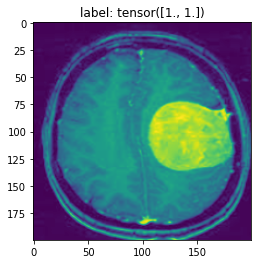

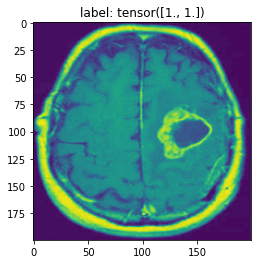

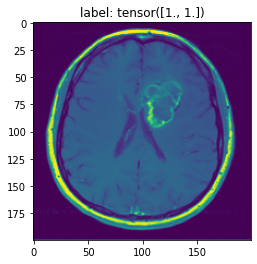

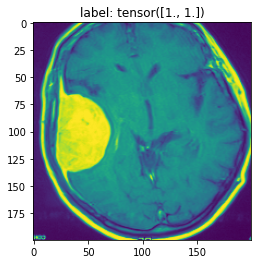

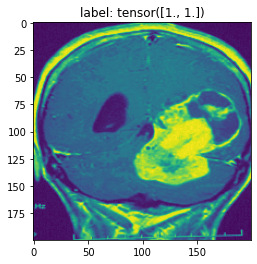

In [11]:
train_dataset = TrainDataset(folds, transform=get_transforms(data='train'))

for i in range(5):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show() 

In [12]:

tst_idx = folds[folds['fold'] == CFG.n_fold - 1].index

test_fold = folds.loc[tst_idx].reset_index(drop=True)
_test_fold = test_fold.copy(deep=True)
test_dataset = TrainDataset(_test_fold, transform=get_transforms(data='valid'))

folds = folds[folds['fold'].isin([i for i in range(CFG.n_fold - 1)])]
display(folds.groupby('fold').size())
display(folds)

fold
0    57
1    57
2    57
dtype: int64

,filename,label,T1,fold
0,Y1.jpg,1,1,2
1,Y10.jpg,1,1,1
3,Y103.jpg,1,1,1
4,Y104.jpg,1,1,0
6,Y106.jpg,1,1,2
...,...,...,...,...
220,no 7.jpeg,0,0,0
221,no 90.jpg,0,0,0
223,No14.jpg,0,0,1
224,No15.jpg,0,0,0


In [13]:
# ====================================================
# MODEL
# ====================================================
class CustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=False)
        if(pretrained):
          self.model.load_state_dict(torch.load('../models/resnext50_32x4d_a1h-0146ab0a.pth'))
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [14]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with autocast():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        scaler.scale(loss).backward()
        # loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  #'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

In [15]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_cols].values

    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomResNext(CFG.model_name, pretrained=True)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss()
    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score, scores = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}  Scores: {np.round(scores, decimals=4)}')

        """
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
        """
        
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    
    check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    for c in [f'pred_{c}' for c in CFG.target_cols]:
        valid_folds[c] = np.nan
    valid_folds[[f'pred_{c}' for c in CFG.target_cols]] = check_point['preds']

    test_loader = DataLoader(test_dataset, 
                        batch_size=CFG.batch_size, 
                        shuffle=False, 
                        num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # test
    test_labels = test_fold[CFG.target_cols].values
    avg_test_loss, preds = valid_fn(test_loader, model, criterion, device)
    score, scores = get_score(test_labels, preds)
    
    LOGGER.info(f"========== fold: {fold} test ==========")
    LOGGER.info(f'test: avg_val_loss: {avg_test_loss:.4f}')
    LOGGER.info(f'test: Score: {score:.4f}  Scores: {np.round(scores, decimals=4)}')

    return valid_folds

In [16]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train  2.folds
    """

    def get_result(result_df):
        preds = result_df[[f'pred_{c}' for c in CFG.target_cols]].values
        labels = result_df[CFG.target_cols].values
        score, scores = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}  Scores: {np.round(scores, decimals=4)}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold - 1):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                # display(_oof_df)
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)

In [17]:
main()

========== fold: 0 training ==========


Epoch: [1][0/57] Data 0.230 (0.230) Elapsed 0m 2s (remain 1m 55s) Loss: 0.7084(0.7084) Grad: nan  
Epoch: [1][10/57] Data 0.075 (0.094) Elapsed 0m 6s (remain 0m 28s) Loss: 0.6481(0.6832) Grad: 136702.1719  
Epoch: [1][20/57] Data 0.358 (0.092) Elapsed 0m 12s (remain 0m 20s) Loss: 0.6763(0.6868) Grad: 118592.1484  
Epoch: [1][30/57] Data 0.029 (0.099) Elapsed 0m 17s (remain 0m 14s) Loss: 0.6149(0.6820) Grad: 87015.0703  
Epoch: [1][40/57] Data 0.081 (0.089) Elapsed 0m 22s (remain 0m 8s) Loss: 0.6566(0.6769) Grad: 101292.6094  
Epoch: [1][50/57] Data 0.035 (0.086) Elapsed 0m 27s (remain 0m 3s) Loss: 0.5677(0.6660) Grad: 91059.8203  
Epoch: [1][56/57] Data 0.045 (0.084) Elapsed 0m 30s (remain 0m 0s) Loss: 0.7808(0.6588) Grad: 101177.4609  
EVAL: [0/15] Data 0.112 (0.112) Elapsed 0m 0s (remain 0m 2s) Loss: 0.5049(0.5049) 
EVAL: [10/15] Data 0.089 (0.119) Elapsed 0m 2s (remain 0m 1s) Loss: 0.8193(0.5883) 
EVAL: [14/15] Data 0.019 (0.109) Elapsed 0m 3s (remain 0m 0s) Loss: 0.8666(0.6565) 


Epoch 1 - avg_train_loss: 0.6588  avg_val_loss: 0.6565  time: 34s
Epoch 1 - Score: 0.7131  Scores: [0.7753 0.6509]
Epoch 1 - Save Best Loss: 0.6565 Model


Epoch: [2][0/57] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 20s) Loss: 0.7303(0.7303) Grad: inf  
Epoch: [2][10/57] Data 0.012 (0.017) Elapsed 0m 5s (remain 0m 22s) Loss: 0.4726(0.5890) Grad: 94604.3594  
Epoch: [2][20/57] Data 0.021 (0.017) Elapsed 0m 10s (remain 0m 18s) Loss: 0.6256(0.6182) Grad: 210453.1719  
Epoch: [2][30/57] Data 0.014 (0.017) Elapsed 0m 15s (remain 0m 13s) Loss: 0.4957(0.6111) Grad: 159341.9844  
Epoch: [2][40/57] Data 0.013 (0.017) Elapsed 0m 20s (remain 0m 8s) Loss: 0.6208(0.5997) Grad: 340054.2500  
Epoch: [2][50/57] Data 0.016 (0.017) Elapsed 0m 25s (remain 0m 3s) Loss: 0.5594(0.6107) Grad: 112220.0625  
Epoch: [2][56/57] Data 0.015 (0.018) Elapsed 0m 29s (remain 0m 0s) Loss: 0.3849(0.6086) Grad: 84601.1094  
EVAL: [0/15] Data 0.038 (0.038) Elapsed 0m 0s (remain 0m 2s) Loss: 0.3843(0.3843) 
EVAL: [10/15] Data 0.039 (0.035) Elapsed 0m 1s (remain 0m 0s) Loss: 0.9132(0.5452) 
EVAL: [14/15] Data 0.010 (0.035) Elapsed 0m 2s (remain 0m 0s) Loss: 0.9383(0.6318) 


Epoch 2 - avg_train_loss: 0.6086  avg_val_loss: 0.6318  time: 32s
Epoch 2 - Score: 0.8726  Scores: [0.8922 0.8529]
Epoch 2 - Save Best Loss: 0.6318 Model


Epoch: [3][0/57] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 24s) Loss: 0.5013(0.5013) Grad: inf  
Epoch: [3][10/57] Data 0.012 (0.013) Elapsed 0m 5s (remain 0m 23s) Loss: 0.6175(0.6129) Grad: 260411.8125  
Epoch: [3][20/57] Data 0.021 (0.016) Elapsed 0m 11s (remain 0m 18s) Loss: 0.6617(0.6335) Grad: 231801.6562  
Epoch: [3][30/57] Data 0.012 (0.017) Elapsed 0m 16s (remain 0m 14s) Loss: 0.3837(0.6104) Grad: 35539.4375  
Epoch: [3][40/57] Data 0.011 (0.017) Elapsed 0m 22s (remain 0m 8s) Loss: 0.6232(0.6198) Grad: 59261.0664  
Epoch: [3][50/57] Data 0.014 (0.017) Elapsed 0m 27s (remain 0m 3s) Loss: 0.3483(0.6068) Grad: 47319.8633  
Epoch: [3][56/57] Data 0.014 (0.017) Elapsed 0m 31s (remain 0m 0s) Loss: 0.6781(0.5963) Grad: 188214.2656  
EVAL: [0/15] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 1s) Loss: 0.2774(0.2774) 
EVAL: [10/15] Data 0.036 (0.043) Elapsed 0m 1s (remain 0m 0s) Loss: 0.8920(0.5024) 
EVAL: [14/15] Data 0.010 (0.040) Elapsed 0m 2s (remain 0m 0s) Loss: 0.8297(0.5973) 


Epoch 3 - avg_train_loss: 0.5963  avg_val_loss: 0.5973  time: 34s
Epoch 3 - Score: 0.9138  Scores: [0.9286 0.899 ]
Epoch 3 - Save Best Loss: 0.5973 Model


Epoch: [4][0/57] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 22s) Loss: 0.4981(0.4981) Grad: nan  
Epoch: [4][10/57] Data 0.012 (0.013) Elapsed 0m 6s (remain 0m 27s) Loss: 0.7161(0.6226) Grad: 139763.0312  
Epoch: [4][20/57] Data 0.019 (0.014) Elapsed 0m 12s (remain 0m 20s) Loss: 0.3056(0.6008) Grad: 39632.1211  
Epoch: [4][30/57] Data 0.020 (0.015) Elapsed 0m 18s (remain 0m 15s) Loss: 0.3909(0.5919) Grad: 69416.9531  
Epoch: [4][40/57] Data 0.010 (0.015) Elapsed 0m 24s (remain 0m 9s) Loss: 0.3128(0.5882) Grad: 56242.3633  
Epoch: [4][50/57] Data 0.016 (0.015) Elapsed 0m 29s (remain 0m 3s) Loss: 0.3816(0.5858) Grad: 103685.5234  
Epoch: [4][56/57] Data 0.012 (0.016) Elapsed 0m 33s (remain 0m 0s) Loss: 0.2762(0.5717) Grad: 28138.1504  
EVAL: [0/15] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 2s) Loss: 0.2383(0.2383) 
EVAL: [10/15] Data 0.036 (0.035) Elapsed 0m 1s (remain 0m 0s) Loss: 0.8705(0.4607) 
EVAL: [14/15] Data 0.009 (0.033) Elapsed 0m 2s (remain 0m 0s) Loss: 0.8166(0.5596) 


Epoch 4 - avg_train_loss: 0.5717  avg_val_loss: 0.5596  time: 36s
Epoch 4 - Score: 0.9582  Scores: [0.9662 0.9501]
Epoch 4 - Save Best Loss: 0.5596 Model


Epoch: [5][0/57] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 27s) Loss: 0.6306(0.6306) Grad: 715454.5625  
Epoch: [5][10/57] Data 0.012 (0.020) Elapsed 0m 6s (remain 0m 27s) Loss: 0.3365(0.5138) Grad: 65169.7500  
Epoch: [5][20/57] Data 0.013 (0.018) Elapsed 0m 12s (remain 0m 20s) Loss: 1.0237(0.5973) Grad: 216855.3125  
Epoch: [5][30/57] Data 0.011 (0.018) Elapsed 0m 17s (remain 0m 14s) Loss: 0.2438(0.5531) Grad: 34716.4766  
Epoch: [5][40/57] Data 0.016 (0.017) Elapsed 0m 24s (remain 0m 9s) Loss: 0.8323(0.5774) Grad: 95961.3594  
Epoch: [5][50/57] Data 0.014 (0.018) Elapsed 0m 30s (remain 0m 3s) Loss: 0.7382(0.5517) Grad: 107140.5156  
Epoch: [5][56/57] Data 0.012 (0.018) Elapsed 0m 34s (remain 0m 0s) Loss: 0.6520(0.5477) Grad: 58982.0000  
EVAL: [0/15] Data 0.026 (0.026) Elapsed 0m 0s (remain 0m 4s) Loss: 0.1936(0.1936) 
EVAL: [10/15] Data 0.042 (0.045) Elapsed 0m 2s (remain 0m 0s) Loss: 0.8529(0.4382) 
EVAL: [14/15] Data 0.008 (0.041) Elapsed 0m 2s (remain 0m 0s) Loss: 0.8034(0.545

Epoch 5 - avg_train_loss: 0.5477  avg_val_loss: 0.5451  time: 38s
Epoch 5 - Score: 0.9582  Scores: [0.9623 0.954 ]
Epoch 5 - Save Best Loss: 0.5451 Model


Epoch: [6][0/57] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 27s) Loss: 0.4648(0.4648) Grad: 733645.1250  
Epoch: [6][10/57] Data 0.019 (0.019) Elapsed 0m 6s (remain 0m 28s) Loss: 0.4678(0.4749) Grad: 84860.4609  
Epoch: [6][20/57] Data 0.012 (0.017) Elapsed 0m 12s (remain 0m 21s) Loss: 0.3296(0.4780) Grad: 86963.4297  
Epoch: [6][30/57] Data 0.012 (0.017) Elapsed 0m 18s (remain 0m 15s) Loss: 0.3466(0.5187) Grad: 70328.6719  
Epoch: [6][40/57] Data 0.013 (0.017) Elapsed 0m 25s (remain 0m 9s) Loss: 0.2413(0.5067) Grad: 32141.9590  
Epoch: [6][50/57] Data 0.015 (0.016) Elapsed 0m 31s (remain 0m 3s) Loss: 0.3818(0.5144) Grad: 45938.1523  
Epoch: [6][56/57] Data 0.012 (0.017) Elapsed 0m 35s (remain 0m 0s) Loss: 0.2625(0.5267) Grad: 48981.3320  
EVAL: [0/15] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 2s) Loss: 0.1987(0.1987) 
EVAL: [10/15] Data 0.037 (0.038) Elapsed 0m 2s (remain 0m 0s) Loss: 0.8683(0.4364) 
EVAL: [14/15] Data 0.009 (0.035) Elapsed 0m 3s (remain 0m 0s) Loss: 0.7640(0.5394)

Epoch 6 - avg_train_loss: 0.5267  avg_val_loss: 0.5394  time: 39s
Epoch 6 - Score: 0.9640  Scores: [0.9701 0.9578]
Epoch 6 - Save Best Loss: 0.5394 Model


Epoch: [7][0/57] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 24s) Loss: 0.7637(0.7637) Grad: inf  
Epoch: [7][10/57] Data 0.012 (0.014) Elapsed 0m 7s (remain 0m 32s) Loss: 0.3176(0.4653) Grad: 83584.2812  
Epoch: [7][20/57] Data 0.018 (0.015) Elapsed 0m 14s (remain 0m 25s) Loss: 0.2970(0.3921) Grad: 107034.2969  
Epoch: [7][30/57] Data 0.009 (0.016) Elapsed 0m 22s (remain 0m 18s) Loss: 0.3225(0.4225) Grad: 95632.7188  
Epoch: [7][40/57] Data 0.012 (0.016) Elapsed 0m 28s (remain 0m 11s) Loss: 0.8056(0.5216) Grad: 96079.7109  
Epoch: [7][50/57] Data 0.011 (0.015) Elapsed 0m 34s (remain 0m 4s) Loss: 0.8061(0.5284) Grad: 94237.7500  
Epoch: [7][56/57] Data 0.012 (0.016) Elapsed 0m 39s (remain 0m 0s) Loss: 0.7558(0.5420) Grad: 79433.1172  
EVAL: [0/15] Data 0.028 (0.028) Elapsed 0m 0s (remain 0m 2s) Loss: 0.1724(0.1724) 
EVAL: [10/15] Data 0.037 (0.034) Elapsed 0m 2s (remain 0m 1s) Loss: 0.9329(0.4253) 
EVAL: [14/15] Data 0.007 (0.031) Elapsed 0m 3s (remain 0m 0s) Loss: 0.7697(0.5485) 


Epoch 7 - avg_train_loss: 0.5420  avg_val_loss: 0.5485  time: 43s
Epoch 7 - Score: 0.9492  Scores: [0.9649 0.9335]


Epoch: [8][0/57] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 33s) Loss: 0.6696(0.6696) Grad: inf  
Epoch: [8][10/57] Data 0.011 (0.012) Elapsed 0m 7s (remain 0m 29s) Loss: 0.2576(0.4537) Grad: 73793.8125  
Epoch: [8][20/57] Data 0.015 (0.014) Elapsed 0m 13s (remain 0m 23s) Loss: 0.2529(0.4721) Grad: 41224.5195  
Epoch: [8][30/57] Data 0.011 (0.014) Elapsed 0m 20s (remain 0m 17s) Loss: 0.4394(0.5307) Grad: 46761.0156  
Epoch: [8][40/57] Data 0.012 (0.015) Elapsed 0m 27s (remain 0m 10s) Loss: 0.4369(0.5138) Grad: 35397.5469  
Epoch: [8][50/57] Data 0.015 (0.016) Elapsed 0m 34s (remain 0m 4s) Loss: 0.5342(0.5170) Grad: 113723.6953  
Epoch: [8][56/57] Data 0.011 (0.016) Elapsed 0m 38s (remain 0m 0s) Loss: 0.6585(0.5189) Grad: 84752.4141  
EVAL: [0/15] Data 0.029 (0.029) Elapsed 0m 0s (remain 0m 3s) Loss: 0.2467(0.2467) 
EVAL: [10/15] Data 0.030 (0.032) Elapsed 0m 2s (remain 0m 1s) Loss: 0.7942(0.4325) 
EVAL: [14/15] Data 0.006 (0.030) Elapsed 0m 3s (remain 0m 0s) Loss: 0.7830(0.5382) 


Epoch 8 - avg_train_loss: 0.5189  avg_val_loss: 0.5382  time: 42s
Epoch 8 - Score: 0.9736  Scores: [0.9714 0.9757]
Epoch 8 - Save Best Loss: 0.5382 Model


Epoch: [9][0/57] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 36s) Loss: 0.2417(0.2417) Grad: 571999.5625  
Epoch: [9][10/57] Data 0.016 (0.024) Elapsed 0m 7s (remain 0m 30s) Loss: 0.7941(0.4635) Grad: 366737.5625  
Epoch: [9][20/57] Data 0.013 (0.020) Elapsed 0m 13s (remain 0m 23s) Loss: 0.2536(0.4766) Grad: 137111.9688  
Epoch: [9][30/57] Data 0.010 (0.019) Elapsed 0m 19s (remain 0m 16s) Loss: 0.4367(0.4977) Grad: 170842.6250  
Epoch: [9][40/57] Data 0.011 (0.018) Elapsed 0m 26s (remain 0m 10s) Loss: 0.6685(0.5405) Grad: 92317.8750  
Epoch: [9][50/57] Data 0.014 (0.018) Elapsed 0m 33s (remain 0m 3s) Loss: 0.4444(0.5300) Grad: 31102.0488  
Epoch: [9][56/57] Data 0.012 (0.018) Elapsed 0m 39s (remain 0m 0s) Loss: 0.6505(0.5248) Grad: 131681.1719  
EVAL: [0/15] Data 0.030 (0.030) Elapsed 0m 0s (remain 0m 8s) Loss: 0.1670(0.1670) 
EVAL: [10/15] Data 0.033 (0.031) Elapsed 0m 2s (remain 0m 1s) Loss: 0.8960(0.4197) 
EVAL: [14/15] Data 0.008 (0.030) Elapsed 0m 3s (remain 0m 0s) Loss: 0.7425(0.

Epoch 9 - avg_train_loss: 0.5248  avg_val_loss: 0.5296  time: 43s
Epoch 9 - Score: 0.9516  Scores: [0.9377 0.9655]
Epoch 9 - Save Best Loss: 0.5296 Model


Epoch: [10][0/57] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 28s) Loss: 0.4144(0.4144) Grad: 526494.6250  
Epoch: [10][10/57] Data 0.011 (0.022) Elapsed 0m 7s (remain 0m 32s) Loss: 0.6641(0.5107) Grad: inf  
Epoch: [10][20/57] Data 0.010 (0.018) Elapsed 0m 14s (remain 0m 24s) Loss: 0.3212(0.5127) Grad: 63338.6719  
Epoch: [10][30/57] Data 0.020 (0.017) Elapsed 0m 21s (remain 0m 17s) Loss: 1.0563(0.5280) Grad: 200552.5312  
Epoch: [10][40/57] Data 0.013 (0.017) Elapsed 0m 29s (remain 0m 11s) Loss: 0.2471(0.5310) Grad: 79611.6172  
Epoch: [10][50/57] Data 0.014 (0.016) Elapsed 0m 37s (remain 0m 4s) Loss: 0.7560(0.5219) Grad: 71505.2734  
Epoch: [10][56/57] Data 0.012 (0.017) Elapsed 0m 41s (remain 0m 0s) Loss: 0.4213(0.5228) Grad: 68808.5781  
EVAL: [0/15] Data 0.029 (0.029) Elapsed 0m 0s (remain 0m 2s) Loss: 0.1530(0.1530) 
EVAL: [10/15] Data 0.042 (0.030) Elapsed 0m 3s (remain 0m 1s) Loss: 0.8195(0.4132) 
EVAL: [14/15] Data 0.011 (0.029) Elapsed 0m 4s (remain 0m 0s) Loss: 0.7272(0.506

Epoch 10 - avg_train_loss: 0.5228  avg_val_loss: 0.5067  time: 45s
Epoch 10 - Score: 0.9819  Scores: [0.974  0.9898]
Epoch 10 - Save Best Loss: 0.5067 Model


Epoch: [11][0/57] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 30s) Loss: 0.4072(0.4072) Grad: 431950.1562  
Epoch: [11][10/57] Data 0.013 (0.018) Elapsed 0m 9s (remain 0m 37s) Loss: 0.4540(0.4372) Grad: 204518.4531  
Epoch: [11][20/57] Data 0.013 (0.017) Elapsed 0m 17s (remain 0m 30s) Loss: 0.7157(0.4621) Grad: 192585.4219  
Epoch: [11][30/57] Data 0.013 (0.016) Elapsed 0m 24s (remain 0m 20s) Loss: 0.6607(0.5156) Grad: 221189.7344  
Epoch: [11][40/57] Data 0.016 (0.016) Elapsed 0m 31s (remain 0m 12s) Loss: 0.3098(0.5086) Grad: 48539.0586  
Epoch: [11][50/57] Data 0.023 (0.017) Elapsed 0m 38s (remain 0m 4s) Loss: 0.3646(0.4979) Grad: 50462.4219  
Epoch: [11][56/57] Data 0.015 (0.017) Elapsed 0m 42s (remain 0m 0s) Loss: 0.4941(0.5032) Grad: 182240.3125  
EVAL: [0/15] Data 0.037 (0.037) Elapsed 0m 0s (remain 0m 2s) Loss: 0.1753(0.1753) 
EVAL: [10/15] Data 0.028 (0.030) Elapsed 0m 3s (remain 0m 1s) Loss: 0.6853(0.3628) 
EVAL: [14/15] Data 0.015 (0.029) Elapsed 0m 5s (remain 0m 0s) Loss: 0.

Epoch 11 - avg_train_loss: 0.5032  avg_val_loss: 0.4573  time: 48s
Epoch 11 - Score: 0.9669  Scores: [0.9416 0.9923]
Epoch 11 - Save Best Loss: 0.4573 Model


Epoch: [12][0/57] Data 0.030 (0.030) Elapsed 0m 0s (remain 0m 29s) Loss: 0.3510(0.3510) Grad: 306502.3125  
Epoch: [12][10/57] Data 0.011 (0.018) Elapsed 0m 9s (remain 0m 38s) Loss: 0.3948(0.3663) Grad: 73178.8438  
Epoch: [12][20/57] Data 0.011 (0.017) Elapsed 0m 17s (remain 0m 30s) Loss: 0.2346(0.4014) Grad: 83554.1719  
Epoch: [12][30/57] Data 0.014 (0.017) Elapsed 0m 26s (remain 0m 21s) Loss: 0.5299(0.4242) Grad: 198147.7812  
Epoch: [12][40/57] Data 0.012 (0.016) Elapsed 0m 34s (remain 0m 13s) Loss: 0.3792(0.4507) Grad: 62809.2188  
Epoch: [12][50/57] Data 0.013 (0.016) Elapsed 0m 43s (remain 0m 5s) Loss: 0.2462(0.4708) Grad: 115610.2109  
Epoch: [12][56/57] Data 0.012 (0.016) Elapsed 0m 48s (remain 0m 0s) Loss: 0.2790(0.4575) Grad: 163121.0000  
EVAL: [0/15] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 3s) Loss: 0.1551(0.1551) 
EVAL: [10/15] Data 0.044 (0.032) Elapsed 0m 3s (remain 0m 1s) Loss: 0.5910(0.3333) 
EVAL: [14/15] Data 0.007 (0.030) Elapsed 0m 4s (remain 0m 0s) Loss: 0.6

Epoch 12 - avg_train_loss: 0.4575  avg_val_loss: 0.4199  time: 53s
Epoch 12 - Score: 0.9806  Scores: [0.9675 0.9936]
Epoch 12 - Save Best Loss: 0.4199 Model


Epoch: [13][0/57] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 33s) Loss: 0.2073(0.2073) Grad: inf  
Epoch: [13][10/57] Data 0.010 (0.013) Elapsed 0m 9s (remain 0m 37s) Loss: 0.2105(0.3630) Grad: 284594.5312  
Epoch: [13][20/57] Data 0.012 (0.014) Elapsed 0m 16s (remain 0m 27s) Loss: 0.4427(0.4359) Grad: 88509.4297  
Epoch: [13][30/57] Data 0.011 (0.014) Elapsed 0m 24s (remain 0m 20s) Loss: 0.1383(0.4204) Grad: 9709.9746  
Epoch: [13][40/57] Data 0.014 (0.015) Elapsed 0m 34s (remain 0m 13s) Loss: 0.4815(0.4004) Grad: 61116.6172  
Epoch: [13][50/57] Data 0.012 (0.015) Elapsed 0m 42s (remain 0m 5s) Loss: 0.0993(0.4013) Grad: 9401.2373  
Epoch: [13][56/57] Data 0.011 (0.016) Elapsed 0m 47s (remain 0m 0s) Loss: 0.2048(0.3789) Grad: 11639.4453  
EVAL: [0/15] Data 0.028 (0.028) Elapsed 0m 0s (remain 0m 2s) Loss: 0.0733(0.0733) 
EVAL: [10/15] Data 0.024 (0.032) Elapsed 0m 3s (remain 0m 1s) Loss: 0.5914(0.3521) 
EVAL: [14/15] Data 0.006 (0.031) Elapsed 0m 4s (remain 0m 0s) Loss: 0.5235(0.4250) 

Epoch 13 - avg_train_loss: 0.3789  avg_val_loss: 0.4250  time: 52s
Epoch 13 - Score: 0.9487  Scores: [0.9013 0.9962]


Epoch: [14][0/57] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 45s) Loss: 0.1651(0.1651) Grad: inf  
Epoch: [14][10/57] Data 0.011 (0.013) Elapsed 0m 9s (remain 0m 38s) Loss: 0.4236(0.4095) Grad: 397932.4062  
Epoch: [14][20/57] Data 0.012 (0.014) Elapsed 0m 17s (remain 0m 30s) Loss: 0.2214(0.2821) Grad: 277719.5625  
Epoch: [14][30/57] Data 0.012 (0.015) Elapsed 0m 26s (remain 0m 21s) Loss: 0.0530(0.4351) Grad: 28085.2188  
Epoch: [14][40/57] Data 0.011 (0.015) Elapsed 0m 34s (remain 0m 13s) Loss: 0.1676(0.4093) Grad: 40864.1758  
Epoch: [14][50/57] Data 0.012 (0.015) Elapsed 0m 42s (remain 0m 5s) Loss: 0.2294(0.4577) Grad: 124930.8594  
Epoch: [14][56/57] Data 0.012 (0.015) Elapsed 0m 48s (remain 0m 0s) Loss: 0.5930(0.4324) Grad: 169717.2031  
EVAL: [0/15] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 4s) Loss: 0.0892(0.0892) 
EVAL: [10/15] Data 0.049 (0.032) Elapsed 0m 3s (remain 0m 1s) Loss: 0.4737(0.2617) 
EVAL: [14/15] Data 0.010 (0.032) Elapsed 0m 3s (remain 0m 0s) Loss: 0.4564(0.3

Epoch 14 - avg_train_loss: 0.4324  avg_val_loss: 0.3326  time: 52s
Epoch 14 - Score: 0.9682  Scores: [0.9403 0.9962]
Epoch 14 - Save Best Loss: 0.3326 Model


Epoch: [15][0/57] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 31s) Loss: 0.0515(0.0515) Grad: 137077.8594  
Epoch: [15][10/57] Data 0.009 (0.017) Elapsed 0m 7s (remain 0m 33s) Loss: 0.0723(0.1984) Grad: 39800.5469  
Epoch: [15][20/57] Data 0.011 (0.017) Elapsed 0m 15s (remain 0m 25s) Loss: 0.1285(0.3337) Grad: 196694.2656  
Epoch: [15][30/57] Data 0.014 (0.016) Elapsed 0m 24s (remain 0m 20s) Loss: 0.0635(0.3062) Grad: 40440.8867  
Epoch: [15][40/57] Data 0.013 (0.017) Elapsed 0m 32s (remain 0m 12s) Loss: 0.2553(0.3145) Grad: 158967.6250  
Epoch: [15][50/57] Data 0.011 (0.017) Elapsed 0m 40s (remain 0m 4s) Loss: 0.1904(0.2768) Grad: 36349.5078  
Epoch: [15][56/57] Data 0.012 (0.017) Elapsed 0m 46s (remain 0m 0s) Loss: 0.0864(0.2814) Grad: 14092.8770  
EVAL: [0/15] Data 0.030 (0.030) Elapsed 0m 0s (remain 0m 2s) Loss: 0.0440(0.0440) 
EVAL: [10/15] Data 0.034 (0.030) Elapsed 0m 3s (remain 0m 1s) Loss: 0.3626(0.2184) 
EVAL: [14/15] Data 0.006 (0.028) Elapsed 0m 4s (remain 0m 0s) Loss: 0.26

Epoch 15 - avg_train_loss: 0.2814  avg_val_loss: 0.2778  time: 50s
Epoch 15 - Score: 0.9598  Scores: [0.9221 0.9974]
Epoch 15 - Save Best Loss: 0.2778 Model


Epoch: [16][0/57] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 46s) Loss: 0.1064(0.1064) Grad: 474844.5625  
Epoch: [16][10/57] Data 0.012 (0.017) Elapsed 0m 9s (remain 0m 38s) Loss: 0.0818(0.1552) Grad: 57162.1445  
Epoch: [16][20/57] Data 0.013 (0.016) Elapsed 0m 17s (remain 0m 30s) Loss: 0.2192(0.3023) Grad: 410294.2812  
Epoch: [16][30/57] Data 0.015 (0.016) Elapsed 0m 25s (remain 0m 21s) Loss: 0.1153(0.2584) Grad: 177045.7969  
Epoch: [16][40/57] Data 0.014 (0.016) Elapsed 0m 34s (remain 0m 13s) Loss: 0.0597(0.3150) Grad: 36780.8867  
Epoch: [16][50/57] Data 0.019 (0.016) Elapsed 0m 42s (remain 0m 5s) Loss: 0.2085(0.3050) Grad: 69284.4609  
Epoch: [16][56/57] Data 0.011 (0.016) Elapsed 0m 47s (remain 0m 0s) Loss: 0.0312(0.3027) Grad: 6981.3320  
EVAL: [0/15] Data 0.026 (0.026) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0717(0.0717) 
EVAL: [10/15] Data 0.027 (0.032) Elapsed 0m 3s (remain 0m 1s) Loss: 0.2115(0.1719) 
EVAL: [14/15] Data 0.007 (0.031) Elapsed 0m 4s (remain 0m 0s) Loss: 0.310

Epoch 16 - avg_train_loss: 0.3027  avg_val_loss: 0.2493  time: 52s
Epoch 16 - Score: 0.9643  Scores: [0.9286 1.    ]
Epoch 16 - Save Best Loss: 0.2493 Model


Epoch: [17][0/57] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 27s) Loss: 0.4291(0.4291) Grad: inf  
Epoch: [17][10/57] Data 0.013 (0.013) Elapsed 0m 8s (remain 0m 35s) Loss: 0.0805(0.3858) Grad: 53457.3398  
Epoch: [17][20/57] Data 0.012 (0.015) Elapsed 0m 16s (remain 0m 27s) Loss: 0.2974(0.3585) Grad: 117655.6562  
Epoch: [17][30/57] Data 0.016 (0.015) Elapsed 0m 24s (remain 0m 20s) Loss: 0.0545(0.3951) Grad: 16360.0498  
Epoch: [17][40/57] Data 0.008 (0.015) Elapsed 0m 32s (remain 0m 12s) Loss: 0.6722(0.3811) Grad: 121539.4688  
Epoch: [17][50/57] Data 0.014 (0.015) Elapsed 0m 41s (remain 0m 4s) Loss: 0.0584(0.3391) Grad: 5047.4463  
Epoch: [17][56/57] Data 0.011 (0.016) Elapsed 0m 47s (remain 0m 0s) Loss: 0.3673(0.3302) Grad: 40758.4453  
EVAL: [0/15] Data 0.035 (0.035) Elapsed 0m 0s (remain 0m 2s) Loss: 0.0569(0.0569) 
EVAL: [10/15] Data 0.022 (0.031) Elapsed 0m 4s (remain 0m 1s) Loss: 0.2275(0.1698) 
EVAL: [14/15] Data 0.006 (0.029) Elapsed 0m 5s (remain 0m 0s) Loss: 0.2485(0.2428

Epoch 17 - avg_train_loss: 0.3302  avg_val_loss: 0.2428  time: 53s
Epoch 17 - Score: 0.9643  Scores: [0.9286 1.    ]
Epoch 17 - Save Best Loss: 0.2428 Model


Epoch: [18][0/57] Data 0.011 (0.011) Elapsed 0m 0s (remain 0m 26s) Loss: 0.3920(0.3920) Grad: inf  
Epoch: [18][10/57] Data 0.018 (0.013) Elapsed 0m 9s (remain 0m 38s) Loss: 1.0305(0.4058) Grad: 458473.9375  
Epoch: [18][20/57] Data 0.011 (0.016) Elapsed 0m 17s (remain 0m 29s) Loss: 0.1621(0.4291) Grad: 58623.4492  
Epoch: [18][30/57] Data 0.014 (0.018) Elapsed 0m 25s (remain 0m 21s) Loss: 0.0289(0.3612) Grad: 17332.2422  
Epoch: [18][40/57] Data 0.013 (0.018) Elapsed 0m 33s (remain 0m 13s) Loss: 0.0253(0.3284) Grad: 11355.2324  
Epoch: [18][50/57] Data 0.013 (0.018) Elapsed 0m 40s (remain 0m 4s) Loss: 0.0429(0.2837) Grad: 44556.7461  
Epoch: [18][56/57] Data 0.017 (0.018) Elapsed 0m 45s (remain 0m 0s) Loss: 0.5071(0.2880) Grad: 388906.8125  
EVAL: [0/15] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0979(0.0979) 
EVAL: [10/15] Data 0.038 (0.028) Elapsed 0m 3s (remain 0m 1s) Loss: 0.2013(0.2497) 
EVAL: [14/15] Data 0.008 (0.027) Elapsed 0m 4s (remain 0m 0s) Loss: 0.2334(0.296

Epoch 18 - avg_train_loss: 0.2880  avg_val_loss: 0.2960  time: 50s
Epoch 18 - Score: 0.9448  Scores: [0.8896 1.    ]


Epoch: [19][0/57] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 45s) Loss: 0.0199(0.0199) Grad: 62378.4531  
Epoch: [19][10/57] Data 0.011 (0.019) Elapsed 0m 8s (remain 0m 37s) Loss: 0.2270(0.2473) Grad: 433728.4062  
Epoch: [19][20/57] Data 0.012 (0.018) Elapsed 0m 17s (remain 0m 29s) Loss: 0.0889(0.3135) Grad: 83094.0781  
Epoch: [19][30/57] Data 0.013 (0.018) Elapsed 0m 25s (remain 0m 21s) Loss: 0.0682(0.2528) Grad: 27756.4316  
Epoch: [19][40/57] Data 0.020 (0.018) Elapsed 0m 33s (remain 0m 13s) Loss: 0.3983(0.2895) Grad: 129615.6250  
Epoch: [19][50/57] Data 0.011 (0.018) Elapsed 0m 42s (remain 0m 4s) Loss: 0.2398(0.3006) Grad: 86154.3906  
Epoch: [19][56/57] Data 0.010 (0.018) Elapsed 0m 46s (remain 0m 0s) Loss: 0.1140(0.3134) Grad: 23897.4453  
EVAL: [0/15] Data 0.046 (0.046) Elapsed 0m 0s (remain 0m 2s) Loss: 0.0580(0.0580) 
EVAL: [10/15] Data 0.024 (0.030) Elapsed 0m 3s (remain 0m 1s) Loss: 0.1864(0.1804) 
EVAL: [14/15] Data 0.011 (0.028) Elapsed 0m 4s (remain 0m 0s) Loss: 0.258

Epoch 19 - avg_train_loss: 0.3134  avg_val_loss: 0.2617  time: 51s
Epoch 19 - Score: 0.9539  Scores: [0.9078 1.    ]


Epoch: [20][0/57] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 35s) Loss: 0.1376(0.1376) Grad: inf  
Epoch: [20][10/57] Data 0.070 (0.034) Elapsed 0m 8s (remain 0m 33s) Loss: 1.1513(0.6336) Grad: 564009.9375  
Epoch: [20][20/57] Data 0.013 (0.026) Elapsed 0m 14s (remain 0m 25s) Loss: 0.0224(0.3752) Grad: 9362.7998  
Epoch: [20][30/57] Data 0.011 (0.023) Elapsed 0m 23s (remain 0m 20s) Loss: 0.0588(0.3453) Grad: 70878.1875  
Epoch: [20][40/57] Data 0.012 (0.022) Elapsed 0m 32s (remain 0m 12s) Loss: 0.1711(0.3130) Grad: 19890.8574  
Epoch: [20][50/57] Data 0.012 (0.021) Elapsed 0m 40s (remain 0m 4s) Loss: 0.0140(0.2768) Grad: 1516.1832  
Epoch: [20][56/57] Data 0.013 (0.021) Elapsed 0m 45s (remain 0m 0s) Loss: 0.0552(0.2706) Grad: 9048.6670  
EVAL: [0/15] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 2s) Loss: 0.0631(0.0631) 
EVAL: [10/15] Data 0.034 (0.033) Elapsed 0m 3s (remain 0m 1s) Loss: 0.2761(0.2035) 
EVAL: [14/15] Data 0.006 (0.031) Elapsed 0m 4s (remain 0m 0s) Loss: 0.2404(0.2755) 


Epoch 20 - avg_train_loss: 0.2706  avg_val_loss: 0.2755  time: 50s
Epoch 20 - Score: 0.9539  Scores: [0.9078 1.    ]


Epoch: [21][0/57] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 33s) Loss: 0.0404(0.0404) Grad: 227717.3125  
Epoch: [21][10/57] Data 0.011 (0.016) Elapsed 0m 7s (remain 0m 32s) Loss: 0.0338(0.3374) Grad: 31698.5254  
Epoch: [21][20/57] Data 0.009 (0.017) Elapsed 0m 16s (remain 0m 27s) Loss: 0.3309(0.3775) Grad: 91836.4219  
Epoch: [21][30/57] Data 0.013 (0.016) Elapsed 0m 24s (remain 0m 20s) Loss: 0.3825(0.4139) Grad: 85194.1250  
Epoch: [21][40/57] Data 0.012 (0.016) Elapsed 0m 32s (remain 0m 12s) Loss: 0.0204(0.3840) Grad: 3440.6038  
Epoch: [21][50/57] Data 0.012 (0.016) Elapsed 0m 40s (remain 0m 4s) Loss: 0.0509(0.3378) Grad: 9304.9658  
Epoch: [21][56/57] Data 0.010 (0.017) Elapsed 0m 46s (remain 0m 0s) Loss: 0.4120(0.3424) Grad: 137041.0625  
EVAL: [0/15] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0878(0.0878) 
EVAL: [10/15] Data 0.025 (0.028) Elapsed 0m 2s (remain 0m 1s) Loss: 0.1878(0.1993) 
EVAL: [14/15] Data 0.013 (0.031) Elapsed 0m 4s (remain 0m 0s) Loss: 0.2246(

Epoch 21 - avg_train_loss: 0.3424  avg_val_loss: 0.2535  time: 50s
Epoch 21 - Score: 0.9565  Scores: [0.913 1.   ]


Epoch: [22][0/57] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 34s) Loss: 0.2567(0.2567) Grad: inf  
Epoch: [22][10/57] Data 0.015 (0.014) Elapsed 0m 8s (remain 0m 35s) Loss: 0.0424(0.2704) Grad: 116357.2656  
Epoch: [22][20/57] Data 0.013 (0.015) Elapsed 0m 16s (remain 0m 27s) Loss: 0.0393(0.2038) Grad: 17973.6758  
Epoch: [22][30/57] Data 0.009 (0.015) Elapsed 0m 24s (remain 0m 20s) Loss: 0.0072(0.2000) Grad: 2006.0969  
Epoch: [22][40/57] Data 0.011 (0.015) Elapsed 0m 32s (remain 0m 12s) Loss: 0.0452(0.2243) Grad: 19931.5352  
Epoch: [22][50/57] Data 0.015 (0.015) Elapsed 0m 42s (remain 0m 4s) Loss: 1.1685(0.2822) Grad: 240092.9219  
Epoch: [22][56/57] Data 0.010 (0.016) Elapsed 0m 47s (remain 0m 0s) Loss: 0.3139(0.2765) Grad: 34725.6953  
EVAL: [0/15] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0176(0.0176) 
EVAL: [10/15] Data 0.031 (0.035) Elapsed 0m 3s (remain 0m 1s) Loss: 0.4009(0.1551) 
EVAL: [14/15] Data 0.007 (0.032) Elapsed 0m 4s (remain 0m 0s) Loss: 0.2748(0.2573

Epoch 22 - avg_train_loss: 0.2765  avg_val_loss: 0.2573  time: 53s
Epoch 22 - Score: 0.9630  Scores: [0.9273 0.9987]


Epoch: [23][0/57] Data 0.026 (0.026) Elapsed 0m 0s (remain 0m 47s) Loss: 0.1305(0.1305) Grad: inf  
Epoch: [23][10/57] Data 0.012 (0.014) Elapsed 0m 10s (remain 0m 42s) Loss: 0.1680(0.2642) Grad: 239427.4375  
Epoch: [23][20/57] Data 0.011 (0.014) Elapsed 0m 19s (remain 0m 33s) Loss: 0.5069(0.2002) Grad: 305355.2812  
Epoch: [23][30/57] Data 0.013 (0.014) Elapsed 0m 28s (remain 0m 24s) Loss: 0.0242(0.2410) Grad: 7931.8647  
Epoch: [23][40/57] Data 0.010 (0.015) Elapsed 0m 37s (remain 0m 14s) Loss: 0.1072(0.2429) Grad: 117048.8047  
Epoch: [23][50/57] Data 0.011 (0.015) Elapsed 0m 47s (remain 0m 5s) Loss: 0.3843(0.2549) Grad: 162118.8281  
Epoch: [23][56/57] Data 0.014 (0.015) Elapsed 0m 52s (remain 0m 0s) Loss: 0.0480(0.2708) Grad: 22199.2812  
EVAL: [0/15] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 4s) Loss: 0.0763(0.0763) 
EVAL: [10/15] Data 0.025 (0.032) Elapsed 0m 3s (remain 0m 1s) Loss: 0.3224(0.1674) 
EVAL: [14/15] Data 0.007 (0.030) Elapsed 0m 4s (remain 0m 0s) Loss: 0.1418(0.2

Epoch 23 - avg_train_loss: 0.2708  avg_val_loss: 0.2350  time: 58s
Epoch 23 - Score: 0.9584  Scores: [0.9169 1.    ]
Epoch 23 - Save Best Loss: 0.2350 Model


Epoch: [24][0/57] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 28s) Loss: 0.0046(0.0046) Grad: 11580.3203  
Epoch: [24][10/57] Data 0.010 (0.017) Elapsed 0m 10s (remain 0m 43s) Loss: 0.0349(0.0851) Grad: 176529.0938  
Epoch: [24][20/57] Data 0.011 (0.016) Elapsed 0m 19s (remain 0m 34s) Loss: 0.0147(0.2326) Grad: 8580.3857  
Epoch: [24][30/57] Data 0.012 (0.016) Elapsed 0m 28s (remain 0m 23s) Loss: 0.0326(0.2599) Grad: 18956.4648  
Epoch: [24][40/57] Data 0.009 (0.016) Elapsed 0m 36s (remain 0m 14s) Loss: 0.2766(0.2712) Grad: 64643.3398  
Epoch: [24][50/57] Data 0.011 (0.016) Elapsed 0m 45s (remain 0m 5s) Loss: 0.0049(0.2438) Grad: 176.0990  
Epoch: [24][56/57] Data 0.011 (0.016) Elapsed 0m 50s (remain 0m 0s) Loss: 0.0083(0.2759) Grad: 1017.7914  
EVAL: [0/15] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 2s) Loss: 0.0703(0.0703) 
EVAL: [10/15] Data 0.039 (0.031) Elapsed 0m 4s (remain 0m 1s) Loss: 0.3539(0.2005) 
EVAL: [14/15] Data 0.008 (0.028) Elapsed 0m 5s (remain 0m 0s) Loss: 0.2933(0.

Epoch 24 - avg_train_loss: 0.2759  avg_val_loss: 0.3260  time: 56s
Epoch 24 - Score: 0.9484  Scores: [0.9416 0.9552]


Epoch: [25][0/57] Data 0.015 (0.015) Elapsed 0m 1s (remain 1m 3s) Loss: 0.7776(0.7776) Grad: inf  
Epoch: [25][10/57] Data 0.012 (0.013) Elapsed 0m 10s (remain 0m 44s) Loss: 2.1530(0.5395) Grad: inf  
Epoch: [25][20/57] Data 0.012 (0.013) Elapsed 0m 19s (remain 0m 33s) Loss: 0.0070(0.4397) Grad: 1552.0992  
Epoch: [25][30/57] Data 0.008 (0.014) Elapsed 0m 28s (remain 0m 24s) Loss: 0.4154(0.4435) Grad: 135674.4219  
Epoch: [25][40/57] Data 0.012 (0.014) Elapsed 0m 38s (remain 0m 14s) Loss: 0.8648(0.3997) Grad: 243428.9375  
Epoch: [25][50/57] Data 0.018 (0.015) Elapsed 0m 47s (remain 0m 5s) Loss: 0.0021(0.3760) Grad: 445.9007  
Epoch: [25][56/57] Data 0.010 (0.015) Elapsed 0m 52s (remain 0m 0s) Loss: 0.6979(0.3599) Grad: 358786.5312  
EVAL: [0/15] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 4s) Loss: 0.0945(0.0945) 
EVAL: [10/15] Data 0.034 (0.032) Elapsed 0m 3s (remain 0m 1s) Loss: 0.3654(0.1566) 
EVAL: [14/15] Data 0.011 (0.030) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0645(0.2649) 


Epoch 25 - avg_train_loss: 0.3599  avg_val_loss: 0.2649  time: 58s
Epoch 25 - Score: 0.9312  Scores: [0.8623 1.    ]


Epoch: [26][0/57] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 51s) Loss: 0.0973(0.0973) Grad: 391129.5312  
Epoch: [26][10/57] Data 0.013 (0.017) Elapsed 0m 10s (remain 0m 42s) Loss: 0.0177(0.1592) Grad: 53821.7656  
Epoch: [26][20/57] Data 0.013 (0.017) Elapsed 0m 19s (remain 0m 32s) Loss: 0.0064(0.2199) Grad: 971.9387  
Epoch: [26][30/57] Data 0.012 (0.017) Elapsed 0m 28s (remain 0m 23s) Loss: 0.0338(0.2733) Grad: 19572.2070  
Epoch: [26][40/57] Data 0.019 (0.018) Elapsed 0m 37s (remain 0m 14s) Loss: 0.0660(0.2531) Grad: 6875.3789  
Epoch: [26][50/57] Data 0.010 (0.017) Elapsed 0m 46s (remain 0m 5s) Loss: 0.0008(0.2151) Grad: 56.8140  
Epoch: [26][56/57] Data 0.008 (0.018) Elapsed 0m 52s (remain 0m 0s) Loss: 0.0008(0.2103) Grad: 52.1183  
EVAL: [0/15] Data 0.025 (0.025) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0854(0.0854) 
EVAL: [10/15] Data 0.024 (0.033) Elapsed 0m 3s (remain 0m 1s) Loss: 0.1361(0.1965) 
EVAL: [14/15] Data 0.006 (0.031) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0455(0.2655)

Epoch 26 - avg_train_loss: 0.2103  avg_val_loss: 0.2655  time: 57s
Epoch 26 - Score: 0.9435  Scores: [0.8922 0.9949]


Epoch: [27][0/57] Data 0.023 (0.023) Elapsed 0m 0s (remain 0m 50s) Loss: 0.0076(0.0076) Grad: 36060.3984  
Epoch: [27][10/57] Data 0.017 (0.019) Elapsed 0m 9s (remain 0m 41s) Loss: 0.0264(0.3722) Grad: 4203.3442  
Epoch: [27][20/57] Data 0.014 (0.018) Elapsed 0m 19s (remain 0m 32s) Loss: 1.0863(0.5116) Grad: 174989.0312  
Epoch: [27][30/57] Data 0.012 (0.018) Elapsed 0m 28s (remain 0m 23s) Loss: 1.0780(0.4505) Grad: 327940.3750  
Epoch: [27][40/57] Data 0.010 (0.017) Elapsed 0m 37s (remain 0m 14s) Loss: 0.0023(0.3486) Grad: 306.8870  
Epoch: [27][50/57] Data 0.011 (0.017) Elapsed 0m 46s (remain 0m 5s) Loss: 0.0198(0.3237) Grad: 3439.0894  
Epoch: [27][56/57] Data 0.008 (0.017) Elapsed 0m 52s (remain 0m 0s) Loss: 0.0003(0.2932) Grad: 52.0128  
EVAL: [0/15] Data 0.025 (0.025) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0604(0.0604) 
EVAL: [10/15] Data 0.038 (0.031) Elapsed 0m 3s (remain 0m 1s) Loss: 0.1490(0.1597) 
EVAL: [14/15] Data 0.009 (0.030) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0073(0.311

Epoch 27 - avg_train_loss: 0.2932  avg_val_loss: 0.3119  time: 57s
Epoch 27 - Score: 0.9351  Scores: [0.8701 1.    ]


Epoch: [28][0/57] Data 0.053 (0.053) Elapsed 0m 0s (remain 0m 54s) Loss: 0.0119(0.0119) Grad: 11933.7793  
Epoch: [28][10/57] Data 0.012 (0.019) Elapsed 0m 10s (remain 0m 42s) Loss: 1.4213(0.2029) Grad: inf  
Epoch: [28][20/57] Data 0.015 (0.018) Elapsed 0m 19s (remain 0m 33s) Loss: 0.0684(0.2325) Grad: 84971.1250  
Epoch: [28][30/57] Data 0.012 (0.018) Elapsed 0m 28s (remain 0m 23s) Loss: 0.0583(0.1656) Grad: 9049.5752  
Epoch: [28][40/57] Data 0.015 (0.018) Elapsed 0m 37s (remain 0m 14s) Loss: 0.0936(0.1391) Grad: 78825.5312  
Epoch: [28][50/57] Data 0.012 (0.018) Elapsed 0m 47s (remain 0m 5s) Loss: 0.7004(0.1280) Grad: 367351.5312  
Epoch: [28][56/57] Data 0.014 (0.018) Elapsed 0m 52s (remain 0m 0s) Loss: 0.0016(0.1147) Grad: 333.4374  
EVAL: [0/15] Data 0.027 (0.027) Elapsed 0m 0s (remain 0m 4s) Loss: 0.0276(0.0276) 
EVAL: [10/15] Data 0.025 (0.039) Elapsed 0m 3s (remain 0m 1s) Loss: 0.4291(0.2221) 
EVAL: [14/15] Data 0.007 (0.035) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0014(0.2504) 

Epoch 28 - avg_train_loss: 0.1147  avg_val_loss: 0.2504  time: 57s
Epoch 28 - Score: 0.9578  Scores: [0.9208 0.9949]


Epoch: [29][0/57] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 51s) Loss: 0.0022(0.0022) Grad: 11196.3721  
Epoch: [29][10/57] Data 0.013 (0.016) Elapsed 0m 9s (remain 0m 41s) Loss: 0.0012(0.2394) Grad: 643.2264  
Epoch: [29][20/57] Data 0.016 (0.016) Elapsed 0m 19s (remain 0m 32s) Loss: 0.0003(0.1292) Grad: 233.7040  
Epoch: [29][30/57] Data 0.013 (0.016) Elapsed 0m 28s (remain 0m 23s) Loss: 0.0297(0.0903) Grad: 7437.1274  
Epoch: [29][40/57] Data 0.015 (0.016) Elapsed 0m 37s (remain 0m 14s) Loss: 0.0514(0.1018) Grad: 18972.4082  
Epoch: [29][50/57] Data 0.010 (0.016) Elapsed 0m 46s (remain 0m 5s) Loss: 0.0416(0.1021) Grad: 8599.5322  
Epoch: [29][56/57] Data 0.011 (0.016) Elapsed 0m 53s (remain 0m 0s) Loss: 1.7482(0.1499) Grad: 402765.2812  
EVAL: [0/15] Data 0.025 (0.025) Elapsed 0m 0s (remain 0m 4s) Loss: 0.0280(0.0280) 
EVAL: [10/15] Data 0.024 (0.027) Elapsed 0m 4s (remain 0m 1s) Loss: 0.4527(0.1793) 
EVAL: [14/15] Data 0.013 (0.025) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0020(0.241

Epoch 29 - avg_train_loss: 0.1499  avg_val_loss: 0.2415  time: 58s
Epoch 29 - Score: 0.9630  Scores: [0.926 1.   ]


Epoch: [30][0/57] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 50s) Loss: 0.0298(0.0298) Grad: 85600.3516  
Epoch: [30][10/57] Data 0.010 (0.022) Elapsed 0m 10s (remain 0m 44s) Loss: 0.0002(0.0845) Grad: 237.0653  
Epoch: [30][20/57] Data 0.016 (0.021) Elapsed 0m 19s (remain 0m 34s) Loss: 0.0848(0.0660) Grad: 801261.1875  
Epoch: [30][30/57] Data 0.009 (0.019) Elapsed 0m 29s (remain 0m 24s) Loss: 0.0344(0.0916) Grad: 6721.0923  
Epoch: [30][40/57] Data 0.009 (0.018) Elapsed 0m 38s (remain 0m 15s) Loss: 0.1240(0.1535) Grad: 106395.2812  
Epoch: [30][50/57] Data 0.012 (0.018) Elapsed 0m 48s (remain 0m 5s) Loss: 0.1908(0.1572) Grad: 394125.3750  
Epoch: [30][56/57] Data 0.010 (0.018) Elapsed 0m 54s (remain 0m 0s) Loss: 0.0040(0.1701) Grad: 2263.7854  
EVAL: [0/15] Data 0.025 (0.025) Elapsed 0m 0s (remain 0m 4s) Loss: 0.0258(0.0258) 
EVAL: [10/15] Data 0.035 (0.030) Elapsed 0m 3s (remain 0m 1s) Loss: 0.6238(0.3126) 
EVAL: [14/15] Data 0.009 (0.028) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0001(

Epoch 30 - avg_train_loss: 0.1701  avg_val_loss: 0.3194  time: 60s
Epoch 30 - Score: 0.9630  Scores: [0.926 1.   ]


Epoch: [31][0/57] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 48s) Loss: 0.0003(0.0003) Grad: 761.0303  
Epoch: [31][10/57] Data 0.011 (0.017) Elapsed 0m 10s (remain 0m 42s) Loss: 0.0010(0.1242) Grad: 796.9876  
Epoch: [31][20/57] Data 0.011 (0.016) Elapsed 0m 19s (remain 0m 33s) Loss: 0.0004(0.0895) Grad: 90.7359  
Epoch: [31][30/57] Data 0.013 (0.016) Elapsed 0m 29s (remain 0m 24s) Loss: 0.0003(0.0669) Grad: 73.2987  
Epoch: [31][40/57] Data 0.011 (0.016) Elapsed 0m 38s (remain 0m 15s) Loss: 0.7765(0.0810) Grad: 175093.8594  
Epoch: [31][50/57] Data 0.019 (0.016) Elapsed 0m 48s (remain 0m 5s) Loss: 0.0044(0.0771) Grad: 4010.8438  
Epoch: [31][56/57] Data 0.012 (0.016) Elapsed 0m 54s (remain 0m 0s) Loss: 0.0290(0.1030) Grad: 19211.0215  
EVAL: [0/15] Data 0.025 (0.025) Elapsed 0m 0s (remain 0m 4s) Loss: 0.0119(0.0119) 
EVAL: [10/15] Data 0.025 (0.028) Elapsed 0m 3s (remain 0m 1s) Loss: 0.5115(0.1917) 
EVAL: [14/15] Data 0.009 (0.027) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0026(0.2225) 


Epoch 31 - avg_train_loss: 0.1030  avg_val_loss: 0.2225  time: 60s
Epoch 31 - Score: 0.9643  Scores: [0.9312 0.9974]
Epoch 31 - Save Best Loss: 0.2225 Model


Epoch: [32][0/57] Data 0.017 (0.017) Elapsed 0m 1s (remain 1m 12s) Loss: 0.0002(0.0002) Grad: 309.3751  
Epoch: [32][10/57] Data 0.016 (0.017) Elapsed 0m 9s (remain 0m 40s) Loss: 0.0141(0.0900) Grad: 16098.6660  
Epoch: [32][20/57] Data 0.011 (0.017) Elapsed 0m 19s (remain 0m 33s) Loss: 0.0633(0.1110) Grad: 52989.1914  
Epoch: [32][30/57] Data 0.011 (0.016) Elapsed 0m 29s (remain 0m 24s) Loss: 0.0011(0.2076) Grad: 145.0990  
Epoch: [32][40/57] Data 0.013 (0.016) Elapsed 0m 38s (remain 0m 15s) Loss: 2.2767(0.2133) Grad: 89084.1484  
Epoch: [32][50/57] Data 0.011 (0.016) Elapsed 0m 48s (remain 0m 5s) Loss: 0.0010(0.1751) Grad: 191.3975  
Epoch: [32][56/57] Data 0.016 (0.016) Elapsed 0m 54s (remain 0m 0s) Loss: 0.0039(0.1597) Grad: 1647.8372  
EVAL: [0/15] Data 0.070 (0.070) Elapsed 0m 0s (remain 0m 4s) Loss: 0.1054(0.1054) 
EVAL: [10/15] Data 0.158 (0.068) Elapsed 0m 3s (remain 0m 1s) Loss: 0.3108(0.1897) 
EVAL: [14/15] Data 0.011 (0.059) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0018(0.2863)

Epoch 32 - avg_train_loss: 0.1597  avg_val_loss: 0.2863  time: 59s
Epoch 32 - Score: 0.9526  Scores: [0.9091 0.9962]


Epoch: [33][0/57] Data 0.027 (0.027) Elapsed 0m 1s (remain 1m 25s) Loss: 0.0028(0.0028) Grad: 13800.3242  
Epoch: [33][10/57] Data 0.015 (0.021) Elapsed 0m 11s (remain 0m 47s) Loss: 0.0960(0.0536) Grad: 365835.1875  
Epoch: [33][20/57] Data 0.018 (0.020) Elapsed 0m 21s (remain 0m 36s) Loss: 0.0003(0.0960) Grad: 111.7441  
Epoch: [33][30/57] Data 0.013 (0.019) Elapsed 0m 29s (remain 0m 25s) Loss: 0.0020(0.1384) Grad: 1566.7874  
Epoch: [33][40/57] Data 0.014 (0.019) Elapsed 0m 38s (remain 0m 15s) Loss: 0.0015(0.1078) Grad: 600.6408  
Epoch: [33][50/57] Data 0.012 (0.018) Elapsed 0m 47s (remain 0m 5s) Loss: 0.1304(0.0897) Grad: 36612.2031  
Epoch: [33][56/57] Data 0.011 (0.018) Elapsed 0m 52s (remain 0m 0s) Loss: 0.0205(0.0809) Grad: 1850.1113  
EVAL: [0/15] Data 0.026 (0.026) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0893(0.0893) 
EVAL: [10/15] Data 0.025 (0.035) Elapsed 0m 3s (remain 0m 1s) Loss: 0.6238(0.2496) 
EVAL: [14/15] Data 0.010 (0.033) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0006(0.28

Epoch 33 - avg_train_loss: 0.0809  avg_val_loss: 0.2853  time: 57s
Epoch 33 - Score: 0.9604  Scores: [0.9221 0.9987]


Epoch: [34][0/57] Data 0.068 (0.068) Elapsed 0m 0s (remain 0m 51s) Loss: 0.0275(0.0275) Grad: 83899.7500  
Epoch: [34][10/57] Data 0.013 (0.021) Elapsed 0m 9s (remain 0m 38s) Loss: 0.0064(0.2047) Grad: 1219.7839  
Epoch: [34][20/57] Data 0.016 (0.019) Elapsed 0m 17s (remain 0m 30s) Loss: 0.0012(0.1187) Grad: 554.8870  
Epoch: [34][30/57] Data 0.011 (0.018) Elapsed 0m 26s (remain 0m 22s) Loss: 0.1493(0.0863) Grad: 195230.7188  
Epoch: [34][40/57] Data 0.009 (0.018) Elapsed 0m 35s (remain 0m 13s) Loss: 0.0008(0.0655) Grad: 271.6958  
Epoch: [34][50/57] Data 0.011 (0.017) Elapsed 0m 43s (remain 0m 5s) Loss: 0.0008(0.1015) Grad: 152.6498  
Epoch: [34][56/57] Data 0.013 (0.018) Elapsed 0m 48s (remain 0m 0s) Loss: 0.0015(0.1073) Grad: 330.7430  
EVAL: [0/15] Data 0.026 (0.026) Elapsed 0m 0s (remain 0m 2s) Loss: 0.0774(0.0774) 
EVAL: [10/15] Data 0.035 (0.028) Elapsed 0m 3s (remain 0m 1s) Loss: 0.6560(0.2452) 
EVAL: [14/15] Data 0.010 (0.028) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0002(0.2656) 

Epoch 34 - avg_train_loss: 0.1073  avg_val_loss: 0.2656  time: 53s
Epoch 34 - Score: 0.9662  Scores: [0.9338 0.9987]


Epoch: [35][0/57] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 38s) Loss: 0.0049(0.0049) Grad: 12003.0127  
Epoch: [35][10/57] Data 0.013 (0.016) Elapsed 0m 8s (remain 0m 35s) Loss: 0.0243(0.0412) Grad: 54307.7656  
Epoch: [35][20/57] Data 0.012 (0.016) Elapsed 0m 17s (remain 0m 29s) Loss: 0.0711(0.0301) Grad: inf  
Epoch: [35][30/57] Data 0.012 (0.015) Elapsed 0m 26s (remain 0m 21s) Loss: 2.1995(0.1426) Grad: 367934.9062  
Epoch: [35][40/57] Data 0.014 (0.015) Elapsed 0m 35s (remain 0m 14s) Loss: 0.0182(0.1417) Grad: 4683.4175  
Epoch: [35][50/57] Data 0.011 (0.015) Elapsed 0m 45s (remain 0m 5s) Loss: 0.0021(0.1287) Grad: 644.4642  
Epoch: [35][56/57] Data 0.017 (0.016) Elapsed 0m 50s (remain 0m 0s) Loss: 0.0813(0.1166) Grad: 145961.0312  
EVAL: [0/15] Data 0.032 (0.032) Elapsed 0m 0s (remain 0m 2s) Loss: 0.0617(0.0617) 
EVAL: [10/15] Data 0.031 (0.035) Elapsed 0m 3s (remain 0m 1s) Loss: 0.6316(0.2404) 
EVAL: [14/15] Data 0.009 (0.034) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0002(0.3000) 

Epoch 35 - avg_train_loss: 0.1166  avg_val_loss: 0.3000  time: 55s
Epoch 35 - Score: 0.9481  Scores: [0.8961 1.    ]


Epoch: [36][0/57] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 35s) Loss: 0.0011(0.0011) Grad: 3849.8191  
Epoch: [36][10/57] Data 0.014 (0.020) Elapsed 0m 9s (remain 0m 40s) Loss: 0.0022(0.0066) Grad: 1052.2777  
Epoch: [36][20/57] Data 0.014 (0.019) Elapsed 0m 18s (remain 0m 31s) Loss: 0.0935(0.0867) Grad: 587772.3750  
Epoch: [36][30/57] Data 0.010 (0.018) Elapsed 0m 27s (remain 0m 22s) Loss: 0.0013(0.0805) Grad: 1133.7504  
Epoch: [36][40/57] Data 0.010 (0.018) Elapsed 0m 35s (remain 0m 13s) Loss: 0.0004(0.1005) Grad: 30.9145  
Epoch: [36][50/57] Data 0.011 (0.018) Elapsed 0m 43s (remain 0m 5s) Loss: 0.0044(0.1072) Grad: 1507.3835  
Epoch: [36][56/57] Data 0.010 (0.018) Elapsed 0m 48s (remain 0m 0s) Loss: 0.0006(0.0960) Grad: 123.7222  
EVAL: [0/15] Data 0.027 (0.027) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0556(0.0556) 
EVAL: [10/15] Data 0.037 (0.046) Elapsed 0m 3s (remain 0m 1s) Loss: 0.7809(0.2701) 
EVAL: [14/15] Data 0.011 (0.042) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0000(0.2765) 

Epoch 36 - avg_train_loss: 0.0960  avg_val_loss: 0.2765  time: 52s
Epoch 36 - Score: 0.9513  Scores: [0.9026 1.    ]


Epoch: [37][0/57] Data 0.020 (0.020) Elapsed 0m 1s (remain 1m 4s) Loss: 0.0017(0.0017) Grad: 2134.9861  
Epoch: [37][10/57] Data 0.018 (0.017) Elapsed 0m 8s (remain 0m 34s) Loss: 0.0002(0.0125) Grad: 318.8135  
Epoch: [37][20/57] Data 0.008 (0.016) Elapsed 0m 17s (remain 0m 30s) Loss: 0.0002(0.0788) Grad: 294.6316  
Epoch: [37][30/57] Data 0.015 (0.016) Elapsed 0m 26s (remain 0m 22s) Loss: 0.0001(0.0587) Grad: 67.5477  
Epoch: [37][40/57] Data 0.017 (0.016) Elapsed 0m 35s (remain 0m 13s) Loss: 0.0051(0.0742) Grad: 14024.3896  
Epoch: [37][50/57] Data 0.012 (0.016) Elapsed 0m 44s (remain 0m 5s) Loss: 0.0003(0.0686) Grad: 392.0685  
Epoch: [37][56/57] Data 0.011 (0.016) Elapsed 0m 49s (remain 0m 0s) Loss: 0.0003(0.0615) Grad: 190.4586  
EVAL: [0/15] Data 0.031 (0.031) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0133(0.0133) 
EVAL: [10/15] Data 0.037 (0.034) Elapsed 0m 3s (remain 0m 1s) Loss: 0.6989(0.2426) 
EVAL: [14/15] Data 0.007 (0.032) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0000(0.2640) 


Epoch 37 - avg_train_loss: 0.0615  avg_val_loss: 0.2640  time: 54s
Epoch 37 - Score: 0.9610  Scores: [0.9234 0.9987]


Epoch: [38][0/57] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 47s) Loss: 0.0006(0.0006) Grad: 3686.8145  
Epoch: [38][10/57] Data 0.015 (0.016) Elapsed 0m 9s (remain 0m 39s) Loss: 0.0003(0.1333) Grad: 1121.9509  
Epoch: [38][20/57] Data 0.013 (0.016) Elapsed 0m 18s (remain 0m 31s) Loss: 0.0001(0.0703) Grad: 157.2718  
Epoch: [38][30/57] Data 0.010 (0.017) Elapsed 0m 25s (remain 0m 21s) Loss: 0.0184(0.0849) Grad: 55038.8711  
Epoch: [38][40/57] Data 0.012 (0.018) Elapsed 0m 32s (remain 0m 12s) Loss: 0.0002(0.1119) Grad: 79.7890  
Epoch: [38][50/57] Data 0.014 (0.018) Elapsed 0m 40s (remain 0m 4s) Loss: 0.0001(0.0901) Grad: 17.8995  
Epoch: [38][56/57] Data 0.010 (0.018) Elapsed 0m 45s (remain 0m 0s) Loss: 0.0006(0.0906) Grad: 187.7805  
EVAL: [0/15] Data 0.034 (0.034) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0646(0.0646) 
EVAL: [10/15] Data 0.038 (0.046) Elapsed 0m 3s (remain 0m 1s) Loss: 0.8571(0.3435) 
EVAL: [14/15] Data 0.008 (0.040) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0000(0.3933) 


Epoch 38 - avg_train_loss: 0.0906  avg_val_loss: 0.3933  time: 50s
Epoch 38 - Score: 0.9519  Scores: [0.9039 1.    ]


Epoch: [39][0/57] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 45s) Loss: 0.0073(0.0073) Grad: 38113.0938  
Epoch: [39][10/57] Data 0.012 (0.018) Elapsed 0m 9s (remain 0m 38s) Loss: 0.0001(0.3823) Grad: 64.7088  
Epoch: [39][20/57] Data 0.012 (0.017) Elapsed 0m 17s (remain 0m 30s) Loss: 0.0005(0.2015) Grad: 440.2943  
Epoch: [39][30/57] Data 0.012 (0.018) Elapsed 0m 25s (remain 0m 21s) Loss: 0.0014(0.1828) Grad: 1623.0239  
Epoch: [39][40/57] Data 0.011 (0.017) Elapsed 0m 34s (remain 0m 13s) Loss: 0.2176(0.2051) Grad: inf  
Epoch: [39][50/57] Data 0.015 (0.016) Elapsed 0m 42s (remain 0m 5s) Loss: 0.0089(0.1952) Grad: 1755.3666  
Epoch: [39][56/57] Data 0.010 (0.017) Elapsed 0m 47s (remain 0m 0s) Loss: 0.0000(0.1764) Grad: 1.6771  
EVAL: [0/15] Data 0.025 (0.025) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0147(0.0147) 
EVAL: [10/15] Data 0.029 (0.028) Elapsed 0m 3s (remain 0m 1s) Loss: 1.0440(0.3302) 
EVAL: [14/15] Data 0.006 (0.027) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0000(0.2894) 


Epoch 39 - avg_train_loss: 0.1764  avg_val_loss: 0.2894  time: 52s
Epoch 39 - Score: 0.9663  Scores: [0.9377 0.9949]


Epoch: [40][0/57] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 45s) Loss: 0.0001(0.0001) Grad: 334.0769  
Epoch: [40][10/57] Data 0.012 (0.019) Elapsed 0m 9s (remain 0m 39s) Loss: 1.0250(0.1086) Grad: 946941.7500  
Epoch: [40][20/57] Data 0.012 (0.017) Elapsed 0m 17s (remain 0m 30s) Loss: 0.0004(0.1058) Grad: 1469.4766  
Epoch: [40][30/57] Data 0.009 (0.017) Elapsed 0m 26s (remain 0m 21s) Loss: 0.0001(0.0796) Grad: 26.1736  
Epoch: [40][40/57] Data 0.013 (0.017) Elapsed 0m 34s (remain 0m 13s) Loss: 0.0001(0.1269) Grad: 10.2347  
Epoch: [40][50/57] Data 0.012 (0.017) Elapsed 0m 42s (remain 0m 5s) Loss: 0.0003(0.1021) Grad: 115.8896  
Epoch: [40][56/57] Data 0.012 (0.017) Elapsed 0m 48s (remain 0m 0s) Loss: 0.0003(0.0928) Grad: 32.6105  
EVAL: [0/15] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0243(0.0243) 
EVAL: [10/15] Data 0.033 (0.031) Elapsed 0m 3s (remain 0m 1s) Loss: 0.9048(0.2451) 
EVAL: [14/15] Data 0.007 (0.030) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0000(0.2798) 


Epoch 40 - avg_train_loss: 0.0928  avg_val_loss: 0.2798  time: 53s
Epoch 40 - Score: 0.9611  Scores: [0.926  0.9962]


EVAL: [0/28] Data 0.055 (0.055) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0010(0.0010) 
EVAL: [10/28] Data 0.160 (0.080) Elapsed 0m 1s (remain 0m 2s) Loss: 0.3000(0.2510) 
EVAL: [20/28] Data 0.079 (0.078) Elapsed 0m 3s (remain 0m 1s) Loss: 1.6756(0.2497) 
EVAL: [27/28] Data 0.041 (0.073) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0024(0.2200) 


========== fold: 0 test ==========
test: avg_val_loss: 0.2200
test: Score: 0.9875  Scores: [0.9796 0.9953]
========== fold: 0 result ==========
Score: 0.9643  Scores: [0.9312 0.9974]
========== fold: 1 training ==========


Epoch: [1][0/57] Data 0.014 (0.014) Elapsed 0m 1s (remain 0m 57s) Loss: 0.6867(0.6867) Grad: nan  
Epoch: [1][10/57] Data 0.011 (0.015) Elapsed 0m 9s (remain 0m 41s) Loss: 0.6962(0.6898) Grad: 86771.9453  
Epoch: [1][20/57] Data 0.014 (0.015) Elapsed 0m 19s (remain 0m 32s) Loss: 0.7120(0.6896) Grad: 148469.4062  
Epoch: [1][30/57] Data 0.014 (0.016) Elapsed 0m 28s (remain 0m 23s) Loss: 0.6721(0.6855) Grad: 100863.8047  
Epoch: [1][40/57] Data 0.013 (0.016) Elapsed 0m 37s (remain 0m 14s) Loss: 0.7391(0.6818) Grad: 201580.7031  
Epoch: [1][50/57] Data 0.011 (0.015) Elapsed 0m 46s (remain 0m 5s) Loss: 0.6304(0.6801) Grad: 85464.8438  
Epoch: [1][56/57] Data 0.014 (0.016) Elapsed 0m 52s (remain 0m 0s) Loss: 0.6052(0.6752) Grad: 82093.6406  
EVAL: [0/15] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 4s) Loss: 0.7387(0.7387) 
EVAL: [10/15] Data 0.030 (0.032) Elapsed 0m 3s (remain 0m 1s) Loss: 0.7139(0.6775) 
EVAL: [14/15] Data 0.005 (0.030) Elapsed 0m 4s (remain 0m 0s) Loss: 0.6072(0.6948) 


Epoch 1 - avg_train_loss: 0.6752  avg_val_loss: 0.6948  time: 57s
Epoch 1 - Score: 0.6523  Scores: [0.6338 0.6707]
Epoch 1 - Save Best Loss: 0.6948 Model


Epoch: [2][0/57] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 49s) Loss: 0.6097(0.6097) Grad: inf  
Epoch: [2][10/57] Data 0.009 (0.019) Elapsed 0m 10s (remain 0m 42s) Loss: 0.5906(0.6617) Grad: 186094.2031  
Epoch: [2][20/57] Data 0.011 (0.017) Elapsed 0m 19s (remain 0m 33s) Loss: 0.5053(0.6487) Grad: 166342.6562  
Epoch: [2][30/57] Data 0.015 (0.017) Elapsed 0m 28s (remain 0m 24s) Loss: 0.8311(0.6458) Grad: 250040.0156  
Epoch: [2][40/57] Data 0.011 (0.018) Elapsed 0m 40s (remain 0m 15s) Loss: 0.5445(0.6333) Grad: 206188.8594  
Epoch: [2][50/57] Data 0.019 (0.018) Elapsed 0m 48s (remain 0m 5s) Loss: 0.7264(0.6409) Grad: 100264.2578  
Epoch: [2][56/57] Data 0.014 (0.018) Elapsed 0m 53s (remain 0m 0s) Loss: 0.7933(0.6430) Grad: inf  
EVAL: [0/15] Data 0.025 (0.025) Elapsed 0m 0s (remain 0m 4s) Loss: 0.4352(0.4352) 
EVAL: [10/15] Data 1.109 (0.141) Elapsed 0m 4s (remain 0m 1s) Loss: 0.7304(0.5623) 
EVAL: [14/15] Data 0.009 (0.124) Elapsed 0m 5s (remain 0m 0s) Loss: 0.7785(0.6158) 


Epoch 2 - avg_train_loss: 0.6430  avg_val_loss: 0.6158  time: 59s
Epoch 2 - Score: 0.7461  Scores: [0.7162 0.7759]
Epoch 2 - Save Best Loss: 0.6158 Model


Epoch: [3][0/57] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 29s) Loss: 0.4568(0.4568) Grad: 646324.0625  
Epoch: [3][10/57] Data 0.018 (0.017) Elapsed 0m 9s (remain 0m 40s) Loss: 0.5626(0.6186) Grad: 239673.2344  
Epoch: [3][20/57] Data 0.011 (0.017) Elapsed 0m 17s (remain 0m 29s) Loss: 0.8391(0.6410) Grad: 224324.3125  
Epoch: [3][30/57] Data 0.010 (0.017) Elapsed 0m 26s (remain 0m 21s) Loss: 0.5250(0.6129) Grad: 76360.4688  
Epoch: [3][40/57] Data 0.014 (0.017) Elapsed 0m 34s (remain 0m 13s) Loss: 0.5745(0.6208) Grad: 112520.6328  
Epoch: [3][50/57] Data 0.010 (0.017) Elapsed 0m 44s (remain 0m 5s) Loss: 0.5844(0.6299) Grad: 38713.0156  
Epoch: [3][56/57] Data 0.016 (0.017) Elapsed 0m 51s (remain 0m 0s) Loss: 0.5149(0.6238) Grad: 31298.2578  
EVAL: [0/15] Data 0.023 (0.023) Elapsed 0m 0s (remain 0m 5s) Loss: 0.4074(0.4074) 
EVAL: [10/15] Data 0.028 (0.027) Elapsed 0m 4s (remain 0m 1s) Loss: 0.7298(0.5589) 
EVAL: [14/15] Data 0.016 (0.027) Elapsed 0m 5s (remain 0m 0s) Loss: 0.6241(0.6

Epoch 3 - avg_train_loss: 0.6238  avg_val_loss: 0.6070  time: 57s
Epoch 3 - Score: 0.8062  Scores: [0.777  0.8354]
Epoch 3 - Save Best Loss: 0.6070 Model


Epoch: [4][0/57] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 27s) Loss: 0.8001(0.8001) Grad: inf  
Epoch: [4][10/57] Data 0.011 (0.014) Elapsed 0m 9s (remain 0m 41s) Loss: 0.7854(0.6140) Grad: 137825.2812  
Epoch: [4][20/57] Data 0.017 (0.015) Elapsed 0m 18s (remain 0m 32s) Loss: 0.7004(0.5880) Grad: 167428.3750  
Epoch: [4][30/57] Data 0.010 (0.016) Elapsed 0m 28s (remain 0m 23s) Loss: 0.7877(0.5863) Grad: 146601.5938  
Epoch: [4][40/57] Data 0.010 (0.016) Elapsed 0m 37s (remain 0m 14s) Loss: 0.4924(0.6045) Grad: 103755.1016  
Epoch: [4][50/57] Data 0.018 (0.016) Elapsed 0m 46s (remain 0m 5s) Loss: 0.4669(0.6060) Grad: 95602.5234  
Epoch: [4][56/57] Data 0.021 (0.017) Elapsed 0m 52s (remain 0m 0s) Loss: 0.3787(0.5922) Grad: 93611.9688  
EVAL: [0/15] Data 0.035 (0.035) Elapsed 0m 0s (remain 0m 2s) Loss: 0.4526(0.4526) 
EVAL: [10/15] Data 0.054 (0.038) Elapsed 0m 3s (remain 0m 1s) Loss: 0.7157(0.4889) 
EVAL: [14/15] Data 0.006 (0.036) Elapsed 0m 4s (remain 0m 0s) Loss: 0.7859(0.5538) 


Epoch 4 - avg_train_loss: 0.5922  avg_val_loss: 0.5538  time: 57s
Epoch 4 - Score: 0.8639  Scores: [0.8162 0.9116]
Epoch 4 - Save Best Loss: 0.5538 Model


Epoch: [5][0/57] Data 0.014 (0.014) Elapsed 0m 0s (remain 0m 31s) Loss: 0.4604(0.4604) Grad: inf  
Epoch: [5][10/57] Data 0.009 (0.015) Elapsed 0m 9s (remain 0m 41s) Loss: 0.9102(0.5088) Grad: inf  
Epoch: [5][20/57] Data 0.011 (0.014) Elapsed 0m 18s (remain 0m 32s) Loss: 0.4988(0.5760) Grad: 56592.0273  
Epoch: [5][30/57] Data 0.015 (0.014) Elapsed 0m 27s (remain 0m 23s) Loss: 0.3397(0.5734) Grad: 45627.0625  
Epoch: [5][40/57] Data 0.012 (0.014) Elapsed 0m 36s (remain 0m 14s) Loss: 0.4542(0.5688) Grad: 65093.8164  
Epoch: [5][50/57] Data 0.012 (0.015) Elapsed 0m 47s (remain 0m 5s) Loss: 0.4547(0.5793) Grad: 83116.5312  
Epoch: [5][56/57] Data 0.012 (0.015) Elapsed 0m 54s (remain 0m 0s) Loss: 0.3520(0.5828) Grad: 99274.5156  
EVAL: [0/15] Data 0.028 (0.028) Elapsed 0m 0s (remain 0m 4s) Loss: 0.7892(0.7892) 
EVAL: [10/15] Data 0.026 (0.028) Elapsed 0m 4s (remain 0m 1s) Loss: 0.7008(0.5032) 
EVAL: [14/15] Data 0.006 (0.026) Elapsed 0m 5s (remain 0m 0s) Loss: 0.8479(0.5717) 


Epoch 5 - avg_train_loss: 0.5828  avg_val_loss: 0.5717  time: 60s
Epoch 5 - Score: 0.8635  Scores: [0.8108 0.9162]


Epoch: [6][0/57] Data 0.019 (0.019) Elapsed 0m 1s (remain 0m 56s) Loss: 0.4730(0.4730) Grad: inf  
Epoch: [6][10/57] Data 0.010 (0.014) Elapsed 0m 12s (remain 0m 51s) Loss: 0.4658(0.5067) Grad: 243318.0625  
Epoch: [6][20/57] Data 0.011 (0.015) Elapsed 0m 22s (remain 0m 37s) Loss: 0.4479(0.5521) Grad: 192581.4531  
Epoch: [6][30/57] Data 0.010 (0.015) Elapsed 0m 31s (remain 0m 26s) Loss: 0.8405(0.5552) Grad: 131342.6250  
Epoch: [6][40/57] Data 0.012 (0.016) Elapsed 0m 41s (remain 0m 16s) Loss: 0.8857(0.5782) Grad: 361088.1250  
Epoch: [6][50/57] Data 0.013 (0.016) Elapsed 0m 51s (remain 0m 6s) Loss: 0.8028(0.5734) Grad: 149621.3281  
Epoch: [6][56/57] Data 0.010 (0.016) Elapsed 0m 57s (remain 0m 0s) Loss: 0.5160(0.5778) Grad: 242938.6562  
EVAL: [0/15] Data 0.029 (0.029) Elapsed 0m 0s (remain 0m 4s) Loss: 0.5509(0.5509) 
EVAL: [10/15] Data 0.028 (0.034) Elapsed 0m 3s (remain 0m 1s) Loss: 0.7214(0.5162) 
EVAL: [14/15] Data 0.007 (0.031) Elapsed 0m 4s (remain 0m 0s) Loss: 0.9402(0.5865)

Epoch 6 - avg_train_loss: 0.5778  avg_val_loss: 0.5865  time: 62s
Epoch 6 - Score: 0.8127  Scores: [0.7946 0.8308]


Epoch: [7][0/57] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 51s) Loss: 0.9883(0.9883) Grad: inf  
Epoch: [7][10/57] Data 0.011 (0.013) Elapsed 0m 10s (remain 0m 43s) Loss: 0.4863(0.5583) Grad: 249053.1875  
Epoch: [7][20/57] Data 0.011 (0.014) Elapsed 0m 20s (remain 0m 34s) Loss: 0.3998(0.5523) Grad: 74713.0469  
Epoch: [7][30/57] Data 0.010 (0.015) Elapsed 0m 29s (remain 0m 24s) Loss: 0.8679(0.5950) Grad: 160734.2188  
Epoch: [7][40/57] Data 0.025 (0.016) Elapsed 0m 39s (remain 0m 15s) Loss: 0.4539(0.5994) Grad: 129369.9453  
Epoch: [7][50/57] Data 0.010 (0.016) Elapsed 0m 49s (remain 0m 5s) Loss: 0.4386(0.5897) Grad: 147252.9219  
Epoch: [7][56/57] Data 0.017 (0.017) Elapsed 0m 55s (remain 0m 0s) Loss: 0.3477(0.5789) Grad: 64443.1914  
EVAL: [0/15] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 4s) Loss: 0.4776(0.4776) 
EVAL: [10/15] Data 0.024 (0.029) Elapsed 0m 3s (remain 0m 1s) Loss: 0.7001(0.4757) 
EVAL: [14/15] Data 0.007 (0.029) Elapsed 0m 4s (remain 0m 0s) Loss: 0.8554(0.5438) 


Epoch 7 - avg_train_loss: 0.5789  avg_val_loss: 0.5438  time: 60s
Epoch 7 - Score: 0.8721  Scores: [0.8311 0.9131]
Epoch 7 - Save Best Loss: 0.5438 Model


Epoch: [8][0/57] Data 0.015 (0.015) Elapsed 0m 1s (remain 0m 59s) Loss: 0.4650(0.4650) Grad: inf  
Epoch: [8][10/57] Data 0.016 (0.015) Elapsed 0m 11s (remain 0m 47s) Loss: 0.4635(0.5126) Grad: 283518.3438  
Epoch: [8][20/57] Data 0.013 (0.016) Elapsed 0m 20s (remain 0m 34s) Loss: 0.6481(0.5449) Grad: 127191.2656  
Epoch: [8][30/57] Data 0.012 (0.016) Elapsed 0m 28s (remain 0m 24s) Loss: 0.5164(0.5666) Grad: 211599.6094  
Epoch: [8][40/57] Data 0.013 (0.016) Elapsed 0m 37s (remain 0m 14s) Loss: 0.8331(0.5663) Grad: 130554.9141  
Epoch: [8][50/57] Data 0.011 (0.017) Elapsed 0m 47s (remain 0m 5s) Loss: 0.3459(0.5705) Grad: 66142.0859  
Epoch: [8][56/57] Data 0.019 (0.018) Elapsed 0m 52s (remain 0m 0s) Loss: 0.8008(0.5700) Grad: 77362.6719  
EVAL: [0/15] Data 0.031 (0.031) Elapsed 0m 0s (remain 0m 6s) Loss: 3.7563(3.7563) 
EVAL: [10/15] Data 0.029 (0.034) Elapsed 0m 3s (remain 0m 1s) Loss: 0.7192(1.0540) 
EVAL: [14/15] Data 0.008 (0.031) Elapsed 0m 3s (remain 0m 0s) Loss: 0.7239(0.9935) 


Epoch 8 - avg_train_loss: 0.5700  avg_val_loss: 0.9935  time: 57s
Epoch 8 - Score: 0.6756  Scores: [0.6865 0.6646]


Epoch: [9][0/57] Data 0.024 (0.024) Elapsed 0m 1s (remain 1m 5s) Loss: 1.0778(1.0778) Grad: inf  
Epoch: [9][10/57] Data 0.013 (0.014) Elapsed 0m 10s (remain 0m 42s) Loss: 0.3830(0.5840) Grad: 82598.8828  
Epoch: [9][20/57] Data 0.017 (0.016) Elapsed 0m 19s (remain 0m 33s) Loss: 0.4845(0.5552) Grad: 176092.0156  
Epoch: [9][30/57] Data 0.011 (0.016) Elapsed 0m 28s (remain 0m 23s) Loss: 0.4201(0.5678) Grad: 53741.0859  
Epoch: [9][40/57] Data 0.010 (0.017) Elapsed 0m 36s (remain 0m 14s) Loss: 0.7243(0.5842) Grad: 75849.9844  
Epoch: [9][50/57] Data 0.010 (0.016) Elapsed 0m 44s (remain 0m 5s) Loss: 0.7101(0.5734) Grad: 65096.7695  
Epoch: [9][56/57] Data 0.011 (0.017) Elapsed 0m 49s (remain 0m 0s) Loss: 0.4307(0.5647) Grad: 37231.1016  
EVAL: [0/15] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 3s) Loss: 0.9031(0.9031) 
EVAL: [10/15] Data 0.029 (0.033) Elapsed 0m 3s (remain 0m 1s) Loss: 0.6964(0.5303) 
EVAL: [14/15] Data 0.008 (0.032) Elapsed 0m 4s (remain 0m 0s) Loss: 0.8125(0.5823) 


Epoch 9 - avg_train_loss: 0.5647  avg_val_loss: 0.5823  time: 54s
Epoch 9 - Score: 0.8257  Scores: [0.8054 0.846 ]


Epoch: [10][0/57] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 40s) Loss: 0.4842(0.4842) Grad: inf  
Epoch: [10][10/57] Data 0.013 (0.012) Elapsed 0m 8s (remain 0m 35s) Loss: 0.4404(0.5999) Grad: 126872.0312  
Epoch: [10][20/57] Data 0.019 (0.015) Elapsed 0m 16s (remain 0m 28s) Loss: 0.4048(0.5669) Grad: 100448.8750  
Epoch: [10][30/57] Data 0.014 (0.016) Elapsed 0m 24s (remain 0m 20s) Loss: 0.4111(0.5301) Grad: 96158.2969  
Epoch: [10][40/57] Data 0.018 (0.016) Elapsed 0m 32s (remain 0m 12s) Loss: 0.3810(0.5387) Grad: 146374.7500  
Epoch: [10][50/57] Data 0.014 (0.016) Elapsed 0m 41s (remain 0m 4s) Loss: 0.3080(0.5230) Grad: 195830.2188  
Epoch: [10][56/57] Data 0.012 (0.017) Elapsed 0m 46s (remain 0m 0s) Loss: 0.7251(0.5280) Grad: 261473.2344  
EVAL: [0/15] Data 0.038 (0.038) Elapsed 0m 0s (remain 0m 3s) Loss: 1.1021(1.1021) 
EVAL: [10/15] Data 0.025 (0.034) Elapsed 0m 3s (remain 0m 1s) Loss: 0.6828(0.5375) 
EVAL: [14/15] Data 0.006 (0.031) Elapsed 0m 4s (remain 0m 0s) Loss: 1.0214(0.

Epoch 10 - avg_train_loss: 0.5280  avg_val_loss: 0.5889  time: 51s
Epoch 10 - Score: 0.8444  Scores: [0.7986 0.8902]


Epoch: [11][0/57] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 43s) Loss: 1.1892(1.1892) Grad: inf  
Epoch: [11][10/57] Data 0.011 (0.013) Elapsed 0m 9s (remain 0m 38s) Loss: 0.4786(0.5504) Grad: 252912.1406  
Epoch: [11][20/57] Data 0.014 (0.016) Elapsed 0m 17s (remain 0m 30s) Loss: 0.8186(0.5308) Grad: 182175.2188  
Epoch: [11][30/57] Data 0.010 (0.017) Elapsed 0m 26s (remain 0m 22s) Loss: 0.3871(0.5541) Grad: 58997.7266  
Epoch: [11][40/57] Data 0.011 (0.017) Elapsed 0m 34s (remain 0m 13s) Loss: 0.3854(0.5373) Grad: 69691.1875  
Epoch: [11][50/57] Data 0.012 (0.017) Elapsed 0m 43s (remain 0m 5s) Loss: 1.0883(0.5181) Grad: 306530.0625  
Epoch: [11][56/57] Data 0.012 (0.017) Elapsed 0m 49s (remain 0m 0s) Loss: 0.9387(0.5254) Grad: 181857.0000  
EVAL: [0/15] Data 0.023 (0.023) Elapsed 0m 0s (remain 0m 2s) Loss: 0.5706(0.5706) 
EVAL: [10/15] Data 0.030 (0.031) Elapsed 0m 4s (remain 0m 1s) Loss: 0.7065(0.4183) 
EVAL: [14/15] Data 0.009 (0.031) Elapsed 0m 5s (remain 0m 0s) Loss: 0.7965(0.5

Epoch 11 - avg_train_loss: 0.5254  avg_val_loss: 0.5031  time: 54s
Epoch 11 - Score: 0.8377  Scores: [0.8324 0.843 ]
Epoch 11 - Save Best Loss: 0.5031 Model


Epoch: [12][0/57] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 29s) Loss: 0.3659(0.3659) Grad: inf  
Epoch: [12][10/57] Data 0.020 (0.016) Elapsed 0m 9s (remain 0m 41s) Loss: 0.2649(0.5713) Grad: 77054.1406  
Epoch: [12][20/57] Data 0.014 (0.017) Elapsed 0m 18s (remain 0m 31s) Loss: 0.4094(0.5698) Grad: 41506.4531  
Epoch: [12][30/57] Data 0.015 (0.017) Elapsed 0m 27s (remain 0m 22s) Loss: 0.7709(0.5485) Grad: 57137.1875  
Epoch: [12][40/57] Data 0.013 (0.017) Elapsed 0m 35s (remain 0m 14s) Loss: 0.2719(0.5203) Grad: 54622.7266  
Epoch: [12][50/57] Data 0.015 (0.017) Elapsed 0m 44s (remain 0m 5s) Loss: 0.3248(0.5132) Grad: 19813.6875  
Epoch: [12][56/57] Data 0.015 (0.017) Elapsed 0m 49s (remain 0m 0s) Loss: 0.3143(0.5104) Grad: 24517.1934  
EVAL: [0/15] Data 0.033 (0.033) Elapsed 0m 0s (remain 0m 3s) Loss: 0.4152(0.4152) 
EVAL: [10/15] Data 0.067 (0.036) Elapsed 0m 3s (remain 0m 1s) Loss: 0.6047(0.3720) 
EVAL: [14/15] Data 0.007 (0.033) Elapsed 0m 4s (remain 0m 0s) Loss: 0.7461(0.4567)

Epoch 12 - avg_train_loss: 0.5104  avg_val_loss: 0.4567  time: 55s
Epoch 12 - Score: 0.9125  Scores: [0.8905 0.9345]
Epoch 12 - Save Best Loss: 0.4567 Model


Epoch: [13][0/57] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 28s) Loss: 1.5377(1.5377) Grad: nan  
Epoch: [13][10/57] Data 0.014 (0.015) Elapsed 0m 8s (remain 0m 36s) Loss: 0.6109(0.6546) Grad: 233769.0781  
Epoch: [13][20/57] Data 0.011 (0.015) Elapsed 0m 18s (remain 0m 32s) Loss: 0.5605(0.5694) Grad: 300837.9375  
Epoch: [13][30/57] Data 0.009 (0.016) Elapsed 0m 27s (remain 0m 23s) Loss: 0.2979(0.4698) Grad: 113612.9453  
Epoch: [13][40/57] Data 0.012 (0.016) Elapsed 0m 36s (remain 0m 14s) Loss: 0.2480(0.4131) Grad: 127759.3438  
Epoch: [13][50/57] Data 0.013 (0.016) Elapsed 0m 45s (remain 0m 5s) Loss: 0.2372(0.4218) Grad: 136104.6250  
Epoch: [13][56/57] Data 0.015 (0.016) Elapsed 0m 50s (remain 0m 0s) Loss: 0.1639(0.4221) Grad: 33990.5703  
EVAL: [0/15] Data 0.036 (0.036) Elapsed 0m 0s (remain 0m 3s) Loss: 0.1875(0.1875) 
EVAL: [10/15] Data 0.055 (0.042) Elapsed 0m 3s (remain 0m 1s) Loss: 0.4207(0.3334) 
EVAL: [14/15] Data 0.011 (0.039) Elapsed 0m 4s (remain 0m 0s) Loss: 0.9053(0.

Epoch 13 - avg_train_loss: 0.4221  avg_val_loss: 0.3879  time: 55s
Epoch 13 - Score: 0.9191  Scores: [0.8824 0.9558]
Epoch 13 - Save Best Loss: 0.3879 Model


Epoch: [14][0/57] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 29s) Loss: 0.2242(0.2242) Grad: 357386.1562  
Epoch: [14][10/57] Data 0.019 (0.025) Elapsed 0m 9s (remain 0m 38s) Loss: 0.2791(0.3693) Grad: 120403.1641  
Epoch: [14][20/57] Data 0.020 (0.033) Elapsed 0m 19s (remain 0m 33s) Loss: 0.2419(0.3276) Grad: 99688.6641  
Epoch: [14][30/57] Data 0.016 (0.032) Elapsed 0m 28s (remain 0m 23s) Loss: 0.4351(0.3212) Grad: 129554.7969  
Epoch: [14][40/57] Data 0.011 (0.028) Elapsed 0m 36s (remain 0m 14s) Loss: 0.4933(0.3084) Grad: 149191.5000  
Epoch: [14][50/57] Data 0.010 (0.027) Elapsed 0m 47s (remain 0m 5s) Loss: 0.1212(0.3162) Grad: 16959.6621  
Epoch: [14][56/57] Data 0.011 (0.026) Elapsed 0m 52s (remain 0m 0s) Loss: 0.1618(0.3666) Grad: 72903.2266  
EVAL: [0/15] Data 0.026 (0.026) Elapsed 0m 0s (remain 0m 2s) Loss: 2.8649(2.8649) 
EVAL: [10/15] Data 0.035 (0.028) Elapsed 0m 3s (remain 0m 1s) Loss: 0.4927(0.6786) 
EVAL: [14/15] Data 0.010 (0.027) Elapsed 0m 4s (remain 0m 0s) Loss: 0.4

Epoch 14 - avg_train_loss: 0.3666  avg_val_loss: 0.6349  time: 57s
Epoch 14 - Score: 0.9003  Scores: [0.8554 0.9451]


Epoch: [15][0/57] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 43s) Loss: 0.1391(0.1391) Grad: 645072.1250  
Epoch: [15][10/57] Data 0.011 (0.015) Elapsed 0m 8s (remain 0m 37s) Loss: 0.1701(0.2426) Grad: 351671.0000  
Epoch: [15][20/57] Data 0.026 (0.018) Elapsed 0m 17s (remain 0m 29s) Loss: 0.1206(0.2638) Grad: 95694.3750  
Epoch: [15][30/57] Data 0.014 (0.018) Elapsed 0m 27s (remain 0m 23s) Loss: 0.1777(0.2921) Grad: 173352.7031  
Epoch: [15][40/57] Data 0.010 (0.020) Elapsed 0m 38s (remain 0m 14s) Loss: 0.2087(0.3056) Grad: 70817.0078  
Epoch: [15][50/57] Data 0.011 (0.019) Elapsed 0m 47s (remain 0m 5s) Loss: 0.1630(0.3464) Grad: 30643.0410  
Epoch: [15][56/57] Data 0.013 (0.019) Elapsed 0m 54s (remain 0m 0s) Loss: 0.1409(0.3393) Grad: 13711.5303  
EVAL: [0/15] Data 0.038 (0.038) Elapsed 0m 0s (remain 0m 4s) Loss: 0.4479(0.4479) 
EVAL: [10/15] Data 0.028 (0.028) Elapsed 0m 4s (remain 0m 1s) Loss: 0.3713(0.3363) 
EVAL: [14/15] Data 0.006 (0.026) Elapsed 0m 5s (remain 0m 0s) Loss: 0.35

Epoch 15 - avg_train_loss: 0.3393  avg_val_loss: 0.3435  time: 60s
Epoch 15 - Score: 0.9298  Scores: [0.8946 0.9649]
Epoch 15 - Save Best Loss: 0.3435 Model


Epoch: [16][0/57] Data 0.011 (0.011) Elapsed 0m 0s (remain 0m 32s) Loss: 0.7770(0.7770) Grad: inf  
Epoch: [16][10/57] Data 0.015 (0.016) Elapsed 0m 11s (remain 0m 49s) Loss: 0.1213(0.4578) Grad: 44427.6836  
Epoch: [16][20/57] Data 0.012 (0.024) Elapsed 0m 23s (remain 0m 39s) Loss: 0.1258(0.3933) Grad: 66087.0156  
Epoch: [16][30/57] Data 0.014 (0.021) Elapsed 0m 33s (remain 0m 28s) Loss: 0.1109(0.3412) Grad: 30933.7422  
Epoch: [16][40/57] Data 0.015 (0.020) Elapsed 0m 43s (remain 0m 16s) Loss: 0.1058(0.3103) Grad: 47950.1680  
Epoch: [16][50/57] Data 0.018 (0.021) Elapsed 0m 53s (remain 0m 6s) Loss: 0.8598(0.3249) Grad: 187328.4844  
Epoch: [16][56/57] Data 0.036 (0.022) Elapsed 0m 59s (remain 0m 0s) Loss: 0.0590(0.3114) Grad: 8741.6865  
EVAL: [0/15] Data 0.034 (0.034) Elapsed 0m 0s (remain 0m 4s) Loss: 1.0010(1.0010) 
EVAL: [10/15] Data 0.064 (0.038) Elapsed 0m 3s (remain 0m 1s) Loss: 0.5270(0.4094) 
EVAL: [14/15] Data 0.006 (0.035) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0657(0.3880

Epoch 16 - avg_train_loss: 0.3114  avg_val_loss: 0.3880  time: 65s
Epoch 16 - Score: 0.9357  Scores: [0.8851 0.9863]


Epoch: [17][0/57] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 52s) Loss: 0.6860(0.6860) Grad: nan  
Epoch: [17][10/57] Data 0.012 (0.015) Elapsed 0m 10s (remain 0m 43s) Loss: 0.1432(0.2811) Grad: 61135.1133  
Epoch: [17][20/57] Data 0.029 (0.017) Elapsed 0m 22s (remain 0m 38s) Loss: 0.0725(0.2390) Grad: 15326.1504  
Epoch: [17][30/57] Data 0.013 (0.016) Elapsed 0m 32s (remain 0m 27s) Loss: 0.0897(0.2260) Grad: 14475.1982  
Epoch: [17][40/57] Data 0.011 (0.018) Elapsed 0m 42s (remain 0m 16s) Loss: 0.0599(0.2449) Grad: 8949.0244  
Epoch: [17][50/57] Data 0.010 (0.018) Elapsed 0m 51s (remain 0m 6s) Loss: 0.1019(0.2324) Grad: 39620.2422  
Epoch: [17][56/57] Data 0.012 (0.018) Elapsed 0m 57s (remain 0m 0s) Loss: 0.2160(0.2424) Grad: 88415.1484  
EVAL: [0/15] Data 0.044 (0.044) Elapsed 0m 0s (remain 0m 3s) Loss: 4.2201(4.2201) 
EVAL: [10/15] Data 0.026 (0.043) Elapsed 0m 3s (remain 0m 1s) Loss: 0.8719(0.9767) 
EVAL: [14/15] Data 0.023 (0.040) Elapsed 0m 6s (remain 0m 0s) Loss: 0.1197(0.8571)

Epoch 17 - avg_train_loss: 0.2424  avg_val_loss: 0.8571  time: 64s
Epoch 17 - Score: 0.8816  Scores: [0.7892 0.9741]


Epoch: [18][0/57] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 55s) Loss: 0.0528(0.0528) Grad: 138101.9219  
Epoch: [18][10/57] Data 0.018 (0.017) Elapsed 0m 11s (remain 0m 47s) Loss: 0.0643(0.1878) Grad: 72376.0312  
Epoch: [18][20/57] Data 0.016 (0.016) Elapsed 0m 21s (remain 0m 37s) Loss: 0.1188(0.1780) Grad: 206947.9062  
Epoch: [18][30/57] Data 0.013 (0.016) Elapsed 0m 32s (remain 0m 26s) Loss: 0.0743(0.1871) Grad: 82762.0391  
Epoch: [18][40/57] Data 0.013 (0.016) Elapsed 0m 42s (remain 0m 16s) Loss: 0.4604(0.1985) Grad: 261099.5938  
Epoch: [18][50/57] Data 0.011 (0.016) Elapsed 0m 52s (remain 0m 6s) Loss: 0.0927(0.1809) Grad: 142931.1094  
Epoch: [18][56/57] Data 0.011 (0.016) Elapsed 0m 58s (remain 0m 0s) Loss: 0.0872(0.1817) Grad: 86310.3203  
EVAL: [0/15] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 5s) Loss: 0.8713(0.8713) 
EVAL: [10/15] Data 0.024 (0.032) Elapsed 0m 4s (remain 0m 1s) Loss: 0.4043(0.3682) 
EVAL: [14/15] Data 0.005 (0.029) Elapsed 0m 5s (remain 0m 0s) Loss: 0.

Epoch 18 - avg_train_loss: 0.1817  avg_val_loss: 0.3444  time: 64s
Epoch 18 - Score: 0.9306  Scores: [0.8689 0.9924]


Epoch: [19][0/57] Data 0.014 (0.014) Elapsed 0m 1s (remain 1m 0s) Loss: 0.2999(0.2999) Grad: inf  
Epoch: [19][10/57] Data 0.009 (0.012) Elapsed 0m 10s (remain 0m 45s) Loss: 0.0452(0.2465) Grad: 11032.7930  
Epoch: [19][20/57] Data 0.011 (0.015) Elapsed 0m 20s (remain 0m 35s) Loss: 0.1033(0.2733) Grad: 45709.2109  
Epoch: [19][30/57] Data 0.011 (0.016) Elapsed 0m 31s (remain 0m 26s) Loss: 0.0863(0.2121) Grad: 18235.8340  
Epoch: [19][40/57] Data 0.012 (0.016) Elapsed 0m 41s (remain 0m 16s) Loss: 0.0823(0.2360) Grad: 66326.3672  
Epoch: [19][50/57] Data 0.015 (0.016) Elapsed 0m 51s (remain 0m 6s) Loss: 0.0610(0.2248) Grad: 8859.7725  
Epoch: [19][56/57] Data 0.010 (0.016) Elapsed 0m 57s (remain 0m 0s) Loss: 0.0700(0.2159) Grad: 7560.9917  
EVAL: [0/15] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 4s) Loss: 1.0482(1.0482) 
EVAL: [10/15] Data 0.042 (0.030) Elapsed 0m 4s (remain 0m 1s) Loss: 0.3513(0.4429) 
EVAL: [14/15] Data 0.007 (0.028) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0977(0.3881) 


Epoch 19 - avg_train_loss: 0.2159  avg_val_loss: 0.3881  time: 63s
Epoch 19 - Score: 0.9349  Scores: [0.8851 0.9848]


Epoch: [20][0/57] Data 0.014 (0.014) Elapsed 0m 1s (remain 0m 57s) Loss: 0.0704(0.0704) Grad: 94850.6484  
Epoch: [20][10/57] Data 0.009 (0.015) Elapsed 0m 11s (remain 0m 47s) Loss: 0.1284(0.1145) Grad: 264469.0938  
Epoch: [20][20/57] Data 0.010 (0.015) Elapsed 0m 21s (remain 0m 36s) Loss: 0.0682(0.2458) Grad: 6603.7383  
Epoch: [20][30/57] Data 0.011 (0.016) Elapsed 0m 31s (remain 0m 26s) Loss: 0.2624(0.2141) Grad: 101705.2422  
Epoch: [20][40/57] Data 0.009 (0.015) Elapsed 0m 41s (remain 0m 16s) Loss: 0.3012(0.2028) Grad: 79302.1797  
Epoch: [20][50/57] Data 0.011 (0.016) Elapsed 0m 52s (remain 0m 6s) Loss: 0.5862(0.2101) Grad: 504778.4062  
Epoch: [20][56/57] Data 0.009 (0.016) Elapsed 0m 58s (remain 0m 0s) Loss: 0.0729(0.2060) Grad: 14478.3955  
EVAL: [0/15] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 4s) Loss: 4.3908(4.3908) 
EVAL: [10/15] Data 0.024 (0.028) Elapsed 0m 3s (remain 0m 1s) Loss: 0.3325(1.0999) 
EVAL: [14/15] Data 0.006 (0.026) Elapsed 0m 5s (remain 0m 0s) Loss: 0.07

Epoch 20 - avg_train_loss: 0.2060  avg_val_loss: 0.8961  time: 64s
Epoch 20 - Score: 0.8474  Scores: [0.7527 0.9421]


Epoch: [21][0/57] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 55s) Loss: 0.0318(0.0318) Grad: 56542.4375  
Epoch: [21][10/57] Data 0.011 (0.015) Elapsed 0m 10s (remain 0m 45s) Loss: 0.0985(0.0826) Grad: 96009.9922  
Epoch: [21][20/57] Data 0.008 (0.015) Elapsed 0m 21s (remain 0m 36s) Loss: 1.2882(0.1675) Grad: inf  
Epoch: [21][30/57] Data 0.010 (0.014) Elapsed 0m 31s (remain 0m 26s) Loss: 0.0616(0.1811) Grad: 15216.0352  
Epoch: [21][40/57] Data 0.009 (0.015) Elapsed 0m 41s (remain 0m 16s) Loss: 0.0664(0.1718) Grad: 15026.4248  
Epoch: [21][50/57] Data 0.011 (0.015) Elapsed 0m 51s (remain 0m 6s) Loss: 0.6969(0.2157) Grad: 218044.4219  
Epoch: [21][56/57] Data 0.011 (0.016) Elapsed 0m 57s (remain 0m 0s) Loss: 0.0658(0.2127) Grad: 42527.1602  
EVAL: [0/15] Data 0.031 (0.031) Elapsed 0m 0s (remain 0m 4s) Loss: 0.6501(0.6501) 
EVAL: [10/15] Data 0.035 (0.034) Elapsed 0m 4s (remain 0m 1s) Loss: 0.8187(0.4544) 
EVAL: [14/15] Data 0.006 (0.030) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0745(0.447

Epoch 21 - avg_train_loss: 0.2127  avg_val_loss: 0.4471  time: 63s
Epoch 21 - Score: 0.9332  Scores: [0.8892 0.9771]


Epoch: [22][0/57] Data 0.026 (0.026) Elapsed 0m 0s (remain 0m 54s) Loss: 0.0690(0.0690) Grad: 353105.3750  
Epoch: [22][10/57] Data 0.011 (0.017) Elapsed 0m 11s (remain 0m 47s) Loss: 0.0758(0.1030) Grad: 227322.4688  
Epoch: [22][20/57] Data 0.010 (0.016) Elapsed 0m 21s (remain 0m 36s) Loss: 0.1566(0.1271) Grad: 76987.1172  
Epoch: [22][30/57] Data 0.011 (0.016) Elapsed 0m 31s (remain 0m 26s) Loss: 0.2375(0.1702) Grad: 113217.8281  
Epoch: [22][40/57] Data 0.013 (0.016) Elapsed 0m 41s (remain 0m 16s) Loss: 1.0245(0.1665) Grad: 461654.2812  
Epoch: [22][50/57] Data 0.012 (0.016) Elapsed 0m 51s (remain 0m 6s) Loss: 0.1110(0.1876) Grad: 45284.0898  
Epoch: [22][56/57] Data 0.023 (0.016) Elapsed 0m 57s (remain 0m 0s) Loss: 0.0726(0.1858) Grad: 94290.1406  
EVAL: [0/15] Data 0.033 (0.033) Elapsed 0m 0s (remain 0m 4s) Loss: 1.7875(1.7875) 
EVAL: [10/15] Data 0.021 (0.029) Elapsed 0m 4s (remain 0m 1s) Loss: 0.3162(0.5977) 
EVAL: [14/15] Data 0.010 (0.029) Elapsed 0m 5s (remain 0m 0s) Loss: 0.

Epoch 22 - avg_train_loss: 0.1858  avg_val_loss: 0.5137  time: 63s
Epoch 22 - Score: 0.9020  Scores: [0.8041 1.    ]


Epoch: [23][0/57] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 55s) Loss: 0.0547(0.0547) Grad: 185309.8281  
Epoch: [23][10/57] Data 0.010 (0.018) Elapsed 0m 10s (remain 0m 44s) Loss: 0.4489(0.3998) Grad: 380265.8438  
Epoch: [23][20/57] Data 0.010 (0.017) Elapsed 0m 21s (remain 0m 36s) Loss: 0.0188(0.2996) Grad: 15271.3184  
Epoch: [23][30/57] Data 0.011 (0.016) Elapsed 0m 31s (remain 0m 26s) Loss: 0.0224(0.2389) Grad: 8221.8984  
Epoch: [23][40/57] Data 0.012 (0.016) Elapsed 0m 41s (remain 0m 16s) Loss: 0.0437(0.2006) Grad: 32577.6465  
Epoch: [23][50/57] Data 0.011 (0.016) Elapsed 0m 51s (remain 0m 6s) Loss: 0.0184(0.1858) Grad: 8339.4209  
Epoch: [23][56/57] Data 0.016 (0.017) Elapsed 0m 57s (remain 0m 0s) Loss: 0.1433(0.1855) Grad: 114362.8672  
EVAL: [0/15] Data 0.034 (0.034) Elapsed 0m 0s (remain 0m 4s) Loss: 2.0580(2.0580) 
EVAL: [10/15] Data 0.029 (0.029) Elapsed 0m 4s (remain 0m 1s) Loss: 0.3469(0.6104) 
EVAL: [14/15] Data 0.006 (0.028) Elapsed 0m 5s (remain 0m 0s) Loss: 0.014

Epoch 23 - avg_train_loss: 0.1855  avg_val_loss: 0.5038  time: 63s
Epoch 23 - Score: 0.9405  Scores: [0.8811 1.    ]


Epoch: [24][0/57] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 55s) Loss: 0.0247(0.0247) Grad: 42277.6289  
Epoch: [24][10/57] Data 0.013 (0.016) Elapsed 0m 10s (remain 0m 45s) Loss: 0.0122(0.2047) Grad: 3481.8887  
Epoch: [24][20/57] Data 0.016 (0.016) Elapsed 0m 21s (remain 0m 36s) Loss: 0.2064(0.2646) Grad: 189988.4219  
Epoch: [24][30/57] Data 0.014 (0.016) Elapsed 0m 31s (remain 0m 26s) Loss: 0.0150(0.2429) Grad: 2066.8428  
Epoch: [24][40/57] Data 0.013 (0.016) Elapsed 0m 41s (remain 0m 16s) Loss: 0.0256(0.2263) Grad: 5797.7354  
Epoch: [24][50/57] Data 0.009 (0.016) Elapsed 0m 52s (remain 0m 6s) Loss: 0.0742(0.2199) Grad: 11919.0742  
Epoch: [24][56/57] Data 0.011 (0.016) Elapsed 0m 58s (remain 0m 0s) Loss: 0.1281(0.2504) Grad: 31837.8535  
EVAL: [0/15] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 4s) Loss: 1.0265(1.0265) 
EVAL: [10/15] Data 0.047 (0.032) Elapsed 0m 3s (remain 0m 1s) Loss: 1.2769(0.4921) 
EVAL: [14/15] Data 0.006 (0.031) Elapsed 0m 5s (remain 0m 0s) Loss: 1.3028(0

Epoch 24 - avg_train_loss: 0.2504  avg_val_loss: 0.5464  time: 63s
Epoch 24 - Score: 0.9146  Scores: [0.8932 0.936 ]


Epoch: [25][0/57] Data 0.015 (0.015) Elapsed 0m 1s (remain 0m 56s) Loss: 0.0042(0.0042) Grad: 11468.1895  
Epoch: [25][10/57] Data 0.011 (0.015) Elapsed 0m 11s (remain 0m 46s) Loss: 0.2527(0.2389) Grad: inf  
Epoch: [25][20/57] Data 0.010 (0.014) Elapsed 0m 21s (remain 0m 36s) Loss: 0.3490(0.3497) Grad: 321898.9375  
Epoch: [25][30/57] Data 0.017 (0.014) Elapsed 0m 31s (remain 0m 26s) Loss: 0.0075(0.3139) Grad: 3289.8428  
Epoch: [25][40/57] Data 0.014 (0.014) Elapsed 0m 41s (remain 0m 16s) Loss: 0.0601(0.3049) Grad: 141517.2031  
Epoch: [25][50/57] Data 0.012 (0.015) Elapsed 0m 51s (remain 0m 6s) Loss: 1.6487(0.3330) Grad: 197507.5312  
Epoch: [25][56/57] Data 0.014 (0.015) Elapsed 0m 57s (remain 0m 0s) Loss: 0.0089(0.3061) Grad: 715.3409  
EVAL: [0/15] Data 0.025 (0.025) Elapsed 0m 0s (remain 0m 4s) Loss: 2.7076(2.7076) 
EVAL: [10/15] Data 0.032 (0.032) Elapsed 0m 4s (remain 0m 1s) Loss: 0.0936(0.9155) 
EVAL: [14/15] Data 0.010 (0.032) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0053(0.7942

Epoch 25 - avg_train_loss: 0.3061  avg_val_loss: 0.7942  time: 63s
Epoch 25 - Score: 0.8739  Scores: [0.7905 0.9573]


Epoch: [26][0/57] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 53s) Loss: 0.0100(0.0100) Grad: 33159.2266  
Epoch: [26][10/57] Data 0.012 (0.017) Elapsed 0m 10s (remain 0m 45s) Loss: 0.0073(0.1024) Grad: 10632.1006  
Epoch: [26][20/57] Data 0.014 (0.016) Elapsed 0m 20s (remain 0m 35s) Loss: 0.8834(0.2686) Grad: 273812.4062  
Epoch: [26][30/57] Data 0.014 (0.016) Elapsed 0m 31s (remain 0m 26s) Loss: 0.0096(0.2782) Grad: 3864.0569  
Epoch: [26][40/57] Data 0.010 (0.016) Elapsed 0m 41s (remain 0m 16s) Loss: 0.0077(0.2608) Grad: 584.8618  
Epoch: [26][50/57] Data 0.011 (0.016) Elapsed 0m 51s (remain 0m 6s) Loss: 0.0040(0.2373) Grad: 179.5121  
Epoch: [26][56/57] Data 0.010 (0.016) Elapsed 0m 57s (remain 0m 0s) Loss: 0.0126(0.2245) Grad: 7313.6436  
EVAL: [0/15] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 4s) Loss: 1.9317(1.9317) 
EVAL: [10/15] Data 0.031 (0.032) Elapsed 0m 3s (remain 0m 1s) Loss: 0.0552(1.3581) 
EVAL: [14/15] Data 0.008 (0.030) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0028(1.08

Epoch 26 - avg_train_loss: 0.2245  avg_val_loss: 1.0804  time: 62s
Epoch 26 - Score: 0.9000  Scores: [0.8351 0.9649]


Epoch: [27][0/57] Data 0.017 (0.017) Elapsed 0m 1s (remain 0m 56s) Loss: 0.0018(0.0018) Grad: 5693.2109  
Epoch: [27][10/57] Data 0.011 (0.015) Elapsed 0m 10s (remain 0m 44s) Loss: 0.0064(0.2101) Grad: 3497.6003  
Epoch: [27][20/57] Data 0.016 (0.015) Elapsed 0m 20s (remain 0m 35s) Loss: 0.0080(0.3759) Grad: 3139.9568  
Epoch: [27][30/57] Data 0.014 (0.016) Elapsed 0m 30s (remain 0m 25s) Loss: 0.0027(0.3407) Grad: 313.1223  
Epoch: [27][40/57] Data 0.011 (0.016) Elapsed 0m 41s (remain 0m 16s) Loss: 0.1687(0.2998) Grad: 65778.4609  
Epoch: [27][50/57] Data 0.010 (0.016) Elapsed 0m 50s (remain 0m 5s) Loss: 0.0012(0.2730) Grad: 106.3210  
Epoch: [27][56/57] Data 0.010 (0.016) Elapsed 0m 57s (remain 0m 0s) Loss: 0.5208(0.3082) Grad: 83349.7109  
EVAL: [0/15] Data 0.028 (0.028) Elapsed 0m 0s (remain 0m 4s) Loss: 1.6996(1.6996) 
EVAL: [10/15] Data 0.025 (0.027) Elapsed 0m 4s (remain 0m 1s) Loss: 0.0331(0.7227) 
EVAL: [14/15] Data 0.010 (0.030) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0058(0.6057

Epoch 27 - avg_train_loss: 0.3082  avg_val_loss: 0.6057  time: 62s
Epoch 27 - Score: 0.9207  Scores: [0.8811 0.9604]


Epoch: [28][0/57] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 55s) Loss: 0.0017(0.0017) Grad: 3490.4456  
Epoch: [28][10/57] Data 0.015 (0.015) Elapsed 0m 10s (remain 0m 44s) Loss: 0.0056(0.3347) Grad: 2868.4028  
Epoch: [28][20/57] Data 0.011 (0.015) Elapsed 0m 20s (remain 0m 35s) Loss: 0.1493(0.2382) Grad: 172662.4531  
Epoch: [28][30/57] Data 0.011 (0.015) Elapsed 0m 31s (remain 0m 26s) Loss: 0.7284(0.2176) Grad: 357407.4688  
Epoch: [28][40/57] Data 0.015 (0.015) Elapsed 0m 41s (remain 0m 16s) Loss: 0.2261(0.2124) Grad: inf  
Epoch: [28][50/57] Data 0.014 (0.015) Elapsed 0m 51s (remain 0m 6s) Loss: 0.0023(0.1787) Grad: 116.4417  
Epoch: [28][56/57] Data 0.009 (0.015) Elapsed 0m 57s (remain 0m 0s) Loss: 0.0332(0.1624) Grad: 2433.6956  
EVAL: [0/15] Data 0.029 (0.029) Elapsed 0m 0s (remain 0m 4s) Loss: 4.1779(4.1779) 
EVAL: [10/15] Data 0.024 (0.032) Elapsed 0m 4s (remain 0m 1s) Loss: 0.2643(1.2245) 
EVAL: [14/15] Data 0.008 (0.030) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0017(0.9612) 


Epoch 28 - avg_train_loss: 0.1624  avg_val_loss: 0.9612  time: 63s
Epoch 28 - Score: 0.8830  Scores: [0.8162 0.9497]


Epoch: [29][0/57] Data 0.013 (0.013) Elapsed 0m 1s (remain 0m 56s) Loss: 0.0047(0.0047) Grad: 12636.9102  
Epoch: [29][10/57] Data 0.015 (0.015) Elapsed 0m 11s (remain 0m 46s) Loss: 0.0976(0.0708) Grad: inf  
Epoch: [29][20/57] Data 0.013 (0.014) Elapsed 0m 21s (remain 0m 36s) Loss: 0.0137(0.0692) Grad: 44586.4375  
Epoch: [29][30/57] Data 0.011 (0.015) Elapsed 0m 31s (remain 0m 26s) Loss: 0.0006(0.1344) Grad: 167.9749  
Epoch: [29][40/57] Data 0.010 (0.015) Elapsed 0m 41s (remain 0m 16s) Loss: 0.0012(0.1552) Grad: 141.6986  
Epoch: [29][50/57] Data 0.011 (0.016) Elapsed 0m 51s (remain 0m 6s) Loss: 0.0016(0.1461) Grad: 127.1092  
Epoch: [29][56/57] Data 0.011 (0.016) Elapsed 0m 57s (remain 0m 0s) Loss: 0.0014(0.1732) Grad: 105.8505  
EVAL: [0/15] Data 0.040 (0.040) Elapsed 0m 0s (remain 0m 7s) Loss: 2.1364(2.1364) 
EVAL: [10/15] Data 0.041 (0.033) Elapsed 0m 5s (remain 0m 2s) Loss: 0.7110(0.9899) 
EVAL: [14/15] Data 0.007 (0.031) Elapsed 0m 6s (remain 0m 0s) Loss: 0.0021(0.7763) 


Epoch 29 - avg_train_loss: 0.1732  avg_val_loss: 0.7763  time: 64s
Epoch 29 - Score: 0.9274  Scores: [0.8716 0.9832]


Epoch: [30][0/57] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 54s) Loss: 0.0016(0.0016) Grad: 7242.3838  
Epoch: [30][10/57] Data 0.013 (0.018) Elapsed 0m 10s (remain 0m 44s) Loss: 0.0060(0.0154) Grad: 142233.2656  
Epoch: [30][20/57] Data 0.011 (0.017) Elapsed 0m 20s (remain 0m 34s) Loss: 0.0015(0.0559) Grad: 1640.3431  
Epoch: [30][30/57] Data 0.018 (0.017) Elapsed 0m 29s (remain 0m 24s) Loss: 0.0400(0.0529) Grad: 33170.0195  
Epoch: [30][40/57] Data 0.010 (0.017) Elapsed 0m 38s (remain 0m 15s) Loss: 0.0006(0.1008) Grad: 84.4719  
Epoch: [30][50/57] Data 0.009 (0.016) Elapsed 0m 48s (remain 0m 5s) Loss: 0.0228(0.0890) Grad: 3224.3738  
Epoch: [30][56/57] Data 0.011 (0.016) Elapsed 0m 53s (remain 0m 0s) Loss: 0.0007(0.0811) Grad: 103.1451  
EVAL: [0/15] Data 0.028 (0.028) Elapsed 0m 0s (remain 0m 4s) Loss: 2.6078(2.6078) 
EVAL: [10/15] Data 0.024 (0.031) Elapsed 0m 3s (remain 0m 1s) Loss: 0.1712(0.9040) 
EVAL: [14/15] Data 0.007 (0.029) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0036(0.7299

Epoch 30 - avg_train_loss: 0.0811  avg_val_loss: 0.7299  time: 59s
Epoch 30 - Score: 0.8994  Scores: [0.8324 0.9665]


Epoch: [31][0/57] Data 0.014 (0.014) Elapsed 0m 0s (remain 0m 49s) Loss: 0.8841(0.8841) Grad: nan  
Epoch: [31][10/57] Data 0.012 (0.020) Elapsed 0m 10s (remain 0m 43s) Loss: 0.0013(0.0846) Grad: 2431.3201  
Epoch: [31][20/57] Data 0.011 (0.018) Elapsed 0m 20s (remain 0m 35s) Loss: 0.0010(0.0501) Grad: 767.5853  
Epoch: [31][30/57] Data 0.018 (0.018) Elapsed 0m 29s (remain 0m 24s) Loss: 0.0358(0.0362) Grad: 479987.2812  
Epoch: [31][40/57] Data 0.011 (0.017) Elapsed 0m 39s (remain 0m 15s) Loss: 0.0122(0.0311) Grad: 6507.9160  
Epoch: [31][50/57] Data 0.010 (0.017) Elapsed 0m 50s (remain 0m 5s) Loss: 0.0020(0.0341) Grad: 742.3444  
Epoch: [31][56/57] Data 0.012 (0.018) Elapsed 0m 57s (remain 0m 0s) Loss: 0.0030(0.0315) Grad: 3102.4092  
EVAL: [0/15] Data 0.025 (0.025) Elapsed 0m 0s (remain 0m 2s) Loss: 2.5904(2.5904) 
EVAL: [10/15] Data 0.021 (0.029) Elapsed 0m 3s (remain 0m 1s) Loss: 0.0661(0.8927) 
EVAL: [14/15] Data 0.005 (0.027) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0026(0.7109) 


Epoch 31 - avg_train_loss: 0.0315  avg_val_loss: 0.7109  time: 63s
Epoch 31 - Score: 0.9044  Scores: [0.8378 0.971 ]


Epoch: [32][0/57] Data 0.016 (0.016) Elapsed 0m 1s (remain 0m 57s) Loss: 0.0103(0.0103) Grad: 218612.6562  
Epoch: [32][10/57] Data 0.010 (0.016) Elapsed 0m 9s (remain 0m 39s) Loss: 0.0005(0.1616) Grad: 208.7631  
Epoch: [32][20/57] Data 0.014 (0.016) Elapsed 0m 18s (remain 0m 31s) Loss: 0.0009(0.0965) Grad: 928.8026  
Epoch: [32][30/57] Data 0.010 (0.016) Elapsed 0m 27s (remain 0m 22s) Loss: 0.0202(0.0798) Grad: 43314.1914  
Epoch: [32][40/57] Data 0.011 (0.016) Elapsed 0m 36s (remain 0m 14s) Loss: 0.0021(0.0697) Grad: 871.5596  
Epoch: [32][50/57] Data 0.016 (0.016) Elapsed 0m 45s (remain 0m 5s) Loss: 0.0052(0.0672) Grad: 2016.6089  
Epoch: [32][56/57] Data 0.012 (0.017) Elapsed 0m 50s (remain 0m 0s) Loss: 0.0020(0.0613) Grad: 171.5691  
EVAL: [0/15] Data 0.043 (0.043) Elapsed 0m 0s (remain 0m 4s) Loss: 3.9161(3.9161) 
EVAL: [10/15] Data 0.025 (0.031) Elapsed 0m 3s (remain 0m 1s) Loss: 0.3447(1.0616) 
EVAL: [14/15] Data 0.005 (0.030) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0012(0.8446) 

Epoch 32 - avg_train_loss: 0.0613  avg_val_loss: 0.8446  time: 56s
Epoch 32 - Score: 0.9038  Scores: [0.8473 0.9604]


Epoch: [33][0/57] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 47s) Loss: 0.0118(0.0118) Grad: 25278.4414  
Epoch: [33][10/57] Data 0.013 (0.017) Elapsed 0m 9s (remain 0m 40s) Loss: 0.0020(0.0244) Grad: 3528.3528  
Epoch: [33][20/57] Data 0.013 (0.017) Elapsed 0m 18s (remain 0m 32s) Loss: 0.0024(0.0621) Grad: 10892.0889  
Epoch: [33][30/57] Data 0.012 (0.017) Elapsed 0m 27s (remain 0m 23s) Loss: 0.0058(0.0539) Grad: 13978.4883  
Epoch: [33][40/57] Data 0.010 (0.016) Elapsed 0m 34s (remain 0m 13s) Loss: 0.0062(0.0424) Grad: 76592.9219  
Epoch: [33][50/57] Data 0.014 (0.016) Elapsed 0m 41s (remain 0m 4s) Loss: 0.0044(0.0611) Grad: 5466.5342  
Epoch: [33][56/57] Data 0.011 (0.017) Elapsed 0m 46s (remain 0m 0s) Loss: 0.0028(0.0555) Grad: 1199.3383  
EVAL: [0/15] Data 0.023 (0.023) Elapsed 0m 0s (remain 0m 2s) Loss: 11.7553(11.7553) 
EVAL: [10/15] Data 0.033 (0.029) Elapsed 0m 3s (remain 0m 1s) Loss: 0.3420(2.6715) 
EVAL: [14/15] Data 0.006 (0.027) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0014(2

Epoch 33 - avg_train_loss: 0.0555  avg_val_loss: 2.1095  time: 52s
Epoch 33 - Score: 0.8192  Scores: [0.7649 0.8735]


Epoch: [34][0/57] Data 0.012 (0.012) Elapsed 0m 0s (remain 0m 44s) Loss: 0.1102(0.1102) Grad: inf  
Epoch: [34][10/57] Data 0.016 (0.013) Elapsed 0m 9s (remain 0m 38s) Loss: 0.0043(0.0433) Grad: 47232.7656  
Epoch: [34][20/57] Data 0.021 (0.015) Elapsed 0m 18s (remain 0m 31s) Loss: 0.0014(0.0329) Grad: 540.1813  
Epoch: [34][30/57] Data 0.014 (0.015) Elapsed 0m 27s (remain 0m 22s) Loss: 0.0022(0.0694) Grad: 346.2745  
Epoch: [34][40/57] Data 0.010 (0.015) Elapsed 0m 36s (remain 0m 14s) Loss: 0.0014(0.0787) Grad: 206.4637  
Epoch: [34][50/57] Data 0.011 (0.016) Elapsed 0m 45s (remain 0m 5s) Loss: 0.0214(0.0642) Grad: 15174.5137  
Epoch: [34][56/57] Data 0.011 (0.016) Elapsed 0m 50s (remain 0m 0s) Loss: 0.0023(0.0688) Grad: 424.5498  
EVAL: [0/15] Data 0.025 (0.025) Elapsed 0m 0s (remain 0m 4s) Loss: 4.9889(4.9889) 
EVAL: [10/15] Data 0.026 (0.030) Elapsed 0m 3s (remain 0m 1s) Loss: 0.1873(1.4748) 
EVAL: [14/15] Data 0.005 (0.028) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0009(1.1800) 


Epoch 34 - avg_train_loss: 0.0688  avg_val_loss: 1.1800  time: 55s
Epoch 34 - Score: 0.8699  Scores: [0.7824 0.9573]


Epoch: [35][0/57] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 45s) Loss: 0.0899(0.0899) Grad: inf  
Epoch: [35][10/57] Data 0.014 (0.014) Elapsed 0m 9s (remain 0m 41s) Loss: 0.0253(0.0897) Grad: 133545.3438  
Epoch: [35][20/57] Data 0.013 (0.016) Elapsed 0m 18s (remain 0m 32s) Loss: 0.0005(0.1167) Grad: 189.5327  
Epoch: [35][30/57] Data 0.010 (0.016) Elapsed 0m 27s (remain 0m 22s) Loss: 0.0010(0.0863) Grad: 78.7217  
Epoch: [35][40/57] Data 0.011 (0.016) Elapsed 0m 35s (remain 0m 13s) Loss: 0.0010(0.0658) Grad: 109.7779  
Epoch: [35][50/57] Data 0.010 (0.016) Elapsed 0m 44s (remain 0m 5s) Loss: 0.0066(0.0653) Grad: 1713.0626  
Epoch: [35][56/57] Data 0.013 (0.016) Elapsed 0m 49s (remain 0m 0s) Loss: 0.0033(0.0750) Grad: 1728.0791  
EVAL: [0/15] Data 0.027 (0.027) Elapsed 0m 0s (remain 0m 3s) Loss: 2.2978(2.2978) 
EVAL: [10/15] Data 0.036 (0.030) Elapsed 0m 3s (remain 0m 1s) Loss: 0.6198(1.2531) 
EVAL: [14/15] Data 0.006 (0.029) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0001(0.9712) 


Epoch 35 - avg_train_loss: 0.0750  avg_val_loss: 0.9712  time: 54s
Epoch 35 - Score: 0.9348  Scores: [0.8878 0.9817]


Epoch: [36][0/57] Data 0.028 (0.028) Elapsed 0m 0s (remain 0m 46s) Loss: 0.4884(0.4884) Grad: nan  
Epoch: [36][10/57] Data 0.010 (0.014) Elapsed 0m 9s (remain 0m 39s) Loss: 0.0005(0.1034) Grad: 557.6545  
Epoch: [36][20/57] Data 0.010 (0.015) Elapsed 0m 18s (remain 0m 31s) Loss: 0.0006(0.0550) Grad: 584.6495  
Epoch: [36][30/57] Data 0.010 (0.016) Elapsed 0m 27s (remain 0m 22s) Loss: 0.0004(0.0678) Grad: 163.8772  
Epoch: [36][40/57] Data 0.011 (0.016) Elapsed 0m 35s (remain 0m 14s) Loss: 0.0502(0.0536) Grad: 138562.8906  
Epoch: [36][50/57] Data 0.012 (0.016) Elapsed 0m 43s (remain 0m 5s) Loss: 0.0014(0.0793) Grad: 460.1140  
Epoch: [36][56/57] Data 0.010 (0.016) Elapsed 0m 47s (remain 0m 0s) Loss: 0.0006(0.0711) Grad: 78.6468  
EVAL: [0/15] Data 0.030 (0.030) Elapsed 0m 0s (remain 0m 3s) Loss: 2.2523(2.2523) 
EVAL: [10/15] Data 0.028 (0.036) Elapsed 0m 3s (remain 0m 1s) Loss: 0.2690(0.8106) 
EVAL: [14/15] Data 0.007 (0.034) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0001(0.6278) 


Epoch 36 - avg_train_loss: 0.0711  avg_val_loss: 0.6278  time: 52s
Epoch 36 - Score: 0.9493  Scores: [0.8986 1.    ]


Epoch: [37][0/57] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 37s) Loss: 0.0032(0.0032) Grad: 4050.5339  
Epoch: [37][10/57] Data 0.010 (0.016) Elapsed 0m 7s (remain 0m 32s) Loss: 0.0004(0.1154) Grad: 272.2397  
Epoch: [37][20/57] Data 0.010 (0.016) Elapsed 0m 16s (remain 0m 28s) Loss: 0.0019(0.1082) Grad: 1731.3949  
Epoch: [37][30/57] Data 0.010 (0.017) Elapsed 0m 25s (remain 0m 21s) Loss: 0.0004(0.0777) Grad: 215.4879  
Epoch: [37][40/57] Data 0.011 (0.016) Elapsed 0m 34s (remain 0m 13s) Loss: 0.7030(0.1195) Grad: 469895.8125  
Epoch: [37][50/57] Data 0.012 (0.017) Elapsed 0m 43s (remain 0m 5s) Loss: 0.0003(0.0969) Grad: 71.8930  
Epoch: [37][56/57] Data 0.010 (0.017) Elapsed 0m 48s (remain 0m 0s) Loss: 0.0044(0.0997) Grad: 1176.4662  
EVAL: [0/15] Data 0.028 (0.028) Elapsed 0m 0s (remain 0m 3s) Loss: 2.7077(2.7077) 
EVAL: [10/15] Data 0.025 (0.028) Elapsed 0m 3s (remain 0m 1s) Loss: 0.0171(0.9743) 
EVAL: [14/15] Data 0.006 (0.027) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0061(0.7656) 


Epoch 37 - avg_train_loss: 0.0997  avg_val_loss: 0.7656  time: 53s
Epoch 37 - Score: 0.9283  Scores: [0.8581 0.9985]


Epoch: [38][0/57] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 49s) Loss: 0.0307(0.0307) Grad: 334934.8125  
Epoch: [38][10/57] Data 0.012 (0.016) Elapsed 0m 9s (remain 0m 40s) Loss: 0.0003(0.1332) Grad: 339.4940  
Epoch: [38][20/57] Data 0.019 (0.016) Elapsed 0m 18s (remain 0m 31s) Loss: 0.0001(0.0704) Grad: 87.7851  
Epoch: [38][30/57] Data 0.012 (0.016) Elapsed 0m 27s (remain 0m 22s) Loss: 0.0022(0.0578) Grad: 1695.1787  
Epoch: [38][40/57] Data 0.012 (0.016) Elapsed 0m 35s (remain 0m 14s) Loss: 0.0004(0.0447) Grad: 1083.1342  
Epoch: [38][50/57] Data 0.013 (0.016) Elapsed 0m 44s (remain 0m 5s) Loss: 0.1445(0.0412) Grad: inf  
Epoch: [38][56/57] Data 0.009 (0.016) Elapsed 0m 49s (remain 0m 0s) Loss: 0.0003(0.0373) Grad: 166.9830  
EVAL: [0/15] Data 0.026 (0.026) Elapsed 0m 0s (remain 0m 9s) Loss: 1.2834(1.2834) 
EVAL: [10/15] Data 0.023 (0.034) Elapsed 0m 3s (remain 0m 1s) Loss: 1.2473(1.4269) 
EVAL: [14/15] Data 0.007 (0.032) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0003(1.1501) 


Epoch 38 - avg_train_loss: 0.0373  avg_val_loss: 1.1501  time: 54s
Epoch 38 - Score: 0.9450  Scores: [0.8946 0.9954]


Epoch: [39][0/57] Data 0.015 (0.015) Elapsed 0m 1s (remain 1m 1s) Loss: 0.0010(0.0010) Grad: 13878.6641  
Epoch: [39][10/57] Data 0.012 (0.018) Elapsed 0m 9s (remain 0m 39s) Loss: 1.7304(0.1828) Grad: nan  
Epoch: [39][20/57] Data 0.011 (0.015) Elapsed 0m 17s (remain 0m 30s) Loss: 0.0007(0.0999) Grad: 321.9008  
Epoch: [39][30/57] Data 0.009 (0.015) Elapsed 0m 26s (remain 0m 22s) Loss: 2.4596(0.1530) Grad: 282812.8125  
Epoch: [39][40/57] Data 0.022 (0.016) Elapsed 0m 34s (remain 0m 13s) Loss: 0.0135(0.1162) Grad: 13838.7627  
Epoch: [39][50/57] Data 0.012 (0.016) Elapsed 0m 43s (remain 0m 5s) Loss: 0.0035(0.1190) Grad: 301.2015  
Epoch: [39][56/57] Data 0.011 (0.016) Elapsed 0m 48s (remain 0m 0s) Loss: 0.0018(0.1068) Grad: 63.7296  
EVAL: [0/15] Data 0.028 (0.028) Elapsed 0m 0s (remain 0m 3s) Loss: 1.6329(1.6329) 
EVAL: [10/15] Data 0.028 (0.030) Elapsed 0m 3s (remain 0m 1s) Loss: 0.8380(0.9435) 
EVAL: [14/15] Data 0.008 (0.028) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0011(0.7336) 


Epoch 39 - avg_train_loss: 0.1068  avg_val_loss: 0.7336  time: 53s
Epoch 39 - Score: 0.9492  Scores: [0.9014 0.997 ]


Epoch: [40][0/57] Data 0.012 (0.012) Elapsed 0m 0s (remain 0m 44s) Loss: 0.0012(0.0012) Grad: 19193.7090  
Epoch: [40][10/57] Data 0.011 (0.017) Elapsed 0m 9s (remain 0m 37s) Loss: 0.0015(0.0763) Grad: 8953.0137  
Epoch: [40][20/57] Data 0.010 (0.017) Elapsed 0m 18s (remain 0m 31s) Loss: 0.0007(0.0430) Grad: 1420.6202  
Epoch: [40][30/57] Data 0.012 (0.016) Elapsed 0m 26s (remain 0m 21s) Loss: 0.0004(0.0876) Grad: 168.7820  
Epoch: [40][40/57] Data 0.014 (0.017) Elapsed 0m 36s (remain 0m 14s) Loss: 0.0016(0.0893) Grad: 164.8441  
Epoch: [40][50/57] Data 0.011 (0.017) Elapsed 0m 44s (remain 0m 5s) Loss: 0.0007(0.0720) Grad: 159.9593  
Epoch: [40][56/57] Data 0.010 (0.017) Elapsed 0m 49s (remain 0m 0s) Loss: 0.0008(0.0645) Grad: 666.0965  
EVAL: [0/15] Data 0.029 (0.029) Elapsed 0m 0s (remain 0m 3s) Loss: 0.1709(0.1709) 
EVAL: [10/15] Data 0.060 (0.035) Elapsed 0m 2s (remain 0m 1s) Loss: 0.6888(0.4466) 
EVAL: [14/15] Data 0.006 (0.034) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0002(0.3464) 


Epoch 40 - avg_train_loss: 0.0645  avg_val_loss: 0.3464  time: 54s
Epoch 40 - Score: 0.9757  Scores: [0.9514 1.    ]


EVAL: [0/28] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 2s) Loss: 0.0075(0.0075) 
EVAL: [10/28] Data 0.015 (0.018) Elapsed 0m 1s (remain 0m 2s) Loss: 0.6133(0.4426) 
EVAL: [20/28] Data 0.020 (0.021) Elapsed 0m 3s (remain 0m 1s) Loss: 1.5743(0.4224) 
EVAL: [27/28] Data 0.023 (0.021) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0075(0.3713) 


========== fold: 1 test ==========
test: avg_val_loss: 0.3713
test: Score: 0.9613  Scores: [0.9429 0.9797]
========== fold: 1 result ==========
Score: 0.9298  Scores: [0.8946 0.9649]
========== fold: 2 training ==========


Epoch: [1][0/57] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 52s) Loss: 0.7100(0.7100) Grad: nan  
Epoch: [1][10/57] Data 0.019 (0.016) Elapsed 0m 8s (remain 0m 35s) Loss: 0.6781(0.7010) Grad: 84553.6797  
Epoch: [1][20/57] Data 0.015 (0.019) Elapsed 0m 16s (remain 0m 29s) Loss: 0.6894(0.6962) Grad: 74015.8906  
Epoch: [1][30/57] Data 0.011 (0.018) Elapsed 0m 27s (remain 0m 22s) Loss: 0.6598(0.6915) Grad: 92606.4297  
Epoch: [1][40/57] Data 0.010 (0.018) Elapsed 0m 37s (remain 0m 14s) Loss: 0.7497(0.6842) Grad: 97513.3984  
Epoch: [1][50/57] Data 0.012 (0.018) Elapsed 0m 47s (remain 0m 5s) Loss: 0.7588(0.6786) Grad: 43405.8164  
Epoch: [1][56/57] Data 0.011 (0.018) Elapsed 0m 53s (remain 0m 0s) Loss: 0.5173(0.6705) Grad: 31292.9473  
EVAL: [0/15] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 4s) Loss: 0.5117(0.5117) 
EVAL: [10/15] Data 0.025 (0.025) Elapsed 0m 4s (remain 0m 1s) Loss: 0.6694(0.6197) 
EVAL: [14/15] Data 0.007 (0.026) Elapsed 0m 5s (remain 0m 0s) Loss: 0.8211(0.6471) 


Epoch 1 - avg_train_loss: 0.6705  avg_val_loss: 0.6471  time: 58s
Epoch 1 - Score: 0.7165  Scores: [0.7136 0.7194]
Epoch 1 - Save Best Loss: 0.6471 Model


Epoch: [2][0/57] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 33s) Loss: 0.5123(0.5123) Grad: inf  
Epoch: [2][10/57] Data 0.010 (0.013) Elapsed 0m 11s (remain 0m 47s) Loss: 0.7481(0.5931) Grad: inf  
Epoch: [2][20/57] Data 0.009 (0.012) Elapsed 0m 19s (remain 0m 33s) Loss: 0.8398(0.6209) Grad: 234804.6094  
Epoch: [2][30/57] Data 0.011 (0.013) Elapsed 0m 27s (remain 0m 23s) Loss: 0.8642(0.6333) Grad: 223977.4219  
Epoch: [2][40/57] Data 0.011 (0.015) Elapsed 0m 38s (remain 0m 15s) Loss: 1.0226(0.6353) Grad: 180817.7344  
Epoch: [2][50/57] Data 0.010 (0.015) Elapsed 0m 46s (remain 0m 5s) Loss: 0.5365(0.6289) Grad: 138102.2344  
Epoch: [2][56/57] Data 0.011 (0.016) Elapsed 0m 54s (remain 0m 0s) Loss: 0.4276(0.6254) Grad: 51945.9883  
EVAL: [0/15] Data 0.023 (0.023) Elapsed 0m 0s (remain 0m 5s) Loss: 0.4662(0.4662) 
EVAL: [10/15] Data 0.023 (0.026) Elapsed 0m 4s (remain 0m 1s) Loss: 0.6914(0.6136) 
EVAL: [14/15] Data 0.006 (0.026) Elapsed 0m 5s (remain 0m 0s) Loss: 0.8626(0.6509) 


Epoch 2 - avg_train_loss: 0.6254  avg_val_loss: 0.6509  time: 60s
Epoch 2 - Score: 0.6906  Scores: [0.743  0.6382]


Epoch: [3][0/57] Data 0.023 (0.023) Elapsed 0m 1s (remain 1m 6s) Loss: 0.4172(0.4172) Grad: inf  
Epoch: [3][10/57] Data 0.012 (0.014) Elapsed 0m 10s (remain 0m 44s) Loss: 0.7135(0.5753) Grad: 69538.8906  
Epoch: [3][20/57] Data 0.011 (0.014) Elapsed 0m 20s (remain 0m 34s) Loss: 0.5259(0.5873) Grad: 169380.3125  
Epoch: [3][30/57] Data 0.011 (0.014) Elapsed 0m 29s (remain 0m 24s) Loss: 0.7210(0.5940) Grad: 78627.2188  
Epoch: [3][40/57] Data 0.010 (0.014) Elapsed 0m 38s (remain 0m 15s) Loss: 0.3589(0.5835) Grad: 52716.9648  
Epoch: [3][50/57] Data 0.010 (0.015) Elapsed 0m 48s (remain 0m 5s) Loss: 1.1961(0.6031) Grad: 113988.3438  
Epoch: [3][56/57] Data 0.010 (0.015) Elapsed 0m 54s (remain 0m 0s) Loss: 0.5908(0.6108) Grad: 124995.1719  
EVAL: [0/15] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 3s) Loss: 0.3400(0.3400) 
EVAL: [10/15] Data 0.034 (0.031) Elapsed 0m 3s (remain 0m 1s) Loss: 0.7257(0.5839) 
EVAL: [14/15] Data 0.006 (0.029) Elapsed 0m 4s (remain 0m 0s) Loss: 1.0005(0.6382) 


Epoch 3 - avg_train_loss: 0.6108  avg_val_loss: 0.6382  time: 59s
Epoch 3 - Score: 0.7027  Scores: [0.7302 0.6752]
Epoch 3 - Save Best Loss: 0.6382 Model


Epoch: [4][0/57] Data 0.012 (0.012) Elapsed 0m 0s (remain 0m 49s) Loss: 0.4764(0.4764) Grad: inf  
Epoch: [4][10/57] Data 0.012 (0.012) Elapsed 0m 10s (remain 0m 42s) Loss: 0.7560(0.5786) Grad: 226319.9219  
Epoch: [4][20/57] Data 0.010 (0.014) Elapsed 0m 19s (remain 0m 33s) Loss: 0.4947(0.5766) Grad: 162268.8438  
Epoch: [4][30/57] Data 0.010 (0.014) Elapsed 0m 29s (remain 0m 24s) Loss: 0.5028(0.5596) Grad: 149808.9531  
Epoch: [4][40/57] Data 0.011 (0.014) Elapsed 0m 38s (remain 0m 15s) Loss: 0.4187(0.5593) Grad: 44737.8203  
Epoch: [4][50/57] Data 0.012 (0.015) Elapsed 0m 47s (remain 0m 5s) Loss: 0.4346(0.5428) Grad: 57107.7031  
Epoch: [4][56/57] Data 0.012 (0.015) Elapsed 0m 53s (remain 0m 0s) Loss: 0.3161(0.5445) Grad: 76904.4609  
EVAL: [0/15] Data 0.039 (0.039) Elapsed 0m 0s (remain 0m 4s) Loss: 0.2929(0.2929) 
EVAL: [10/15] Data 0.024 (0.031) Elapsed 0m 3s (remain 0m 1s) Loss: 0.6644(0.5731) 
EVAL: [14/15] Data 0.007 (0.030) Elapsed 0m 4s (remain 0m 0s) Loss: 0.9104(0.6121) 


Epoch 4 - avg_train_loss: 0.5445  avg_val_loss: 0.6121  time: 59s
Epoch 4 - Score: 0.7899  Scores: [0.7379 0.8419]
Epoch 4 - Save Best Loss: 0.6121 Model


Epoch: [5][0/57] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 31s) Loss: 0.4235(0.4235) Grad: inf  
Epoch: [5][10/57] Data 0.011 (0.013) Elapsed 0m 9s (remain 0m 40s) Loss: 0.6213(0.5228) Grad: inf  
Epoch: [5][20/57] Data 0.009 (0.013) Elapsed 0m 18s (remain 0m 31s) Loss: 0.9360(0.5581) Grad: 302633.5312  
Epoch: [5][30/57] Data 0.012 (0.014) Elapsed 0m 28s (remain 0m 24s) Loss: 0.4285(0.5440) Grad: 99118.1562  
Epoch: [5][40/57] Data 0.011 (0.015) Elapsed 0m 40s (remain 0m 15s) Loss: 0.2969(0.5597) Grad: 55400.4375  
Epoch: [5][50/57] Data 0.011 (0.017) Elapsed 0m 50s (remain 0m 5s) Loss: 0.5098(0.5250) Grad: 137163.2969  
Epoch: [5][56/57] Data 0.012 (0.017) Elapsed 0m 55s (remain 0m 0s) Loss: 0.4381(0.5319) Grad: 40099.5977  
EVAL: [0/15] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 6s) Loss: 0.3045(0.3045) 
EVAL: [10/15] Data 0.023 (0.025) Elapsed 0m 4s (remain 0m 1s) Loss: 0.6319(0.5369) 
EVAL: [14/15] Data 0.009 (0.025) Elapsed 0m 4s (remain 0m 0s) Loss: 0.8044(0.5873) 


Epoch 5 - avg_train_loss: 0.5319  avg_val_loss: 0.5873  time: 60s
Epoch 5 - Score: 0.8011  Scores: [0.7161 0.886 ]
Epoch 5 - Save Best Loss: 0.5873 Model


Epoch: [6][0/57] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 32s) Loss: 0.8050(0.8050) Grad: nan  
Epoch: [6][10/57] Data 0.012 (0.015) Elapsed 0m 9s (remain 0m 40s) Loss: 0.7659(0.7087) Grad: 182002.3594  
Epoch: [6][20/57] Data 0.011 (0.015) Elapsed 0m 18s (remain 0m 32s) Loss: 0.4310(0.6208) Grad: 170507.3281  
Epoch: [6][30/57] Data 0.010 (0.016) Elapsed 0m 28s (remain 0m 23s) Loss: 0.4535(0.5791) Grad: 97162.2656  
Epoch: [6][40/57] Data 0.011 (0.016) Elapsed 0m 39s (remain 0m 15s) Loss: 0.2994(0.5449) Grad: 178909.4375  
Epoch: [6][50/57] Data 0.009 (0.016) Elapsed 0m 50s (remain 0m 5s) Loss: 0.5365(0.5353) Grad: 330424.0312  
Epoch: [6][56/57] Data 0.014 (0.017) Elapsed 0m 57s (remain 0m 0s) Loss: 0.4143(0.5386) Grad: 64188.0664  
EVAL: [0/15] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 4s) Loss: 0.3148(0.3148) 
EVAL: [10/15] Data 0.023 (0.039) Elapsed 0m 4s (remain 0m 1s) Loss: 0.6490(0.5376) 
EVAL: [14/15] Data 0.008 (0.034) Elapsed 0m 5s (remain 0m 0s) Loss: 0.8760(0.5851) 


Epoch 6 - avg_train_loss: 0.5386  avg_val_loss: 0.5851  time: 63s
Epoch 6 - Score: 0.7923  Scores: [0.7084 0.8761]
Epoch 6 - Save Best Loss: 0.5851 Model


Epoch: [7][0/57] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 36s) Loss: 0.8328(0.8328) Grad: inf  
Epoch: [7][10/57] Data 0.011 (0.014) Elapsed 0m 8s (remain 0m 34s) Loss: 0.9465(0.5994) Grad: inf  
Epoch: [7][20/57] Data 0.010 (0.013) Elapsed 0m 16s (remain 0m 28s) Loss: 0.3718(0.5300) Grad: 35017.6719  
Epoch: [7][30/57] Data 0.011 (0.014) Elapsed 0m 27s (remain 0m 23s) Loss: 0.3891(0.5298) Grad: 58404.5156  
Epoch: [7][40/57] Data 0.020 (0.015) Elapsed 0m 36s (remain 0m 14s) Loss: 0.4655(0.5346) Grad: 84551.2344  
Epoch: [7][50/57] Data 0.012 (0.015) Elapsed 0m 44s (remain 0m 5s) Loss: 0.2922(0.5155) Grad: 65243.7031  
Epoch: [7][56/57] Data 0.012 (0.015) Elapsed 0m 49s (remain 0m 0s) Loss: 0.3168(0.5316) Grad: 109603.8750  
EVAL: [0/15] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 6s) Loss: 0.3173(0.3173) 
EVAL: [10/15] Data 0.036 (0.032) Elapsed 0m 3s (remain 0m 1s) Loss: 0.6538(0.5586) 
EVAL: [14/15] Data 0.006 (0.029) Elapsed 0m 4s (remain 0m 0s) Loss: 0.8492(0.5975) 


Epoch 7 - avg_train_loss: 0.5316  avg_val_loss: 0.5975  time: 55s
Epoch 7 - Score: 0.7876  Scores: [0.7148 0.8604]


Epoch: [8][0/57] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 38s) Loss: 0.3383(0.3383) Grad: inf  
Epoch: [8][10/57] Data 0.009 (0.013) Elapsed 0m 9s (remain 0m 40s) Loss: 0.8650(0.5311) Grad: 173227.8281  
Epoch: [8][20/57] Data 0.011 (0.015) Elapsed 0m 19s (remain 0m 33s) Loss: 0.6889(0.5285) Grad: 147611.5156  
Epoch: [8][30/57] Data 0.011 (0.015) Elapsed 0m 28s (remain 0m 24s) Loss: 0.4136(0.5938) Grad: 49468.8242  
Epoch: [8][40/57] Data 0.015 (0.016) Elapsed 0m 38s (remain 0m 14s) Loss: 0.3772(0.5315) Grad: 50566.4492  
Epoch: [8][50/57] Data 0.011 (0.015) Elapsed 0m 47s (remain 0m 5s) Loss: 0.3893(0.5346) Grad: 52386.6523  
Epoch: [8][56/57] Data 0.014 (0.016) Elapsed 0m 53s (remain 0m 0s) Loss: 0.4140(0.5332) Grad: 67984.5000  
EVAL: [0/15] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 4s) Loss: 0.2890(0.2890) 
EVAL: [10/15] Data 0.029 (0.031) Elapsed 0m 4s (remain 0m 1s) Loss: 0.6622(0.5129) 
EVAL: [14/15] Data 0.007 (0.030) Elapsed 0m 5s (remain 0m 0s) Loss: 0.8834(0.5652) 


Epoch 8 - avg_train_loss: 0.5332  avg_val_loss: 0.5652  time: 59s
Epoch 8 - Score: 0.8190  Scores: [0.7519 0.886 ]
Epoch 8 - Save Best Loss: 0.5652 Model


Epoch: [9][0/57] Data 0.026 (0.026) Elapsed 0m 0s (remain 0m 33s) Loss: 0.4538(0.4538) Grad: inf  
Epoch: [9][10/57] Data 0.015 (0.015) Elapsed 0m 10s (remain 0m 42s) Loss: 0.3973(0.5004) Grad: 77518.5781  
Epoch: [9][20/57] Data 0.014 (0.015) Elapsed 0m 18s (remain 0m 32s) Loss: 0.3999(0.4733) Grad: 171259.4844  
Epoch: [9][30/57] Data 0.012 (0.016) Elapsed 0m 27s (remain 0m 22s) Loss: 0.4050(0.4933) Grad: 35711.6172  
Epoch: [9][40/57] Data 0.015 (0.016) Elapsed 0m 36s (remain 0m 14s) Loss: 1.2858(0.5211) Grad: 290503.3438  
Epoch: [9][50/57] Data 0.014 (0.016) Elapsed 0m 45s (remain 0m 5s) Loss: 0.2661(0.5300) Grad: 97649.5000  
Epoch: [9][56/57] Data 0.015 (0.017) Elapsed 0m 51s (remain 0m 0s) Loss: 0.3744(0.5282) Grad: 28192.5898  
EVAL: [0/15] Data 0.023 (0.023) Elapsed 0m 0s (remain 0m 3s) Loss: 0.2881(0.2881) 
EVAL: [10/15] Data 0.042 (0.029) Elapsed 0m 3s (remain 0m 1s) Loss: 0.6415(0.5085) 
EVAL: [14/15] Data 0.005 (0.030) Elapsed 0m 4s (remain 0m 0s) Loss: 0.8636(0.5624) 


Epoch 9 - avg_train_loss: 0.5282  avg_val_loss: 0.5624  time: 56s
Epoch 9 - Score: 0.8125  Scores: [0.7276 0.8974]
Epoch 9 - Save Best Loss: 0.5624 Model


Epoch: [10][0/57] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 26s) Loss: 0.2688(0.2688) Grad: inf  
Epoch: [10][10/57] Data 0.011 (0.014) Elapsed 0m 9s (remain 0m 41s) Loss: 0.8169(0.5139) Grad: 197988.1094  
Epoch: [10][20/57] Data 0.011 (0.015) Elapsed 0m 19s (remain 0m 33s) Loss: 1.0147(0.5122) Grad: 181212.9062  
Epoch: [10][30/57] Data 0.011 (0.016) Elapsed 0m 29s (remain 0m 24s) Loss: 0.5746(0.4923) Grad: 189549.8438  
Epoch: [10][40/57] Data 0.020 (0.016) Elapsed 0m 38s (remain 0m 15s) Loss: 0.3399(0.5061) Grad: 33728.8906  
Epoch: [10][50/57] Data 0.010 (0.016) Elapsed 0m 47s (remain 0m 5s) Loss: 0.3348(0.4919) Grad: 25448.3730  
Epoch: [10][56/57] Data 0.011 (0.017) Elapsed 0m 53s (remain 0m 0s) Loss: 0.5998(0.5038) Grad: 394850.4688  
EVAL: [0/15] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 4s) Loss: 0.2262(0.2262) 
EVAL: [10/15] Data 0.035 (0.037) Elapsed 0m 3s (remain 0m 1s) Loss: 0.6213(0.4716) 
EVAL: [14/15] Data 0.006 (0.033) Elapsed 0m 4s (remain 0m 0s) Loss: 0.8966(0.5

Epoch 10 - avg_train_loss: 0.5038  avg_val_loss: 0.5270  time: 58s
Epoch 10 - Score: 0.8515  Scores: [0.7685 0.9345]
Epoch 10 - Save Best Loss: 0.5270 Model


Epoch: [11][0/57] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 28s) Loss: 0.6309(0.6309) Grad: inf  
Epoch: [11][10/57] Data 0.012 (0.016) Elapsed 0m 13s (remain 0m 55s) Loss: 0.2557(0.4594) Grad: 424998.9688  
Epoch: [11][20/57] Data 0.011 (0.016) Elapsed 0m 25s (remain 0m 43s) Loss: 0.1886(0.4769) Grad: 33894.2422  
Epoch: [11][30/57] Data 0.013 (0.016) Elapsed 0m 36s (remain 0m 30s) Loss: 0.9533(0.5076) Grad: 259293.1562  
Epoch: [11][40/57] Data 0.009 (0.016) Elapsed 0m 47s (remain 0m 18s) Loss: 0.3451(0.5007) Grad: 28592.3027  
Epoch: [11][50/57] Data 0.012 (0.016) Elapsed 0m 55s (remain 0m 6s) Loss: 1.0124(0.4890) Grad: 642468.6875  
Epoch: [11][56/57] Data 0.016 (0.016) Elapsed 1m 0s (remain 0m 0s) Loss: 1.0423(0.4907) Grad: 205946.3281  
EVAL: [0/15] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 3s) Loss: 0.1397(0.1397) 
EVAL: [10/15] Data 0.038 (0.030) Elapsed 0m 3s (remain 0m 1s) Loss: 0.6689(0.4312) 
EVAL: [14/15] Data 0.007 (0.030) Elapsed 0m 4s (remain 0m 0s) Loss: 1.0490(0.5

Epoch 11 - avg_train_loss: 0.4907  avg_val_loss: 0.5074  time: 64s
Epoch 11 - Score: 0.8556  Scores: [0.7839 0.9274]
Epoch 11 - Save Best Loss: 0.5074 Model


Epoch: [12][0/57] Data 0.023 (0.023) Elapsed 0m 0s (remain 0m 31s) Loss: 0.9452(0.9452) Grad: nan  
Epoch: [12][10/57] Data 0.010 (0.013) Elapsed 0m 10s (remain 0m 42s) Loss: 0.3265(0.3646) Grad: 188614.8125  
Epoch: [12][20/57] Data 0.010 (0.015) Elapsed 0m 18s (remain 0m 31s) Loss: 0.4740(0.4821) Grad: 63434.3516  
Epoch: [12][30/57] Data 0.015 (0.015) Elapsed 0m 26s (remain 0m 22s) Loss: 0.6630(0.4596) Grad: 255651.1719  
Epoch: [12][40/57] Data 0.009 (0.016) Elapsed 0m 35s (remain 0m 13s) Loss: 0.2211(0.4507) Grad: 100892.9141  
Epoch: [12][50/57] Data 0.012 (0.016) Elapsed 0m 43s (remain 0m 5s) Loss: 0.2603(0.4304) Grad: 255520.2812  
Epoch: [12][56/57] Data 0.013 (0.016) Elapsed 0m 49s (remain 0m 0s) Loss: 0.4139(0.4514) Grad: 187897.8906  
EVAL: [0/15] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 2s) Loss: 0.1721(0.1721) 
EVAL: [10/15] Data 0.038 (0.040) Elapsed 0m 3s (remain 0m 1s) Loss: 0.5489(0.3675) 
EVAL: [14/15] Data 0.009 (0.038) Elapsed 0m 4s (remain 0m 0s) Loss: 0.9263(0

Epoch 12 - avg_train_loss: 0.4514  avg_val_loss: 0.4452  time: 53s
Epoch 12 - Score: 0.9160  Scores: [0.8734 0.9587]
Epoch 12 - Save Best Loss: 0.4452 Model


Epoch: [13][0/57] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 26s) Loss: 0.3788(0.3788) Grad: inf  
Epoch: [13][10/57] Data 0.023 (0.017) Elapsed 0m 9s (remain 0m 40s) Loss: 0.1911(0.3833) Grad: 69473.1172  
Epoch: [13][20/57] Data 0.011 (0.017) Elapsed 0m 18s (remain 0m 32s) Loss: 0.2483(0.3257) Grad: 75494.3750  
Epoch: [13][30/57] Data 0.010 (0.017) Elapsed 0m 27s (remain 0m 23s) Loss: 0.2937(0.3595) Grad: 103097.4297  
Epoch: [13][40/57] Data 0.013 (0.016) Elapsed 0m 36s (remain 0m 14s) Loss: 0.1964(0.3748) Grad: 58046.1328  
Epoch: [13][50/57] Data 0.014 (0.017) Elapsed 0m 45s (remain 0m 5s) Loss: 0.7618(0.3854) Grad: 118072.8438  
Epoch: [13][56/57] Data 0.012 (0.017) Elapsed 0m 51s (remain 0m 0s) Loss: 0.6522(0.3744) Grad: 100981.7969  
EVAL: [0/15] Data 0.025 (0.025) Elapsed 0m 0s (remain 0m 3s) Loss: 0.1273(0.1273) 
EVAL: [10/15] Data 0.032 (0.031) Elapsed 0m 3s (remain 0m 1s) Loss: 0.4119(0.3237) 
EVAL: [14/15] Data 0.005 (0.030) Elapsed 0m 4s (remain 0m 0s) Loss: 0.8689(0.37

Epoch 13 - avg_train_loss: 0.3744  avg_val_loss: 0.3792  time: 56s
Epoch 13 - Score: 0.9351  Scores: [0.8772 0.9929]
Epoch 13 - Save Best Loss: 0.3792 Model


Epoch: [14][0/57] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 26s) Loss: 0.5358(0.5358) Grad: inf  
Epoch: [14][10/57] Data 0.014 (0.017) Elapsed 0m 10s (remain 0m 42s) Loss: 0.1291(0.2443) Grad: 119584.1797  
Epoch: [14][20/57] Data 0.011 (0.017) Elapsed 0m 18s (remain 0m 32s) Loss: 0.4099(0.2410) Grad: 554350.5625  
Epoch: [14][30/57] Data 0.012 (0.017) Elapsed 0m 27s (remain 0m 22s) Loss: 0.3351(0.2860) Grad: 167240.5938  
Epoch: [14][40/57] Data 0.010 (0.016) Elapsed 0m 36s (remain 0m 14s) Loss: 0.2224(0.3194) Grad: 79944.3203  
Epoch: [14][50/57] Data 0.011 (0.016) Elapsed 0m 44s (remain 0m 5s) Loss: 0.1640(0.3184) Grad: 44863.7539  
Epoch: [14][56/57] Data 0.013 (0.017) Elapsed 0m 50s (remain 0m 0s) Loss: 0.2145(0.3141) Grad: 64611.7969  
EVAL: [0/15] Data 0.026 (0.026) Elapsed 0m 0s (remain 0m 4s) Loss: 0.1416(0.1416) 
EVAL: [10/15] Data 0.046 (0.039) Elapsed 0m 3s (remain 0m 1s) Loss: 0.4269(0.3288) 
EVAL: [14/15] Data 0.008 (0.037) Elapsed 0m 4s (remain 0m 0s) Loss: 0.4761(0.3

Epoch 14 - avg_train_loss: 0.3141  avg_val_loss: 0.3583  time: 56s
Epoch 14 - Score: 0.9385  Scores: [0.8785 0.9986]
Epoch 14 - Save Best Loss: 0.3583 Model


Epoch: [15][0/57] Data 0.033 (0.033) Elapsed 0m 0s (remain 0m 30s) Loss: 0.1104(0.1104) Grad: inf  
Epoch: [15][10/57] Data 0.012 (0.019) Elapsed 0m 9s (remain 0m 41s) Loss: 0.6403(0.2636) Grad: 389003.8438  
Epoch: [15][20/57] Data 0.010 (0.019) Elapsed 0m 18s (remain 0m 32s) Loss: 0.1113(0.2980) Grad: 26661.3613  
Epoch: [15][30/57] Data 0.010 (0.018) Elapsed 0m 27s (remain 0m 23s) Loss: 0.3758(0.2672) Grad: 256806.8438  
Epoch: [15][40/57] Data 0.011 (0.017) Elapsed 0m 36s (remain 0m 14s) Loss: 0.2272(0.2550) Grad: 39207.2617  
Epoch: [15][50/57] Data 0.011 (0.017) Elapsed 0m 45s (remain 0m 5s) Loss: 0.2399(0.2978) Grad: 80339.8828  
Epoch: [15][56/57] Data 0.010 (0.017) Elapsed 0m 51s (remain 0m 0s) Loss: 0.2034(0.2864) Grad: 51754.0508  
EVAL: [0/15] Data 0.023 (0.023) Elapsed 0m 0s (remain 0m 4s) Loss: 0.0707(0.0707) 
EVAL: [10/15] Data 0.020 (0.030) Elapsed 0m 3s (remain 0m 1s) Loss: 0.5629(0.3107) 
EVAL: [14/15] Data 0.009 (0.029) Elapsed 0m 4s (remain 0m 0s) Loss: 0.5548(0.338

Epoch 15 - avg_train_loss: 0.2864  avg_val_loss: 0.3380  time: 56s
Epoch 15 - Score: 0.9316  Scores: [0.8632 1.    ]
Epoch 15 - Save Best Loss: 0.3380 Model


Epoch: [16][0/57] Data 0.012 (0.012) Elapsed 0m 0s (remain 0m 27s) Loss: 0.0630(0.0630) Grad: 280134.0312  
Epoch: [16][10/57] Data 0.016 (0.017) Elapsed 0m 8s (remain 0m 33s) Loss: 0.1488(0.3176) Grad: 302869.4688  
Epoch: [16][20/57] Data 0.011 (0.016) Elapsed 0m 17s (remain 0m 29s) Loss: 0.1341(0.3234) Grad: 29488.8359  
Epoch: [16][30/57] Data 0.010 (0.016) Elapsed 0m 26s (remain 0m 22s) Loss: 0.4062(0.3018) Grad: 168780.1406  
Epoch: [16][40/57] Data 0.010 (0.016) Elapsed 0m 35s (remain 0m 13s) Loss: 0.0630(0.2922) Grad: 12564.1953  
Epoch: [16][50/57] Data 0.009 (0.016) Elapsed 0m 45s (remain 0m 5s) Loss: 0.0831(0.2731) Grad: 8127.9116  
Epoch: [16][56/57] Data 0.010 (0.016) Elapsed 0m 50s (remain 0m 0s) Loss: 0.1051(0.2545) Grad: 11462.9551  
EVAL: [0/15] Data 0.027 (0.027) Elapsed 0m 0s (remain 0m 4s) Loss: 0.3666(0.3666) 
EVAL: [10/15] Data 0.035 (0.030) Elapsed 0m 3s (remain 0m 1s) Loss: 0.7914(0.5079) 
EVAL: [14/15] Data 0.010 (0.029) Elapsed 0m 4s (remain 0m 0s) Loss: 0.563

Epoch 16 - avg_train_loss: 0.2545  avg_val_loss: 0.5086  time: 55s
Epoch 16 - Score: 0.8704  Scores: [0.8619 0.8789]


Epoch: [17][0/57] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 30s) Loss: 0.0375(0.0375) Grad: 114818.7188  
Epoch: [17][10/57] Data 0.011 (0.019) Elapsed 0m 9s (remain 0m 39s) Loss: 0.2328(0.1242) Grad: 298950.4688  
Epoch: [17][20/57] Data 0.011 (0.018) Elapsed 0m 17s (remain 0m 29s) Loss: 0.2433(0.1469) Grad: 66730.8828  
Epoch: [17][30/57] Data 0.012 (0.018) Elapsed 0m 26s (remain 0m 22s) Loss: 0.0612(0.1835) Grad: 6117.4507  
Epoch: [17][40/57] Data 0.014 (0.017) Elapsed 0m 35s (remain 0m 13s) Loss: 1.3390(0.2611) Grad: 258444.8750  
Epoch: [17][50/57] Data 0.011 (0.017) Elapsed 0m 44s (remain 0m 5s) Loss: 0.0543(0.2272) Grad: 20100.1289  
Epoch: [17][56/57] Data 0.015 (0.017) Elapsed 0m 50s (remain 0m 0s) Loss: 0.2016(0.2247) Grad: 195992.4062  
EVAL: [0/15] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 3s) Loss: 0.1637(0.1637) 
EVAL: [10/15] Data 0.023 (0.029) Elapsed 0m 3s (remain 0m 1s) Loss: 0.4726(0.2663) 
EVAL: [14/15] Data 0.009 (0.028) Elapsed 0m 4s (remain 0m 0s) Loss: 0.76

Epoch 17 - avg_train_loss: 0.2247  avg_val_loss: 0.3013  time: 55s
Epoch 17 - Score: 0.9385  Scores: [0.8785 0.9986]
Epoch 17 - Save Best Loss: 0.3013 Model


Epoch: [18][0/57] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 50s) Loss: 0.0665(0.0665) Grad: 638121.4375  
Epoch: [18][10/57] Data 0.012 (0.018) Elapsed 0m 9s (remain 0m 40s) Loss: 0.2071(0.1390) Grad: 146910.3438  
Epoch: [18][20/57] Data 0.011 (0.018) Elapsed 0m 19s (remain 0m 32s) Loss: 0.1409(0.1608) Grad: 173978.1562  
Epoch: [18][30/57] Data 0.012 (0.017) Elapsed 0m 28s (remain 0m 23s) Loss: 0.2126(0.1551) Grad: 217174.9688  
Epoch: [18][40/57] Data 0.012 (0.017) Elapsed 0m 38s (remain 0m 14s) Loss: 0.4368(0.1774) Grad: 322796.0000  
Epoch: [18][50/57] Data 0.012 (0.017) Elapsed 0m 47s (remain 0m 5s) Loss: 0.0495(0.1665) Grad: 21818.6367  
Epoch: [18][56/57] Data 0.009 (0.017) Elapsed 0m 53s (remain 0m 0s) Loss: 0.0940(0.1626) Grad: 15782.4766  
EVAL: [0/15] Data 0.030 (0.030) Elapsed 0m 0s (remain 0m 4s) Loss: 0.1340(0.1340) 
EVAL: [10/15] Data 0.025 (0.030) Elapsed 0m 3s (remain 0m 1s) Loss: 0.8555(0.2819) 
EVAL: [14/15] Data 0.007 (0.030) Elapsed 0m 5s (remain 0m 0s) Loss: 0.

Epoch 18 - avg_train_loss: 0.1626  avg_val_loss: 0.3254  time: 59s
Epoch 18 - Score: 0.9448  Scores: [0.8939 0.9957]


Epoch: [19][0/57] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 49s) Loss: 1.5883(1.5883) Grad: nan  
Epoch: [19][10/57] Data 0.011 (0.014) Elapsed 0m 10s (remain 0m 44s) Loss: 0.0547(0.2578) Grad: 45633.4141  
Epoch: [19][20/57] Data 0.014 (0.016) Elapsed 0m 20s (remain 0m 34s) Loss: 0.0683(0.1904) Grad: 70139.1562  
Epoch: [19][30/57] Data 0.014 (0.016) Elapsed 0m 30s (remain 0m 25s) Loss: 0.4217(0.1788) Grad: 537828.0625  
Epoch: [19][40/57] Data 0.012 (0.016) Elapsed 0m 39s (remain 0m 15s) Loss: 0.1144(0.1643) Grad: 256957.2188  
Epoch: [19][50/57] Data 0.011 (0.015) Elapsed 0m 49s (remain 0m 5s) Loss: 0.2319(0.1925) Grad: 110026.7969  
Epoch: [19][56/57] Data 0.009 (0.016) Elapsed 0m 55s (remain 0m 0s) Loss: 0.2229(0.2074) Grad: 365451.4062  
EVAL: [0/15] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 4s) Loss: 0.0813(0.0813) 
EVAL: [10/15] Data 0.025 (0.027) Elapsed 0m 4s (remain 0m 1s) Loss: 0.4068(0.2606) 
EVAL: [14/15] Data 0.008 (0.027) Elapsed 0m 5s (remain 0m 0s) Loss: 0.8923(0.

Epoch 19 - avg_train_loss: 0.2074  avg_val_loss: 0.3000  time: 61s
Epoch 19 - Score: 0.9391  Scores: [0.8811 0.9972]
Epoch 19 - Save Best Loss: 0.3000 Model


Epoch: [20][0/57] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 33s) Loss: 0.0700(0.0700) Grad: 368447.8750  
Epoch: [20][10/57] Data 0.009 (0.017) Elapsed 0m 12s (remain 0m 50s) Loss: 0.9760(0.1948) Grad: inf  
Epoch: [20][20/57] Data 0.012 (0.015) Elapsed 0m 20s (remain 0m 34s) Loss: 0.2032(0.1646) Grad: 121798.8906  
Epoch: [20][30/57] Data 0.010 (0.015) Elapsed 0m 30s (remain 0m 25s) Loss: 0.0263(0.1427) Grad: 7264.1460  
Epoch: [20][40/57] Data 0.011 (0.016) Elapsed 0m 39s (remain 0m 15s) Loss: 0.0257(0.1603) Grad: 7180.4692  
Epoch: [20][50/57] Data 0.011 (0.016) Elapsed 0m 49s (remain 0m 5s) Loss: 0.1483(0.1645) Grad: 105095.5781  
Epoch: [20][56/57] Data 0.011 (0.016) Elapsed 0m 54s (remain 0m 0s) Loss: 0.0440(0.1832) Grad: 24481.2148  
EVAL: [0/15] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 4s) Loss: 0.0763(0.0763) 
EVAL: [10/15] Data 0.023 (0.031) Elapsed 0m 3s (remain 0m 1s) Loss: 0.7697(0.2624) 
EVAL: [14/15] Data 0.006 (0.029) Elapsed 0m 4s (remain 0m 0s) Loss: 1.1998(0.324

Epoch 20 - avg_train_loss: 0.1832  avg_val_loss: 0.3240  time: 60s
Epoch 20 - Score: 0.9314  Scores: [0.8785 0.9843]


Epoch: [21][0/57] Data 0.012 (0.012) Elapsed 0m 0s (remain 0m 50s) Loss: 0.2223(0.2223) Grad: inf  
Epoch: [21][10/57] Data 0.009 (0.012) Elapsed 0m 10s (remain 0m 42s) Loss: 0.0347(0.2328) Grad: 9282.7607  
Epoch: [21][20/57] Data 0.012 (0.014) Elapsed 0m 19s (remain 0m 33s) Loss: 0.0234(0.1739) Grad: 5751.3223  
Epoch: [21][30/57] Data 0.016 (0.014) Elapsed 0m 29s (remain 0m 24s) Loss: 0.0540(0.1871) Grad: 22823.2441  
Epoch: [21][40/57] Data 0.011 (0.015) Elapsed 0m 38s (remain 0m 15s) Loss: 0.1516(0.1667) Grad: 320986.7188  
Epoch: [21][50/57] Data 0.012 (0.015) Elapsed 0m 48s (remain 0m 5s) Loss: 0.0203(0.1822) Grad: 2291.7720  
Epoch: [21][56/57] Data 0.010 (0.015) Elapsed 0m 54s (remain 0m 0s) Loss: 0.4334(0.2268) Grad: 607305.1250  
EVAL: [0/15] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 4s) Loss: 0.1172(0.1172) 
EVAL: [10/15] Data 0.030 (0.030) Elapsed 0m 3s (remain 0m 1s) Loss: 0.4246(0.2666) 
EVAL: [14/15] Data 0.012 (0.029) Elapsed 0m 4s (remain 0m 0s) Loss: 0.8014(0.2945)

Epoch 21 - avg_train_loss: 0.2268  avg_val_loss: 0.2945  time: 59s
Epoch 21 - Score: 0.9402  Scores: [0.8862 0.9943]
Epoch 21 - Save Best Loss: 0.2945 Model


Epoch: [22][0/57] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 33s) Loss: 0.0638(0.0638) Grad: 447622.0312  
Epoch: [22][10/57] Data 0.010 (0.016) Elapsed 0m 10s (remain 0m 43s) Loss: 0.8604(0.2222) Grad: inf  
Epoch: [22][20/57] Data 0.010 (0.014) Elapsed 0m 18s (remain 0m 32s) Loss: 0.0187(0.1517) Grad: 6212.5449  
Epoch: [22][30/57] Data 0.012 (0.015) Elapsed 0m 30s (remain 0m 25s) Loss: 0.0460(0.1892) Grad: 13187.7734  
Epoch: [22][40/57] Data 0.013 (0.015) Elapsed 0m 41s (remain 0m 16s) Loss: 0.1416(0.1921) Grad: 41787.4648  
Epoch: [22][50/57] Data 0.015 (0.015) Elapsed 0m 53s (remain 0m 6s) Loss: 0.0248(0.1863) Grad: 4819.5215  
Epoch: [22][56/57] Data 0.011 (0.015) Elapsed 0m 59s (remain 0m 0s) Loss: 0.6259(0.1861) Grad: 67450.4062  
EVAL: [0/15] Data 0.023 (0.023) Elapsed 0m 0s (remain 0m 4s) Loss: 0.1599(0.1599) 
EVAL: [10/15] Data 0.063 (0.032) Elapsed 0m 3s (remain 0m 1s) Loss: 0.9473(0.2630) 
EVAL: [14/15] Data 0.006 (0.032) Elapsed 0m 4s (remain 0m 0s) Loss: 0.6460(0.3369)

Epoch 22 - avg_train_loss: 0.1861  avg_val_loss: 0.3369  time: 64s
Epoch 22 - Score: 0.9427  Scores: [0.8939 0.9915]


Epoch: [23][0/57] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 49s) Loss: 0.0941(0.0941) Grad: inf  
Epoch: [23][10/57] Data 0.010 (0.012) Elapsed 0m 9s (remain 0m 41s) Loss: 0.0393(0.0643) Grad: 101070.8047  
Epoch: [23][20/57] Data 0.010 (0.014) Elapsed 0m 18s (remain 0m 31s) Loss: 0.0308(0.0791) Grad: 16378.8369  
Epoch: [23][30/57] Data 0.010 (0.015) Elapsed 0m 27s (remain 0m 23s) Loss: 0.5103(0.0901) Grad: 579440.8750  
Epoch: [23][40/57] Data 0.011 (0.015) Elapsed 0m 36s (remain 0m 14s) Loss: 0.1226(0.1088) Grad: 255534.4844  
Epoch: [23][50/57] Data 0.015 (0.015) Elapsed 0m 45s (remain 0m 5s) Loss: 0.0592(0.1042) Grad: 26945.8887  
Epoch: [23][56/57] Data 0.011 (0.016) Elapsed 0m 51s (remain 0m 0s) Loss: 1.0923(0.1313) Grad: 257366.2500  
EVAL: [0/15] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 4s) Loss: 0.0697(0.0697) 
EVAL: [10/15] Data 0.050 (0.029) Elapsed 0m 3s (remain 0m 1s) Loss: 0.6648(0.2063) 
EVAL: [14/15] Data 0.011 (0.029) Elapsed 0m 4s (remain 0m 0s) Loss: 0.8680(0.2

Epoch 23 - avg_train_loss: 0.1313  avg_val_loss: 0.2751  time: 56s
Epoch 23 - Score: 0.9415  Scores: [0.8887 0.9943]
Epoch 23 - Save Best Loss: 0.2751 Model


Epoch: [24][0/57] Data 0.029 (0.029) Elapsed 0m 0s (remain 0m 53s) Loss: 0.0153(0.0153) Grad: 42344.8984  
Epoch: [24][10/57] Data 0.019 (0.018) Elapsed 0m 9s (remain 0m 41s) Loss: 0.0134(0.1871) Grad: 7038.5542  
Epoch: [24][20/57] Data 0.009 (0.017) Elapsed 0m 18s (remain 0m 32s) Loss: 0.9841(0.2583) Grad: 954307.2500  
Epoch: [24][30/57] Data 0.013 (0.016) Elapsed 0m 30s (remain 0m 25s) Loss: 0.0385(0.2009) Grad: 68276.6250  
Epoch: [24][40/57] Data 0.013 (0.017) Elapsed 0m 37s (remain 0m 14s) Loss: 0.0456(0.1787) Grad: 31973.7344  
Epoch: [24][50/57] Data 0.010 (0.016) Elapsed 0m 46s (remain 0m 5s) Loss: 0.0096(0.1858) Grad: 944.5159  
Epoch: [24][56/57] Data 0.014 (0.017) Elapsed 0m 52s (remain 0m 0s) Loss: 1.7432(0.1986) Grad: 387302.5000  
EVAL: [0/15] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0704(0.0704) 
EVAL: [10/15] Data 0.038 (0.031) Elapsed 0m 3s (remain 0m 1s) Loss: 0.9247(0.2365) 
EVAL: [14/15] Data 0.006 (0.030) Elapsed 0m 4s (remain 0m 0s) Loss: 0.8062(0

Epoch 24 - avg_train_loss: 0.1986  avg_val_loss: 0.3443  time: 57s
Epoch 24 - Score: 0.9474  Scores: [0.8977 0.9972]


Epoch: [25][0/57] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 44s) Loss: 0.0178(0.0178) Grad: 115167.1250  
Epoch: [25][10/57] Data 0.011 (0.016) Elapsed 0m 9s (remain 0m 37s) Loss: 0.0157(0.1091) Grad: 10616.9639  
Epoch: [25][20/57] Data 0.012 (0.015) Elapsed 0m 17s (remain 0m 29s) Loss: 0.0076(0.1386) Grad: 2528.0034  
Epoch: [25][30/57] Data 0.012 (0.016) Elapsed 0m 26s (remain 0m 22s) Loss: 0.0208(0.1648) Grad: 75473.4219  
Epoch: [25][40/57] Data 0.015 (0.016) Elapsed 0m 36s (remain 0m 14s) Loss: 0.0244(0.1698) Grad: 23006.8984  
Epoch: [25][50/57] Data 0.011 (0.017) Elapsed 0m 44s (remain 0m 5s) Loss: 0.0038(0.1773) Grad: 579.8507  
Epoch: [25][56/57] Data 0.012 (0.017) Elapsed 0m 48s (remain 0m 0s) Loss: 0.0468(0.1615) Grad: 51813.3672  
EVAL: [0/15] Data 0.028 (0.028) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0323(0.0323) 
EVAL: [10/15] Data 0.031 (0.029) Elapsed 0m 4s (remain 0m 1s) Loss: 0.5134(0.1766) 
EVAL: [14/15] Data 0.009 (0.029) Elapsed 0m 5s (remain 0m 0s) Loss: 0.2573(0.

Epoch 25 - avg_train_loss: 0.1615  avg_val_loss: 0.2651  time: 54s
Epoch 25 - Score: 0.9520  Scores: [0.9041 1.    ]
Epoch 25 - Save Best Loss: 0.2651 Model


Epoch: [26][0/57] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 36s) Loss: 0.0036(0.0036) Grad: 8551.1357  
Epoch: [26][10/57] Data 0.011 (0.016) Elapsed 0m 10s (remain 0m 45s) Loss: 0.0027(0.0916) Grad: 1083.5231  
Epoch: [26][20/57] Data 0.012 (0.016) Elapsed 0m 20s (remain 0m 34s) Loss: 0.0121(0.1342) Grad: 7098.7773  
Epoch: [26][30/57] Data 0.010 (0.016) Elapsed 0m 28s (remain 0m 23s) Loss: 0.0304(0.1084) Grad: 54725.6523  
Epoch: [26][40/57] Data 0.021 (0.016) Elapsed 0m 38s (remain 0m 14s) Loss: 0.0165(0.1469) Grad: 9313.2666  
Epoch: [26][50/57] Data 0.015 (0.016) Elapsed 0m 47s (remain 0m 5s) Loss: 0.0029(0.1754) Grad: 903.0091  
Epoch: [26][56/57] Data 0.013 (0.016) Elapsed 0m 53s (remain 0m 0s) Loss: 0.0542(0.1856) Grad: 111087.1953  
EVAL: [0/15] Data 0.028 (0.028) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0785(0.0785) 
EVAL: [10/15] Data 0.034 (0.031) Elapsed 0m 3s (remain 0m 1s) Loss: 0.7452(0.2537) 
EVAL: [14/15] Data 0.006 (0.029) Elapsed 0m 4s (remain 0m 0s) Loss: 0.6055(0.35

Epoch 26 - avg_train_loss: 0.1856  avg_val_loss: 0.3574  time: 58s
Epoch 26 - Score: 0.9441  Scores: [0.8939 0.9943]


Epoch: [27][0/57] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 53s) Loss: 0.0086(0.0086) Grad: 139085.1875  
Epoch: [27][10/57] Data 0.013 (0.016) Elapsed 0m 10s (remain 0m 43s) Loss: 0.0032(0.0914) Grad: 3470.7095  
Epoch: [27][20/57] Data 0.015 (0.015) Elapsed 0m 19s (remain 0m 34s) Loss: 0.0187(0.0552) Grad: 6724.1665  
Epoch: [27][30/57] Data 0.022 (0.016) Elapsed 0m 29s (remain 0m 24s) Loss: 0.0049(0.0812) Grad: 1910.5338  
Epoch: [27][40/57] Data 0.010 (0.016) Elapsed 0m 38s (remain 0m 15s) Loss: 0.0051(0.1478) Grad: 4229.9717  
Epoch: [27][50/57] Data 0.011 (0.016) Elapsed 0m 48s (remain 0m 5s) Loss: 0.0340(0.1543) Grad: 64910.5742  
Epoch: [27][56/57] Data 0.014 (0.016) Elapsed 0m 54s (remain 0m 0s) Loss: 0.0322(0.1481) Grad: 39208.0312  
EVAL: [0/15] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 4s) Loss: 0.0448(0.0448) 
EVAL: [10/15] Data 0.029 (0.028) Elapsed 0m 3s (remain 0m 1s) Loss: 1.0868(0.2287) 
EVAL: [14/15] Data 0.004 (0.027) Elapsed 0m 4s (remain 0m 0s) Loss: 1.5435(0.

Epoch 27 - avg_train_loss: 0.1481  avg_val_loss: 0.3739  time: 59s
Epoch 27 - Score: 0.9454  Scores: [0.9079 0.9829]


Epoch: [28][0/57] Data 0.012 (0.012) Elapsed 0m 0s (remain 0m 53s) Loss: 0.0018(0.0018) Grad: 9878.7959  
Epoch: [28][10/57] Data 0.011 (0.021) Elapsed 0m 10s (remain 0m 43s) Loss: 1.5172(0.2625) Grad: inf  
Epoch: [28][20/57] Data 0.013 (0.017) Elapsed 0m 19s (remain 0m 33s) Loss: 0.0021(0.1597) Grad: 865.3407  
Epoch: [28][30/57] Data 0.011 (0.016) Elapsed 0m 29s (remain 0m 24s) Loss: 0.0025(0.1298) Grad: 592.1744  
Epoch: [28][40/57] Data 0.011 (0.017) Elapsed 0m 39s (remain 0m 15s) Loss: 0.0263(0.1011) Grad: 30942.4180  
Epoch: [28][50/57] Data 0.010 (0.017) Elapsed 0m 49s (remain 0m 5s) Loss: 0.0019(0.1051) Grad: 1203.8857  
Epoch: [28][56/57] Data 0.011 (0.017) Elapsed 0m 54s (remain 0m 0s) Loss: 0.0039(0.0945) Grad: 527.3071  
EVAL: [0/15] Data 0.028 (0.028) Elapsed 0m 0s (remain 0m 4s) Loss: 0.0282(0.0282) 
EVAL: [10/15] Data 0.028 (0.029) Elapsed 0m 3s (remain 0m 1s) Loss: 0.9623(0.2340) 
EVAL: [14/15] Data 0.005 (0.028) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0075(0.3340) 


Epoch 28 - avg_train_loss: 0.0945  avg_val_loss: 0.3340  time: 59s
Epoch 28 - Score: 0.9487  Scores: [0.9003 0.9972]


Epoch: [29][0/57] Data 0.030 (0.030) Elapsed 0m 0s (remain 0m 53s) Loss: 0.0015(0.0015) Grad: 3964.3025  
Epoch: [29][10/57] Data 0.024 (0.018) Elapsed 0m 9s (remain 0m 41s) Loss: 0.8666(0.2399) Grad: 328719.3750  
Epoch: [29][20/57] Data 0.012 (0.018) Elapsed 0m 24s (remain 0m 41s) Loss: 0.0190(0.1290) Grad: 25587.2539  
Epoch: [29][30/57] Data 0.012 (0.018) Elapsed 0m 35s (remain 0m 29s) Loss: 0.0029(0.1605) Grad: 1434.8988  
Epoch: [29][40/57] Data 0.011 (0.017) Elapsed 0m 45s (remain 0m 17s) Loss: 0.0194(0.1229) Grad: 7149.0459  
Epoch: [29][50/57] Data 0.009 (0.017) Elapsed 0m 56s (remain 0m 6s) Loss: 1.1488(0.1503) Grad: 108798.1797  
Epoch: [29][56/57] Data 0.013 (0.017) Elapsed 1m 2s (remain 0m 0s) Loss: 0.0012(0.1349) Grad: 269.1383  
EVAL: [0/15] Data 0.025 (0.025) Elapsed 0m 0s (remain 0m 4s) Loss: 0.1104(0.1104) 
EVAL: [10/15] Data 0.045 (0.033) Elapsed 0m 3s (remain 0m 1s) Loss: 0.7664(0.2378) 
EVAL: [14/15] Data 0.015 (0.034) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0066(0.34

Epoch 29 - avg_train_loss: 0.1349  avg_val_loss: 0.3418  time: 68s
Epoch 29 - Score: 0.9552  Scores: [0.9118 0.9986]


Epoch: [30][0/57] Data 0.027 (0.027) Elapsed 0m 1s (remain 1m 2s) Loss: 0.0015(0.0015) Grad: 9687.5859  
Epoch: [30][10/57] Data 0.013 (0.016) Elapsed 0m 11s (remain 0m 47s) Loss: 0.2768(0.0428) Grad: nan  
Epoch: [30][20/57] Data 0.011 (0.015) Elapsed 0m 21s (remain 0m 36s) Loss: 1.3120(0.1834) Grad: inf  
Epoch: [30][30/57] Data 0.009 (0.014) Elapsed 0m 31s (remain 0m 26s) Loss: 0.0030(0.1596) Grad: 976.7050  
Epoch: [30][40/57] Data 0.010 (0.015) Elapsed 0m 41s (remain 0m 16s) Loss: 0.0010(0.1448) Grad: 148.6118  
Epoch: [30][50/57] Data 0.013 (0.015) Elapsed 0m 51s (remain 0m 6s) Loss: 0.0013(0.1254) Grad: 147.1254  
Epoch: [30][56/57] Data 0.013 (0.015) Elapsed 0m 57s (remain 0m 0s) Loss: 0.0010(0.1176) Grad: 75.7830  
EVAL: [0/15] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 4s) Loss: 0.0556(0.0556) 
EVAL: [10/15] Data 0.028 (0.027) Elapsed 0m 4s (remain 0m 1s) Loss: 1.0111(0.2345) 
EVAL: [14/15] Data 0.005 (0.025) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0515(0.3567) 


Epoch 30 - avg_train_loss: 0.1176  avg_val_loss: 0.3567  time: 63s
Epoch 30 - Score: 0.9538  Scores: [0.9105 0.9972]


Epoch: [31][0/57] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 55s) Loss: 0.0010(0.0010) Grad: 2685.5505  
Epoch: [31][10/57] Data 0.012 (0.015) Elapsed 0m 11s (remain 0m 46s) Loss: 0.0010(0.0705) Grad: 1539.4885  
Epoch: [31][20/57] Data 0.012 (0.016) Elapsed 0m 21s (remain 0m 36s) Loss: 0.0013(0.0536) Grad: 1002.7732  
Epoch: [31][30/57] Data 0.012 (0.016) Elapsed 0m 31s (remain 0m 26s) Loss: 0.0015(0.0444) Grad: 2947.8572  
Epoch: [31][40/57] Data 0.010 (0.016) Elapsed 0m 41s (remain 0m 16s) Loss: 0.0120(0.0344) Grad: 5161.0527  
Epoch: [31][50/57] Data 0.012 (0.016) Elapsed 0m 52s (remain 0m 6s) Loss: 0.3272(0.0867) Grad: 424904.9062  
Epoch: [31][56/57] Data 0.012 (0.016) Elapsed 0m 58s (remain 0m 0s) Loss: 0.0093(0.0781) Grad: 11657.4170  
EVAL: [0/15] Data 0.023 (0.023) Elapsed 0m 0s (remain 0m 4s) Loss: 0.0505(0.0505) 
EVAL: [10/15] Data 0.027 (0.029) Elapsed 0m 3s (remain 0m 1s) Loss: 0.5482(0.2814) 
EVAL: [14/15] Data 0.009 (0.029) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0222(0.3

Epoch 31 - avg_train_loss: 0.0781  avg_val_loss: 0.3345  time: 64s
Epoch 31 - Score: 0.9469  Scores: [0.8951 0.9986]


Epoch: [32][0/57] Data 0.014 (0.014) Elapsed 0m 0s (remain 0m 55s) Loss: 0.0239(0.0239) Grad: 162181.3906  
Epoch: [32][10/57] Data 0.011 (0.015) Elapsed 0m 10s (remain 0m 45s) Loss: 0.0012(0.0860) Grad: 722.3089  
Epoch: [32][20/57] Data 0.016 (0.016) Elapsed 0m 21s (remain 0m 36s) Loss: 0.0020(0.0658) Grad: 420.4560  
Epoch: [32][30/57] Data 0.014 (0.015) Elapsed 0m 31s (remain 0m 26s) Loss: 0.0019(0.0460) Grad: 1217.8503  
Epoch: [32][40/57] Data 0.014 (0.015) Elapsed 0m 41s (remain 0m 16s) Loss: 0.0017(0.0518) Grad: 600.2645  
Epoch: [32][50/57] Data 0.015 (0.016) Elapsed 0m 51s (remain 0m 6s) Loss: 0.0030(0.0424) Grad: 3579.9636  
Epoch: [32][56/57] Data 0.012 (0.016) Elapsed 0m 57s (remain 0m 0s) Loss: 0.0009(0.0426) Grad: 232.7796  
EVAL: [0/15] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 4s) Loss: 0.0338(0.0338) 
EVAL: [10/15] Data 0.040 (0.027) Elapsed 0m 4s (remain 0m 1s) Loss: 0.6005(0.2041) 
EVAL: [14/15] Data 0.006 (0.028) Elapsed 0m 5s (remain 0m 0s) Loss: 0.4555(0.3013) 

Epoch 32 - avg_train_loss: 0.0426  avg_val_loss: 0.3013  time: 63s
Epoch 32 - Score: 0.9524  Scores: [0.9105 0.9943]


Epoch: [33][0/57] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 55s) Loss: 0.0011(0.0011) Grad: 3231.3569  
Epoch: [33][10/57] Data 0.012 (0.017) Elapsed 0m 10s (remain 0m 45s) Loss: 0.0025(0.2282) Grad: 3268.3667  
Epoch: [33][20/57] Data 0.010 (0.016) Elapsed 0m 20s (remain 0m 35s) Loss: 0.0069(0.2563) Grad: 19477.2852  
Epoch: [33][30/57] Data 0.011 (0.016) Elapsed 0m 31s (remain 0m 26s) Loss: 0.0082(0.1795) Grad: 1250.9432  
Epoch: [33][40/57] Data 0.013 (0.016) Elapsed 0m 41s (remain 0m 16s) Loss: 0.0265(0.1382) Grad: 26417.0566  
Epoch: [33][50/57] Data 0.012 (0.016) Elapsed 0m 51s (remain 0m 6s) Loss: 0.0014(0.1277) Grad: 390.4504  
Epoch: [33][56/57] Data 0.014 (0.016) Elapsed 0m 57s (remain 0m 0s) Loss: 0.0007(0.1147) Grad: 82.1365  
EVAL: [0/15] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 4s) Loss: 0.0261(0.0261) 
EVAL: [10/15] Data 0.036 (0.029) Elapsed 0m 3s (remain 0m 1s) Loss: 0.8443(0.2076) 
EVAL: [14/15] Data 0.008 (0.028) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0365(0.3166)

Epoch 33 - avg_train_loss: 0.1147  avg_val_loss: 0.3166  time: 63s
Epoch 33 - Score: 0.9495  Scores: [0.899 1.   ]


Epoch: [34][0/57] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 55s) Loss: 0.0105(0.0105) Grad: 308763.9062  
Epoch: [34][10/57] Data 0.013 (0.016) Elapsed 0m 11s (remain 0m 46s) Loss: 0.0012(0.0026) Grad: 11150.8770  
Epoch: [34][20/57] Data 0.010 (0.016) Elapsed 0m 21s (remain 0m 37s) Loss: 0.0008(0.0239) Grad: 1008.5118  
Epoch: [34][30/57] Data 0.010 (0.016) Elapsed 0m 31s (remain 0m 26s) Loss: 0.0134(0.0255) Grad: 24155.0703  
Epoch: [34][40/57] Data 0.008 (0.016) Elapsed 0m 41s (remain 0m 16s) Loss: 0.0013(0.0271) Grad: 1152.0596  
Epoch: [34][50/57] Data 0.011 (0.016) Elapsed 0m 52s (remain 0m 6s) Loss: 0.0030(0.0224) Grad: 3686.0139  
Epoch: [34][56/57] Data 0.011 (0.016) Elapsed 0m 58s (remain 0m 0s) Loss: 0.1142(0.0222) Grad: 354711.0312  
EVAL: [0/15] Data 0.026 (0.026) Elapsed 0m 0s (remain 0m 4s) Loss: 0.1134(0.1134) 
EVAL: [10/15] Data 0.020 (0.036) Elapsed 0m 3s (remain 0m 1s) Loss: 1.0570(0.3191) 
EVAL: [14/15] Data 0.006 (0.033) Elapsed 0m 5s (remain 0m 0s) Loss: 0.8366(

Epoch 34 - avg_train_loss: 0.0222  avg_val_loss: 0.4360  time: 64s
Epoch 34 - Score: 0.9522  Scores: [0.913  0.9915]


Epoch: [35][0/57] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 53s) Loss: 0.4520(0.4520) Grad: nan  
Epoch: [35][10/57] Data 0.011 (0.013) Elapsed 0m 11s (remain 0m 46s) Loss: 0.0009(0.0506) Grad: 1316.9064  
Epoch: [35][20/57] Data 0.014 (0.015) Elapsed 0m 21s (remain 0m 36s) Loss: 0.0006(0.0318) Grad: 254.3116  
Epoch: [35][30/57] Data 0.012 (0.015) Elapsed 0m 31s (remain 0m 26s) Loss: 0.0173(0.0228) Grad: 196794.8125  
Epoch: [35][40/57] Data 0.014 (0.015) Elapsed 0m 42s (remain 0m 16s) Loss: 0.0005(0.0278) Grad: 293.9185  
Epoch: [35][50/57] Data 0.012 (0.015) Elapsed 0m 52s (remain 0m 6s) Loss: 0.0004(0.0315) Grad: 59.6104  
Epoch: [35][56/57] Data 0.013 (0.016) Elapsed 0m 58s (remain 0m 0s) Loss: 0.0009(0.0286) Grad: 335.7231  
EVAL: [0/15] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 4s) Loss: 0.0622(0.0622) 
EVAL: [10/15] Data 0.045 (0.031) Elapsed 0m 4s (remain 0m 1s) Loss: 1.1505(0.3643) 
EVAL: [14/15] Data 0.005 (0.031) Elapsed 0m 5s (remain 0m 0s) Loss: 0.9767(0.5003) 


Epoch 35 - avg_train_loss: 0.0286  avg_val_loss: 0.5003  time: 64s
Epoch 35 - Score: 0.9368  Scores: [0.8836 0.99  ]


Epoch: [36][0/57] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 55s) Loss: 0.0007(0.0007) Grad: 4791.1792  
Epoch: [36][10/57] Data 0.011 (0.015) Elapsed 0m 11s (remain 0m 47s) Loss: 0.0011(0.0029) Grad: 9141.5234  
Epoch: [36][20/57] Data 0.011 (0.015) Elapsed 0m 21s (remain 0m 36s) Loss: 0.0012(0.0084) Grad: 1167.0209  
Epoch: [36][30/57] Data 0.010 (0.015) Elapsed 0m 31s (remain 0m 26s) Loss: 0.0113(0.0072) Grad: 52209.1602  
Epoch: [36][40/57] Data 0.011 (0.015) Elapsed 0m 41s (remain 0m 16s) Loss: 0.0005(0.0478) Grad: 286.7066  
Epoch: [36][50/57] Data 0.014 (0.016) Elapsed 0m 51s (remain 0m 6s) Loss: 0.0006(0.0393) Grad: 644.0079  
Epoch: [36][56/57] Data 0.015 (0.016) Elapsed 0m 57s (remain 0m 0s) Loss: 0.0005(0.0509) Grad: 139.6738  
EVAL: [0/15] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0291(0.0291) 
EVAL: [10/15] Data 0.037 (0.027) Elapsed 0m 4s (remain 0m 1s) Loss: 0.9519(0.3115) 
EVAL: [14/15] Data 0.006 (0.026) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0285(0.3980) 

Epoch 36 - avg_train_loss: 0.0509  avg_val_loss: 0.3980  time: 63s
Epoch 36 - Score: 0.9479  Scores: [0.9015 0.9943]


Epoch: [37][0/57] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 54s) Loss: 0.0014(0.0014) Grad: 17690.4160  
Epoch: [37][10/57] Data 0.016 (0.016) Elapsed 0m 10s (remain 0m 45s) Loss: 0.0008(0.0239) Grad: 679.0507  
Epoch: [37][20/57] Data 0.013 (0.016) Elapsed 0m 20s (remain 0m 35s) Loss: 0.0006(0.0372) Grad: 1035.6067  
Epoch: [37][30/57] Data 0.013 (0.016) Elapsed 0m 31s (remain 0m 26s) Loss: 0.0058(0.0268) Grad: 9223.8643  
Epoch: [37][40/57] Data 0.013 (0.016) Elapsed 0m 41s (remain 0m 16s) Loss: 0.0005(0.0208) Grad: 180.4850  
Epoch: [37][50/57] Data 0.019 (0.016) Elapsed 0m 51s (remain 0m 6s) Loss: 0.0002(0.0195) Grad: 27.5208  
Epoch: [37][56/57] Data 0.017 (0.016) Elapsed 0m 57s (remain 0m 0s) Loss: 0.5760(0.0276) Grad: inf  
EVAL: [0/15] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 4s) Loss: 0.0195(0.0195) 
EVAL: [10/15] Data 0.026 (0.027) Elapsed 0m 4s (remain 0m 1s) Loss: 0.9646(0.2533) 
EVAL: [14/15] Data 0.005 (0.026) Elapsed 0m 5s (remain 0m 0s) Loss: 0.1662(0.3630) 


Epoch 37 - avg_train_loss: 0.0276  avg_val_loss: 0.3630  time: 63s
Epoch 37 - Score: 0.9512  Scores: [0.9066 0.9957]


Epoch: [38][0/57] Data 0.066 (0.066) Elapsed 0m 0s (remain 0m 40s) Loss: 0.0006(0.0006) Grad: 3494.3345  
Epoch: [38][10/57] Data 0.011 (0.021) Elapsed 0m 9s (remain 0m 40s) Loss: 0.0008(0.0429) Grad: 758.9637  
Epoch: [38][20/57] Data 0.012 (0.019) Elapsed 0m 18s (remain 0m 32s) Loss: 0.0002(0.0268) Grad: 176.6383  
Epoch: [38][30/57] Data 0.011 (0.018) Elapsed 0m 27s (remain 0m 23s) Loss: 0.0002(0.0284) Grad: 56.7333  
Epoch: [38][40/57] Data 0.011 (0.017) Elapsed 0m 37s (remain 0m 14s) Loss: 0.0363(0.0226) Grad: 338011.4062  
Epoch: [38][50/57] Data 0.011 (0.017) Elapsed 0m 46s (remain 0m 5s) Loss: 0.0003(0.0184) Grad: 333.9679  
Epoch: [38][56/57] Data 0.010 (0.017) Elapsed 0m 51s (remain 0m 0s) Loss: 0.0003(0.0367) Grad: 91.7866  
EVAL: [0/15] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 1s) Loss: 0.0138(0.0138) 
EVAL: [10/15] Data 0.028 (0.029) Elapsed 0m 2s (remain 0m 0s) Loss: 1.0118(0.2582) 
EVAL: [14/15] Data 0.010 (0.033) Elapsed 0m 3s (remain 0m 0s) Loss: 0.7653(0.3900) 


Epoch 38 - avg_train_loss: 0.0367  avg_val_loss: 0.3900  time: 55s
Epoch 38 - Score: 0.9588  Scores: [0.9233 0.9943]


Epoch: [39][0/57] Data 0.025 (0.025) Elapsed 0m 0s (remain 0m 53s) Loss: 0.0022(0.0022) Grad: 56990.5195  
Epoch: [39][10/57] Data 0.008 (0.017) Elapsed 0m 8s (remain 0m 35s) Loss: 0.0086(0.0015) Grad: 70372.2266  
Epoch: [39][20/57] Data 0.018 (0.017) Elapsed 0m 16s (remain 0m 27s) Loss: 0.0006(0.0422) Grad: 657.3316  
Epoch: [39][30/57] Data 0.010 (0.016) Elapsed 0m 24s (remain 0m 20s) Loss: 0.0002(0.0746) Grad: 23.1248  
Epoch: [39][40/57] Data 0.014 (0.016) Elapsed 0m 33s (remain 0m 12s) Loss: 0.0408(0.0778) Grad: 12579.9473  
Epoch: [39][50/57] Data 0.019 (0.017) Elapsed 0m 41s (remain 0m 4s) Loss: 0.0002(0.0626) Grad: 14.8058  
Epoch: [39][56/57] Data 0.012 (0.017) Elapsed 0m 47s (remain 0m 0s) Loss: 0.0127(0.0563) Grad: 6491.2432  
EVAL: [0/15] Data 0.023 (0.023) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0238(0.0238) 
EVAL: [10/15] Data 0.037 (0.032) Elapsed 0m 3s (remain 0m 1s) Loss: 0.5072(0.2156) 
EVAL: [14/15] Data 0.006 (0.031) Elapsed 0m 4s (remain 0m 0s) Loss: 0.2758(0.3226) 


Epoch 39 - avg_train_loss: 0.0563  avg_val_loss: 0.3226  time: 52s
Epoch 39 - Score: 0.9724  Scores: [0.9476 0.9972]


Epoch: [40][0/57] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 46s) Loss: 0.0006(0.0006) Grad: 7483.0117  
Epoch: [40][10/57] Data 0.010 (0.016) Elapsed 0m 9s (remain 0m 39s) Loss: 0.0003(0.0034) Grad: 983.8076  
Epoch: [40][20/57] Data 0.012 (0.016) Elapsed 0m 18s (remain 0m 31s) Loss: 0.0002(0.0034) Grad: 769.9457  
Epoch: [40][30/57] Data 0.012 (0.017) Elapsed 0m 27s (remain 0m 22s) Loss: 0.0003(0.0030) Grad: 1440.1854  
Epoch: [40][40/57] Data 0.010 (0.016) Elapsed 0m 35s (remain 0m 13s) Loss: 0.0007(0.0024) Grad: 8928.4102  
Epoch: [40][50/57] Data 0.011 (0.016) Elapsed 0m 44s (remain 0m 5s) Loss: 0.0003(0.0023) Grad: 1406.8643  
Epoch: [40][56/57] Data 0.012 (0.017) Elapsed 0m 49s (remain 0m 0s) Loss: 0.0006(0.0131) Grad: 2250.4607  
EVAL: [0/15] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0269(0.0269) 
EVAL: [10/15] Data 0.030 (0.032) Elapsed 0m 3s (remain 0m 1s) Loss: 0.7699(0.3144) 
EVAL: [14/15] Data 0.006 (0.030) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0054(0.4160) 


Epoch 40 - avg_train_loss: 0.0131  avg_val_loss: 0.4160  time: 55s
Epoch 40 - Score: 0.9661  Scores: [0.9322 1.    ]


EVAL: [0/28] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0336(0.0336) 
EVAL: [10/28] Data 0.019 (0.020) Elapsed 0m 1s (remain 0m 2s) Loss: 0.7775(0.3497) 
EVAL: [20/28] Data 0.014 (0.019) Elapsed 0m 2s (remain 0m 0s) Loss: 1.2441(0.3480) 
EVAL: [27/28] Data 0.016 (0.018) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0018(0.2657) 


========== fold: 2 test ==========
test: avg_val_loss: 0.2657
test: Score: 0.9786  Scores: [0.9619 0.9953]
========== fold: 2 result ==========
Score: 0.9520  Scores: [0.9041 1.    ]
========== CV ==========
Score: 0.9475  Scores: [0.9073 0.9877]
